Table of contents 

1 Introdcution, packages and functions

2 Reading Data

3 Distance Distributions fit 

3.1 HCT116 cell line (+/-) Auxin

3.2 IMR90 and K562 cell lines

3.3 Summary diagrams of $R_\alpha$, $R_\beta$ and $f_\alpha$ for all the cell lines

3.4 Average $f_\alpha$ log plots vs the genomic distance (bp)

4 Scaling behavior

4.1 HCT116 cell line (+/-) Auxin: $\nu_\alpha$ and $\nu_\beta$

4.2 HCT116 cell line (+/-) Auxin : Effective exponent $\nu_T$

4.3 IMR90 and K562 cell lines : $\nu_\alpha$ and $\nu_\beta$

4.4 IMR90 and K562 cell lines : Effective exponent $\nu_T$

5 Exponents' profiles and distributions

5.1 Function

5.2 HTC116 (+/- Auxin)

5.3 IMR90 and K562

6 Single cell beta phase detection

6.1 Functions

6.2 Single-step (i,i+1) distribution

6.3 Comparison of Topological Phases and Radius of Gyration

6.3.1 HCT116 cell line (+/-) Auxin

6.3.2 IMR90 cell line

6.3.3 K562 cell line

6.4 Single Cell Distributions

6.4 Single cells' distributions vs (i,i+1) all distributions

# **1. Introdcution, packages and functions**

In [46]:
# Python Script for Multiplexed FISH data analysis from Bintu et al 2018
# Related publication : Chromatin structure from high resolution microscopy: scaling laws and microphase separation
# Authors: Loucif Remini, Midas Segers, John Palmeri, Jean-Charles Walter, Andrea Parmeggiani, Enrico Carlon
# Date: November 18, 2023
# Description: This script analyzes data from a CSV file and generates :

# * Evidence of two coexisting chromatin phases contribution into the pairwise probability distance distributions
# * The scaling behaviour of the effective chromatin and for the distinct phases
# * A summary of the phases radii for any pair of tags (i,j) displayed as heatmaps
# * Single cell analysis and fit
# * Beta phase position's prediction in single cells


In [47]:
# Import necessary libraries and modules for data analysis
import glob  # For file path matching
import os  # For interacting with the operating system
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For data visualization
import math  # For mathematical functions
from scipy.optimize import curve_fit  # For fitting curves to data
from scipy.spatial.distance import pdist, squareform  # For distance calculations and transforming data
from scipy.signal import argrelextrema  # For finding relative extrema in data
from scipy.ndimage import gaussian_filter  # For applying a Gaussian filter to data
from scipy.stats import spearmanr, pearsonr
from matplotlib.lines import Line2D  # Import Line2D
from fractions import Fraction
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.gridspec as gridspec


# Get the default color cycle for plotting
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [48]:
################################################################################
# Read Bintu Data
################################################################################

def READ_BINTU_CSV(filename, dir):
    """
    Read Bintu data from a CSV file.

    Parameters:
    - filename (str): The name of the CSV file.
    - dir (str): The directory containing the file.

    Returns:
    - numpy.ndarray: Numpy array containing Bintu data in micrometers.
    """
    file = f'{dir}/{filename}'
    lines = [ln[:-1].split(',') for ln in open(file, 'r')]
    keep = np.array(list(map(len, lines))) > 1
    data = np.array([line for line, kp in zip(lines, keep) if kp][1:], dtype=float)
    nchr = len(np.unique(data[:, 0]))
    chrZXY = data[:, 2:].reshape(nchr, -1, 3)
    return chrZXY / 1000

def NonNanPaths(zxys):
    """
    Filter out paths with NaN values.

    Parameters:
    - zxys (numpy.ndarray): 3D array containing Bintu data for multiple cells.

    Returns:
    - numpy.ndarray: Filtered cells containing non-NaN values.
    - list: List of zxys arrays for non-NaN cells.
    """
    cells = np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])], dtype=int)
    zxys_ = []
    for c in cells:
        zxys_.append(zxys[c])
    return cells, zxys_

################################################################################
# Fitting Model
################################################################################

def GAUSSIAN_DISTR(r, R):
    """
    Calculate the Gaussian distribution.

    Parameters:
    - r (float): The distance.
    - R (float): The standard deviation.

    Returns:
    - float: The Gaussian distribution value.
    """
    return 4 * np.pi * r**2 * (3 / (2 * np.pi * R**2))**1.5 * np.exp(-3 * r**2 / (2 * R**2))

def TWO_GAUSSIAN_DISTR(r, R1, R2, f):
    """
    Calculate a weighted combination of two Gaussian distributions.

    Parameters:
    - r (float): The distance.
    - R1 (float): Standard deviation for the first Gaussian.
    - R2 (float): Standard deviation for the second Gaussian.
    - f (float): Weighting factor for the first Gaussian.

    Returns:
    - float: The combined Gaussian distribution value.
    """
    return f * GAUSSIAN_DISTR(r, R1) + (1 - f) * GAUSSIAN_DISTR(r, R2)

def power_function(x, a, v):
    """
    Calculate a power function.

    Parameters:
    - x (float): The input value.
    - a (float): The coefficient.
    - v (float): The exponent.

    Returns:
    - float: The result of the power function.
    """
    return a * x**v

################################################################################
# Interpolation Bintu
################################################################################

def interp1dnan(A):
    """
    Interpolate NaN values in an array using linear interpolation.

    Parameters:
    - A (numpy.ndarray): Array containing NaN values.

    Returns:
    - numpy.ndarray: Array with NaN values interpolated.
    """
    A_ = np.array(A)
    missing = np.isnan(A)
    nonmissing = ~missing
    xp = np.where(nonmissing)[0]
    fp = A[nonmissing]
    x = np.where(missing)[0]
    A_[missing] = np.interp(x, xp, fp)
    return A_

def plot_map(zxy, interpolate=True):
    """
    Plot a heatmap of distances between points.

    Parameters:
    - zxy (numpy.ndarray): Array of 3D coordinates.

    Returns:
    - None
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan, zxy.T))).T
        bad = np.where(np.isnan(zxy[:, 0]))[0]
    mat_ = squareform(pdist(zxy_))
    mat_[bad, bad] = np.nan
    plt.imshow(-mat_, interpolation='nearest', cmap='seismic', vmin=-1000, vmax=0)

def interpolate_zxy(zxy, interpolate=True):
    """
    Interpolate NaN values in 3D coordinates.

    Parameters:
    - zxy (numpy.ndarray): 3D coordinate data.

    Returns:
    - numpy.ndarray: Interpolated 3D coordinates.
    """
    zxy_ = np.array(zxy)
    if interpolate:
        zxy_ = np.array(list(map(interp1dnan, zxy.T))).T
    return zxy_

def INTERPOLATE_ZXY(ZXY):
    """
    Interpolate NaN values in 3D coordinate data for multiple cells.

    Parameters:
    - ZXY (numpy.ndarray): 3D coordinate data for multiple cells.

    Returns:
    - numpy.ndarray: Interpolated 3D coordinate data.
    """
    ncells, ntags, ncoor = ZXY.shape
    ZXY_ = np.zeros((ncells, ntags, ncoor))
    for cell in range(ncells):
        try:
            ZXY_[cell] = interpolate_zxy(ZXY[cell])
        except:
            print(f'Problem could not be resolved for cell {cell}')
    return ZXY_


# **2. Reading Data**

In [49]:
# Define the directory where the data files are located
DATADIR = r'./Data'

# List all files in the data directory
FILES = os.listdir(DATADIR)

# Print the list of files in the directory
print(FILES)

# Choose a file by specifying its index (FILENUMBER)
FILENUMBER = 1

# Construct the full path to the selected file
file = f'{DATADIR}/{FILES[FILENUMBER]}'


['HCT116_chr21-34-37Mb_6h-auxin.csv', 'HCT116_chr21-34-37Mb_auxin_cellDiv.csv', 'HCT116_chr21-28-30Mb_6h-auxin.csv', 'A549_chr21-28-30Mb.csv', 'IMR90_chr21-28-30Mb.csv', 'HCT116_chr21-28-30Mb_untreated.csv', '5kb_res_trace.mat', 'K562_chr21-28-30Mb.csv', '.~lock.HCT116_chr21-28-30Mb_untreated.csv#', 'IMR90_chr21-18-20Mb.csv', 'HCT116_chr21-34-37Mb_untreated.csv', 'data_HCT116_chr21-34-37Mb_6h-auxin.npy', 'IMR90_chr21-28-30Mb_cell-cycle.csv', 'data_HCT116_chr21-34-37Mb_untreated.npy', 'results_liu.npy', 'IMR90_STORM_overlap.csv', 'flower.py']


In [52]:
# Define the file names for different cell lines and conditions
HCT116_AUXIN_FILE = 'HCT116_chr21-34-37Mb_6h-auxin.csv'
HCT116_UNTREATED_FILE = 'HCT116_chr21-34-37Mb_untreated.csv'
IMR90_FILE = 'IMR90_chr21-28-30Mb.csv'
K562_FILE = 'K562_chr21-28-30Mb.csv'
HCT116_UNTREATED_FILE_2 = 'HCT116_chr21-28-30Mb_untreated.csv'
HCT116_AUXIN_FILE_2 = 'HCT116_chr21-28-30Mb_6h-auxin.csv'
A549_FILE = 'A549_chr21-28-30Mb.csv'
# Create an empty dictionary to store the results
RESULTS = {}

# Populate the dictionary with data for the HCT116 (+Auxin 6h) cell type
RESULTS['HCT116_AUXIN'] = {}
RESULTS['HCT116_AUXIN']['name'] = 'HCT116 34-37 Mbp (+Auxin)'
RESULTS['HCT116_AUXIN']['zxys'] = READ_BINTU_CSV(filename=HCT116_AUXIN_FILE, dir=DATADIR)
RESULTS['HCT116_AUXIN']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116_AUXIN']['zxys']))))
RESULTS['HCT116_AUXIN']['color'] = 'tab:red'

# Populate the dictionary with data for the HCT116 (untreated) cell type
RESULTS['HCT116'] = {}
RESULTS['HCT116']['name'] = 'HCT116 34-37 Mbp'
RESULTS['HCT116']['zxys'] = READ_BINTU_CSV(filename=HCT116_UNTREATED_FILE, dir=DATADIR)
RESULTS['HCT116']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116']['zxys']))))
RESULTS['HCT116']['color'] = 'tab:blue'

# Populate the dictionary with data for the IMR90 cell type
RESULTS['IMR90'] = {}
RESULTS['IMR90']['name'] = 'IMR90'
RESULTS['IMR90']['zxys'] = READ_BINTU_CSV(filename=IMR90_FILE, dir=DATADIR)
RESULTS['IMR90']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['IMR90']['zxys']))))
RESULTS['IMR90']['color'] = 'tab:orange'

# Populate the dictionary with data for the K562 cell type
# RESULTS['K562'] = {}
# RESULTS['K562']['name'] = 'K562'
# #RESULTS['K562']['name'] = 'HCT116 28-30 Mbp (+Auxin 6h)'
# RESULTS['K562']['zxys'] = READ_BINTU_CSV(filename=K562_FILE, dir=DATADIR)
# RESULTS['K562']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['K562']['zxys']))))
# RESULTS['K562']['color'] = 'tab:green'

# Populate the dictionary with data for the A549 cell type
RESULTS['A549'] = {}
RESULTS['A549']['name'] = 'A549'
RESULTS['A549']['zxys'] = READ_BINTU_CSV(filename=A549_FILE, dir=DATADIR)
RESULTS['A549']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['A549']['zxys']))))
RESULTS['A549']['color'] = 'tab:purple'

# Populate the dictionary with data for the HCT second loci
RESULTS['HCT116_UNTREATED_FILE_2'] = {}
RESULTS['HCT116_UNTREATED_FILE_2']['name'] = 'HCT116 28-30 Mbp'
RESULTS['HCT116_UNTREATED_FILE_2']['zxys'] = READ_BINTU_CSV(filename=HCT116_UNTREATED_FILE_2, dir=DATADIR)
RESULTS['HCT116_UNTREATED_FILE_2']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116_UNTREATED_FILE_2']['zxys']))))
RESULTS['HCT116_UNTREATED_FILE_2']['color'] = 'tab:blue'

# Populate the dictionary with data for the HCT second loci (+Auxin 6h)
RESULTS['HCT116_AUXIN_FILE_2'] = {}
RESULTS['HCT116_AUXIN_FILE_2']['name'] = 'HCT116 28-30 Mbp (+Auxin)'
RESULTS['HCT116_AUXIN_FILE_2']['zxys'] = READ_BINTU_CSV(filename=HCT116_AUXIN_FILE_2, dir=DATADIR)
RESULTS['HCT116_AUXIN_FILE_2']['distmat'] = np.array(list(map(squareform, map(pdist, RESULTS['HCT116_AUXIN_FILE_2']['zxys']))))
RESULTS['HCT116_AUXIN_FILE_2']['color'] = 'tab:red'




In [53]:
RESULTS['HCT116_AUXIN_FILE_2']['name'] = 'HCT116 28-30 Mbp (+Auxin)'
RESULTS['HCT116_AUXIN']['name'] = 'HCT116 34-37 Mbp (+Auxin)'

# **3. Distances distributions' fits**

## 3.1 Chromosome 21 : 34-37 Mbp

In [16]:
# Here we show some exemples of pairwise distance distributions of tag 20 with a selection of other tags
# for different cell lines
# Experimental data is shown as black circles, the gaussian model fit is in green, the two-phases model fit 
# is shown  in black (alpha phase is in red and beta in blue)

# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Define a reference tag value
tag = 25

# Define a list of tag differences to analyze
dtag = [1, 2, 3, 5, 10, 20]

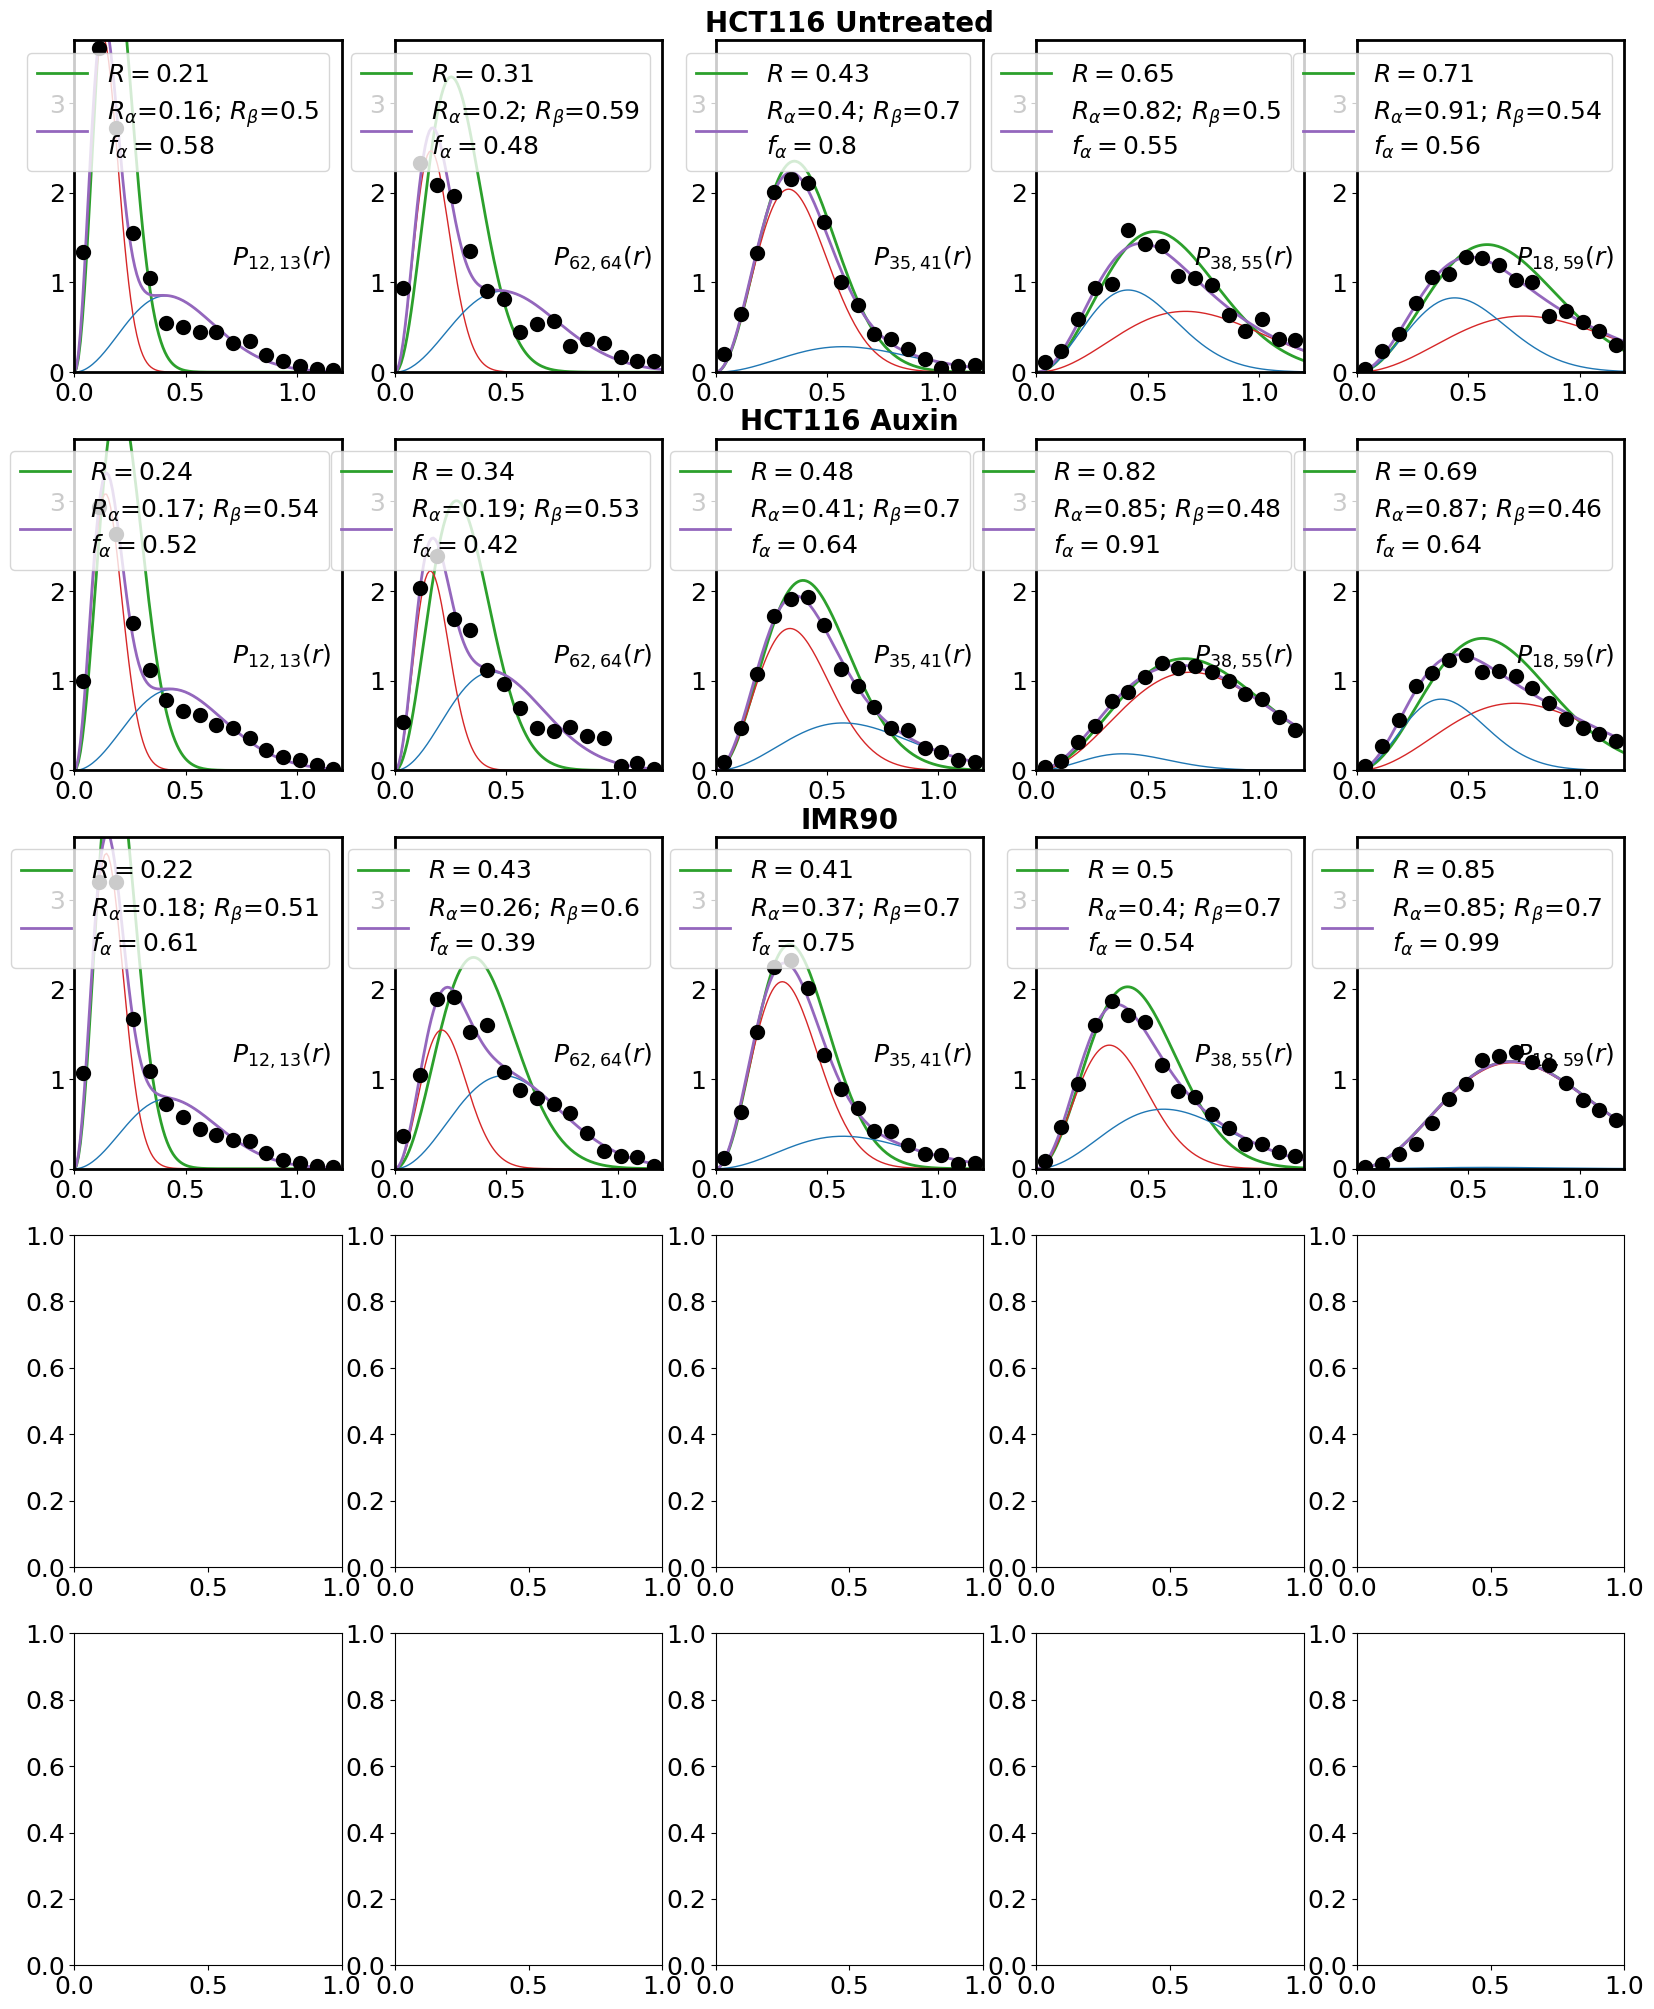

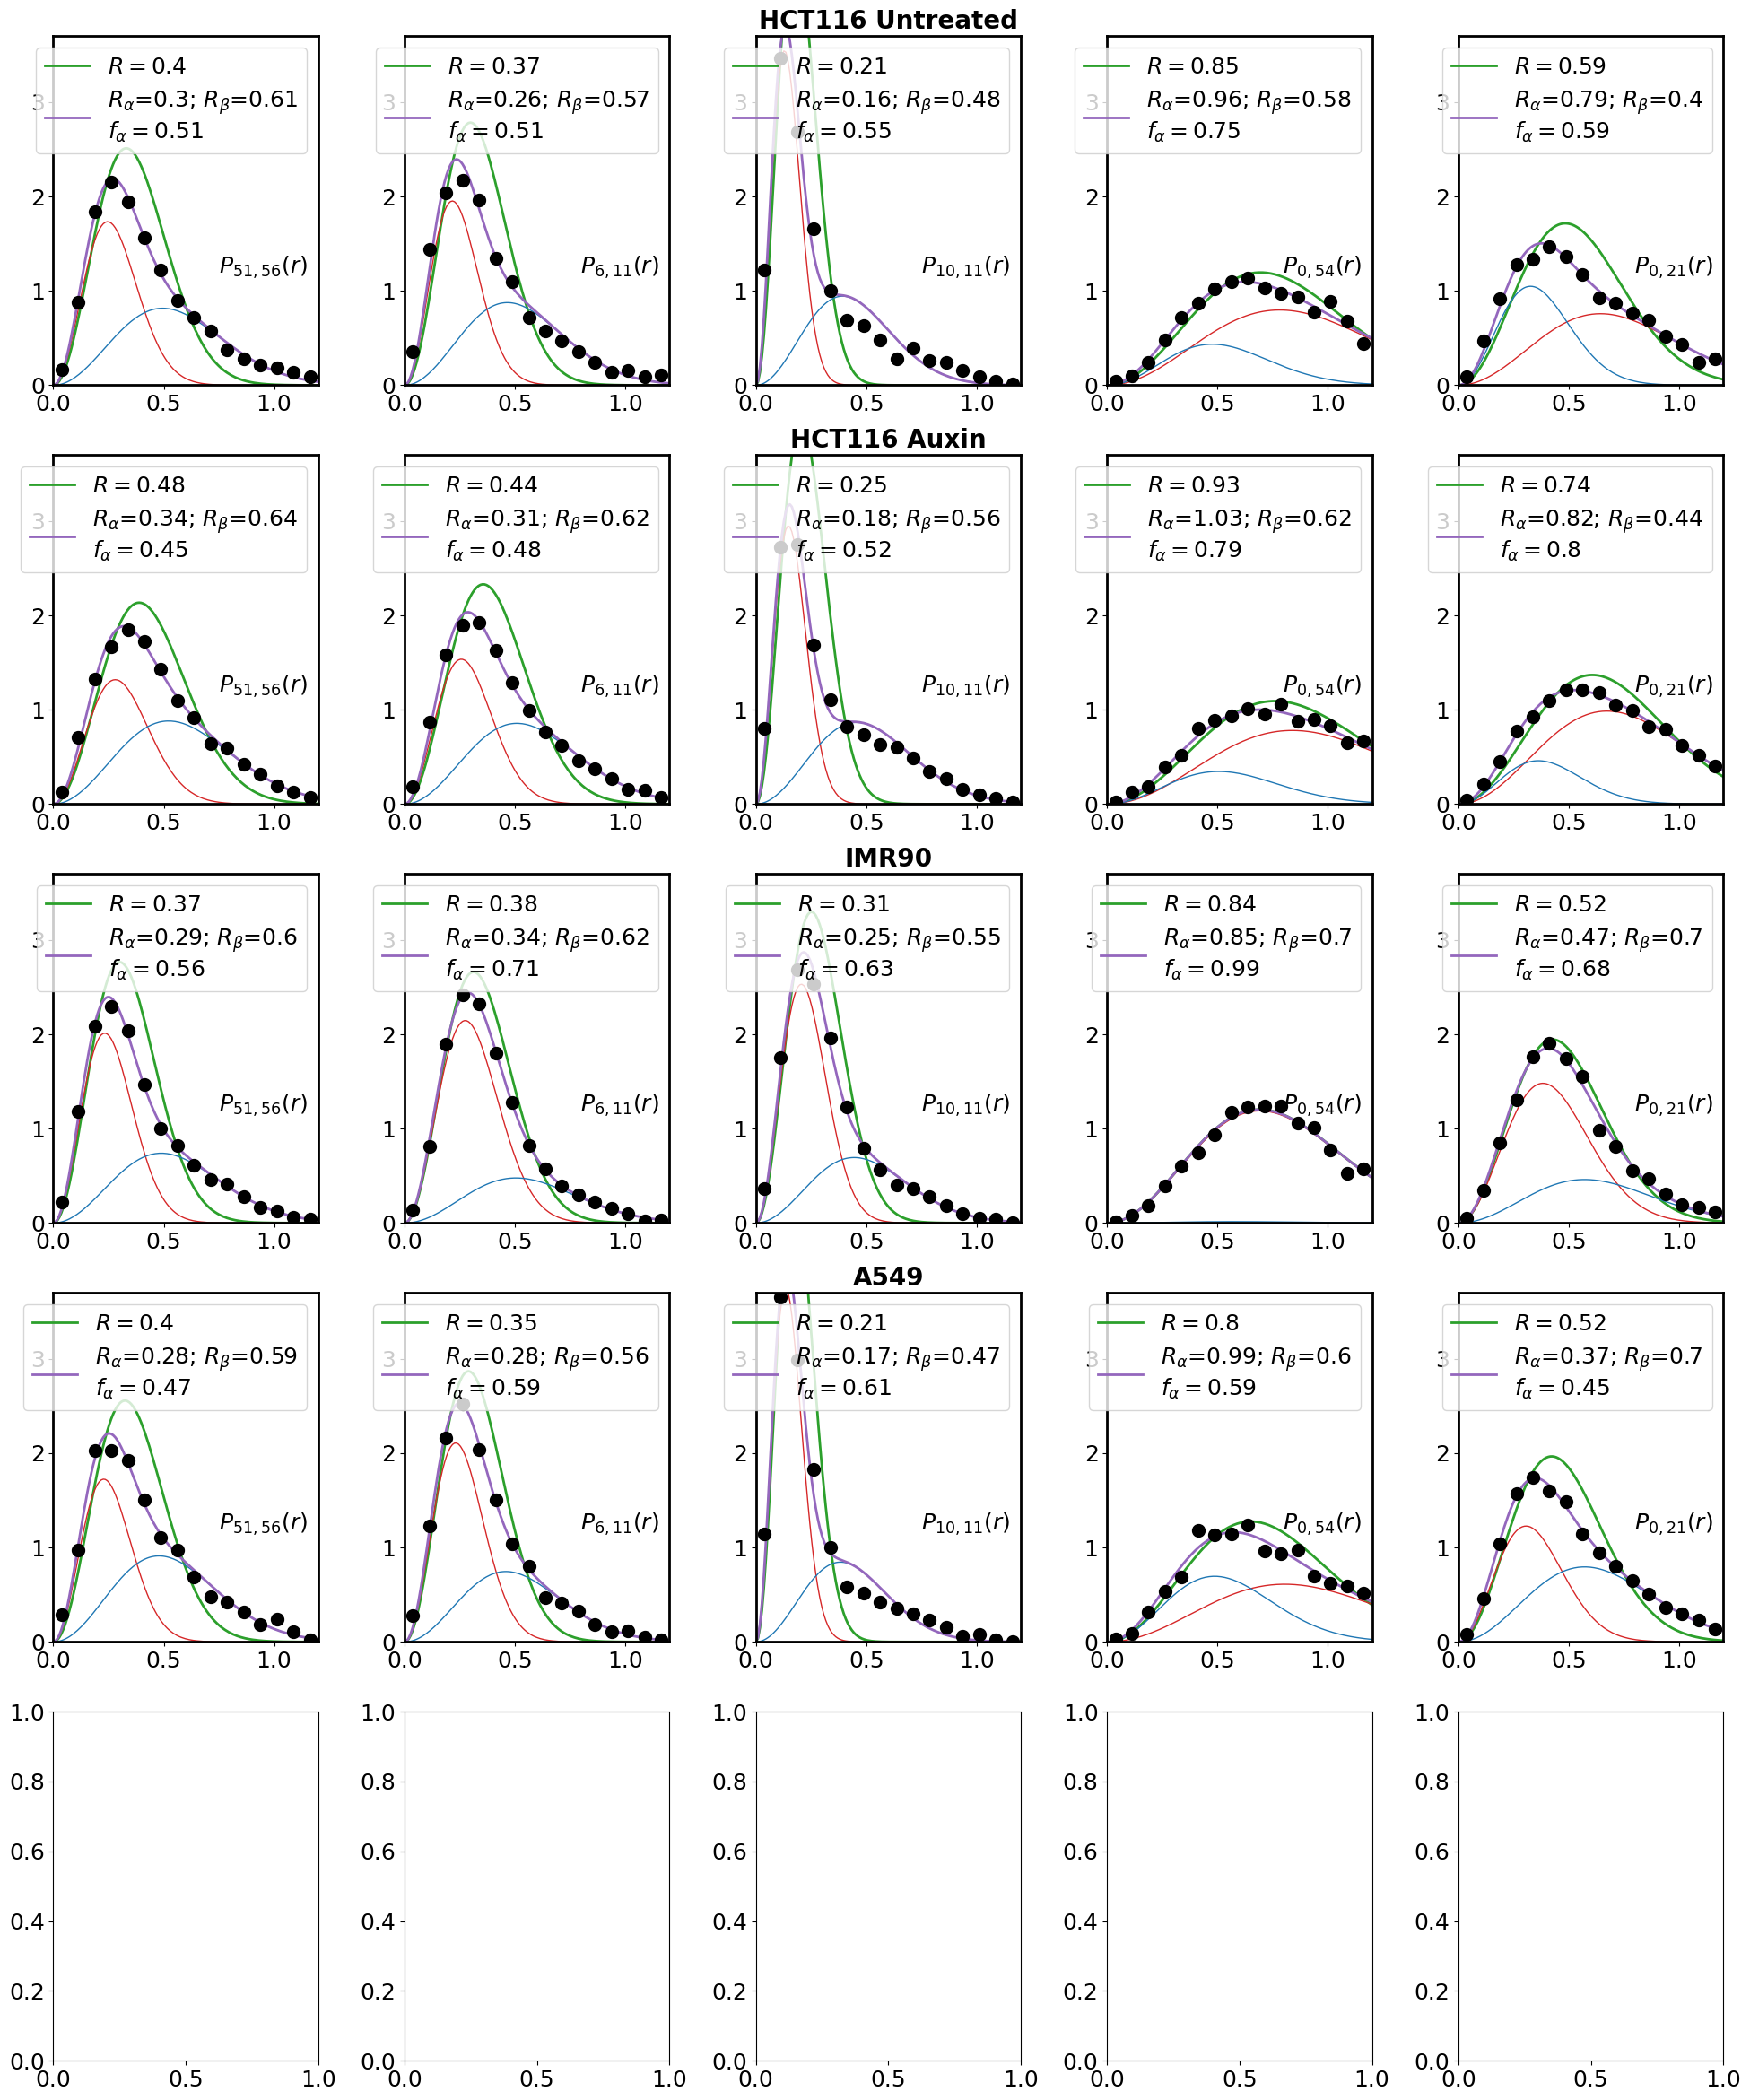

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Initialize parameters
bin_max = 1.8
nbr_bins = 25
bins = np.linspace(0, bin_max, nbr_bins)

# Define the number of random pairs to analyze per cell line
num_pairs_per_cell_line = 5

# Define the cell lines to analyze
cell_lines = ['HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2', 'IMR90', 'A549']
cell_line_names = ['HCT116 Untreated', 'HCT116 Auxin', 'IMR90', 'A549']

# Create a new figure for plotting
fig, axes = plt.subplots(5, 5, figsize=(20, 25))
axes = axes.flatten()

# Initialize subplot index
subplot_idx = 0

# Get the distance matrix for the first cell line to generate pairs
dm = RESULTS[cell_lines[0]]['distmat']
n = dm.shape[1]

# Ensure num_pairs does not exceed the possible unique pairs
max_pairs = n * (n - 1) // 2
num_pairs = min(num_pairs_per_cell_line, max_pairs)

# Generate all possible unique pairs of indices
all_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

# Separate pairs based on the distance condition
close_pairs = [(i, j) for (i, j) in all_pairs if abs(i - j) < 7]
far_pairs = [(i, j) for (i, j) in all_pairs if abs(i - j) > 6]

# Select random pairs for the first three rows (close pairs)
selected_close_pairs_indices = np.random.choice(len(close_pairs), 3, replace=False)
selected_close_pairs = [close_pairs[idx] for idx in selected_close_pairs_indices]

# Select random pairs for the last two rows (far pairs)
selected_far_pairs_indices = np.random.choice(len(far_pairs), 2, replace=False)
selected_far_pairs = [far_pairs[idx] for idx in selected_far_pairs_indices]

# Combine selected pairs for plotting
selected_pairs = selected_close_pairs + selected_far_pairs

# Iterate over different cell lines
for idx, cell_line in enumerate(cell_lines):
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Iterate over the selected indices and plot the fitted PDFs
    for (i, j) in selected_pairs:
        ax = axes[subplot_idx]
        distances = dm[:, i, j]
        hist, bin_edges = np.histogram(distances, bins=bins, density=True)
        bc = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit a Gaussian distribution to the data
        param1, pcov1 = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [bin_max]))
        std1 = np.sqrt(np.diag(pcov1))

        # Fit a weighted combination of two Gaussian distributions to the data
        initial_guess = (0.5, 0.5, 0.5)  # Initial guesses for R1, R2, and f
        param2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([param1[0]-0.2, 0.4, 0.0], [param1[0]+0.2, 0.7, 0.99]))
        std2 = np.sqrt(np.diag(pcov2))

        ra = param2[0]
        rb = param2[1]
        fa = param2[2]

        # Create a range for plotting
        rr_plot = np.linspace(0, 1.8, 200)

        # Plot the Gaussian distribution with parameters and labels
        ax.plot(rr_plot, GAUSSIAN_DISTR(rr_plot, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)))
        # ax.fill_between(rr_plot, GAUSSIAN_DISTR(rr_plot, param1[0] - std1[0]), GAUSSIAN_DISTR(rr_plot, param1[0] + std1[0]), color='tab:green', alpha=0.2)

        ax.plot(rr_plot, fa * GAUSSIAN_DISTR(rr_plot, ra), color='tab:red', lw=1)
        ax.plot(rr_plot, (1 - fa) * GAUSSIAN_DISTR(rr_plot, rb), color='tab:blue', lw=1)

        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(ra, 2)) + r'; $R_\beta$=' + str(np.round(rb, 2)) + '\n' + r'$f_\alpha=$' + str(np.round(fa, 2))
        ax.plot(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *param2), c='tab:purple', lw=2, label=label)
        # ax.fill_between(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *(param2 - std2)), TWO_GAUSSIAN_DISTR(rr_plot, *(param2 + std2)), color='tab:purple', alpha=0.2)

        # Plot the data points
        ax.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        ax.set_xlim([0, 1.2])
        ax.set_ylim([0, 3.7])
        ax.legend(loc='upper right', fontsize=18)

        # Add text with tag information
        ax.text(0.96, 0.32, rf'$P_{{{i},{j}}}(r)$', transform=ax.transAxes, fontsize=18, ha='right')

        # Set the color of the spines to black and linewidth to 2
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        # Set the font size for the tick labels
        ax.tick_params(axis='both', which='major', labelsize=18)

        # Remove the grid
        ax.grid(False)
        # Add subtitle for the current cell line
        if subplot_idx % 5 == 2:
            ax.set_title(cell_line_names[idx], fontsize=20, fontweight='bold')

        # Increment subplot index
        subplot_idx += 1

# Adjust the layout for better presentation
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2)  # Increase vertical space between subfigure lines

# Save the plot as a PDF file
plt.savefig('random_pairs_distr.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the bins for the histogram
bin_max = 1.8
nbr_bins = 25
bins = np.linspace(0, bin_max, nbr_bins)

# Define the cell line to analyze
cell_line = 'HCT116_UNTREATED_FILE_2'
cell_line_name = 'HCT116 Untreated'

# Get the distance matrix for the current cell line
dm = RESULTS[cell_line]['distmat']

# Select a fixed tag i
fixed_i = 10

# Define a range of tags j to analyze
tags_j = range(11, 21)

# Create a new figure for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize lists to store the results
f_alpha_values = []
tags = []

# Iterate over the selected tags j
for j in tags_j:
    distances = dm[:, fixed_i, j]
    hist, bin_edges = np.histogram(distances, bins=bins, density=True)
    bc = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit a weighted combination of two Gaussian distributions to the data
    initial_guess = (0.5, 0.5, 0.5)  # Initial guesses for R1, R2, and f
    param2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([0, 0, 0], [bin_max, bin_max, 1]))
    f_alpha = param2[2]

    # Store the results
    f_alpha_values.append(f_alpha)
    tags.append(j)

# Plot the results
ax.plot(tags, f_alpha_values, 'o-', color='black', lw=2, label=r'$f_\alpha(i,j)$')
ax.set_xlabel('Tag j', fontsize=18)
ax.set_ylabel(r'$f_\alpha$', fontsize=18)
ax.set_title(f'{cell_line_name}: $f_\alpha$ for fixed i={fixed_i}', fontsize=20, weight='bold')
ax.legend(fontsize=18)
ax.grid(True)

# Customize the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(axis='both', which='major', labelsize=18)

# Adjust the layout for better presentation
# plt.tight_layout(pad=2.0)
plt.show()

ValueError: 
f_lpha
  ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\x07'  (at char 2), (line:1, col:3)

<Figure size 1000x600 with 1 Axes>

ValueError: 
f_lpha
  ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\x07'  (at char 2), (line:1, col:3)

<Figure size 1000x600 with 1 Axes>

ValueError: 
f_lpha
  ^
ParseSyntaxException: Expected {accent | symbol | function | operatorname | group | frac | dfrac | binom | genfrac | overset | underset | sqrt | overline | text | boldsymbol | substack}, found '\x07'  (at char 2), (line:1, col:3)

<Figure size 1000x600 with 1 Axes>

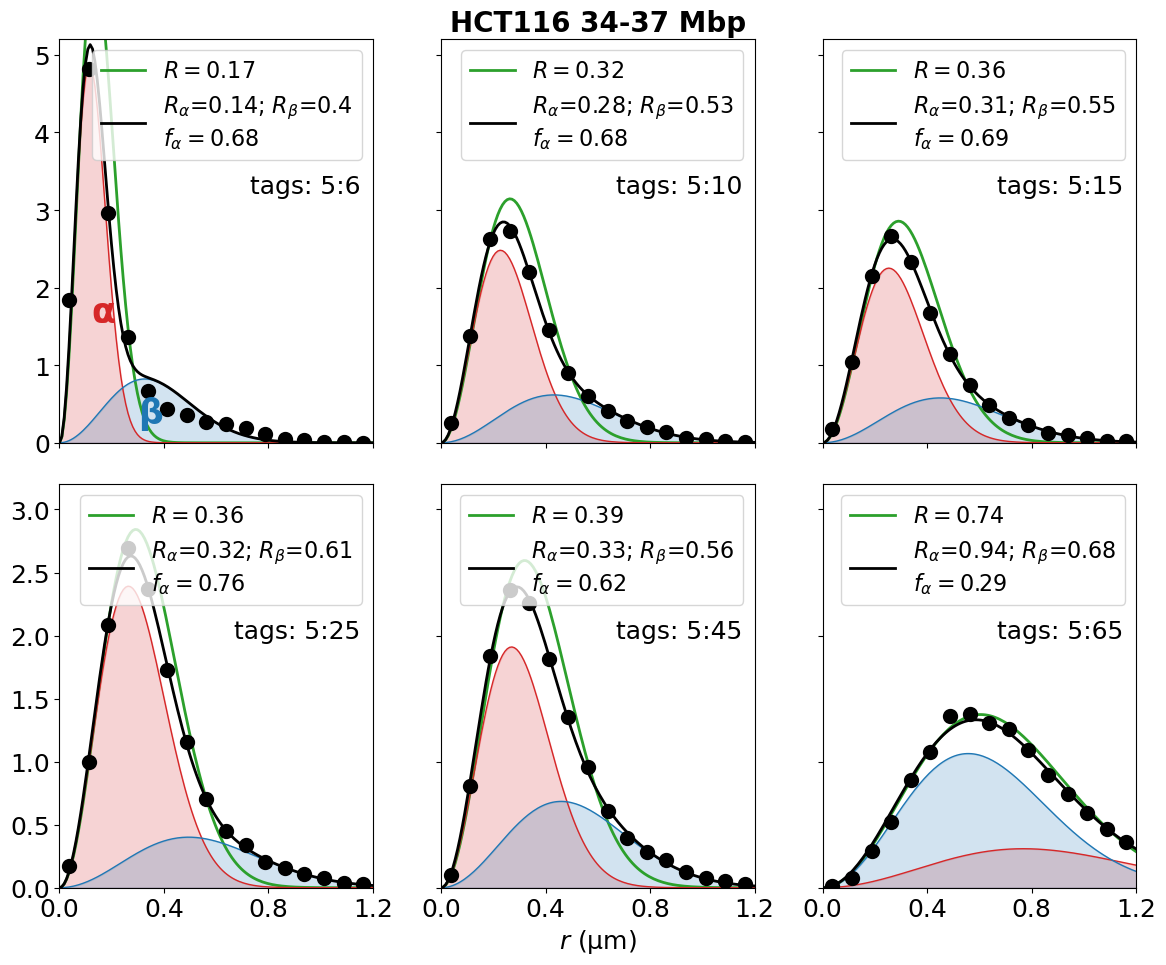

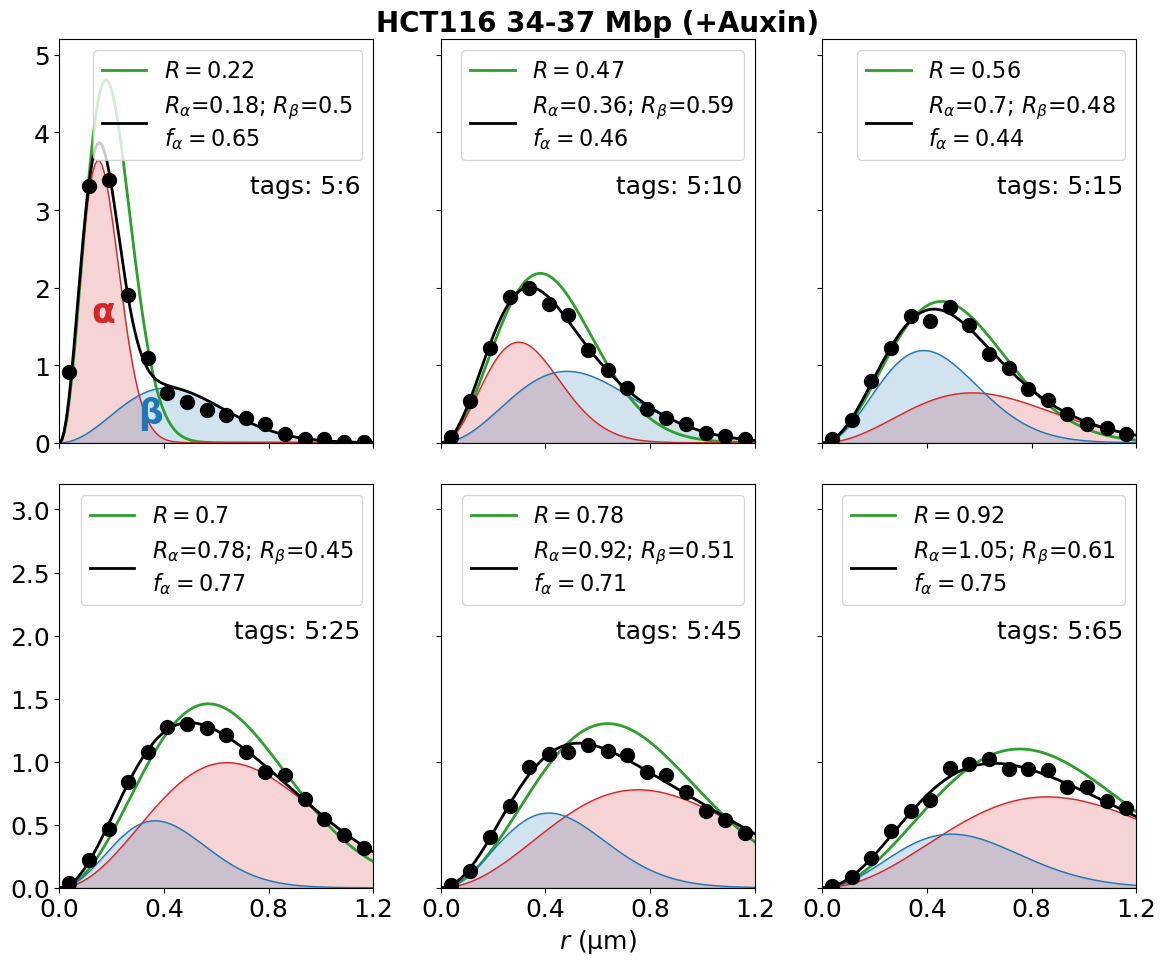

In [59]:
# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Iterate over different cell lines ('HCT116' and 'HCT116_AUXIN')
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 10))

    # Iterate over different tag differences (dtag)
    for i, dt in enumerate(dtag):
        # Extract distances based on the tag and tag difference
        rr = dm[:, tag - 1, tag + dt - 1]

        # Create a histogram and calculate bin centers
        hist, bins = np.histogram(rr, bins=bins, density=True)
        bc = 0.5 * (bins[1:] + bins[:-1])

        # Fit a Gaussian distribution to the data
        param1, pcov = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [2]))

        # Fit a weighted combination of two Gaussian distributions to the data
        param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([param1[0]-0.2, 0.4, 0.0], [param1[0]+0.2, 0.7, 0.99]))


        # Create a range for plotting
        rr = np.linspace(0, 1.8, 200)

        # Add a subplot to the figure
        ax = fig.add_subplot(nplots[i])

        # Customize the first subplot with a title
        if nplots[i] == 232:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')

        # Plot the Gaussian distribution with parameters and labels
        plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) )
        plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
        plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
        plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
        plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)
        
        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) 
        plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Plot the data points
        plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        plt.xlim([0, 1.2])
        if nplots[i] in [231, 232, 233]:
            plt.ylim([0, 5.2])
        if nplots[i] in [234, 235, 236]:
            plt.ylim([0, 3.2])
        plt.legend(loc='upper right', fontsize=16)

        # Add text with tag information
        plt.text(0.96, 0.62, f'tags: {tag}:{tag+dt}', transform=ax.transAxes, fontsize=18, ha='right')

        # Customize plot appearance
        if nplots[i] in [231]:
            plt.text(0.1, 0.3, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=25, color='tab:red')
            plt.text(0.25, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=25, color='tab:blue')
        plt.tick_params(labelsize=18)
        if nplots[i] in [ 235]:
            plt.xlabel(r'$r$ (µm)', size=18)
        if nplots[i] in [231]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
        if nplots[i] in [232, 233]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
            plt.yticks([0, 1, 2, 3, 4, 5], [])
        if nplots[i] in [235, 236]:
            plt.yticks([0, 1,  2, 3], [])
        if nplots[i] > 233:
            plt.xticks([0, 0.4, 0.8, 1.2])

    # Adjust the layout for better presentation
    plt.tight_layout()
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

    # Display the plot
    plt.show()


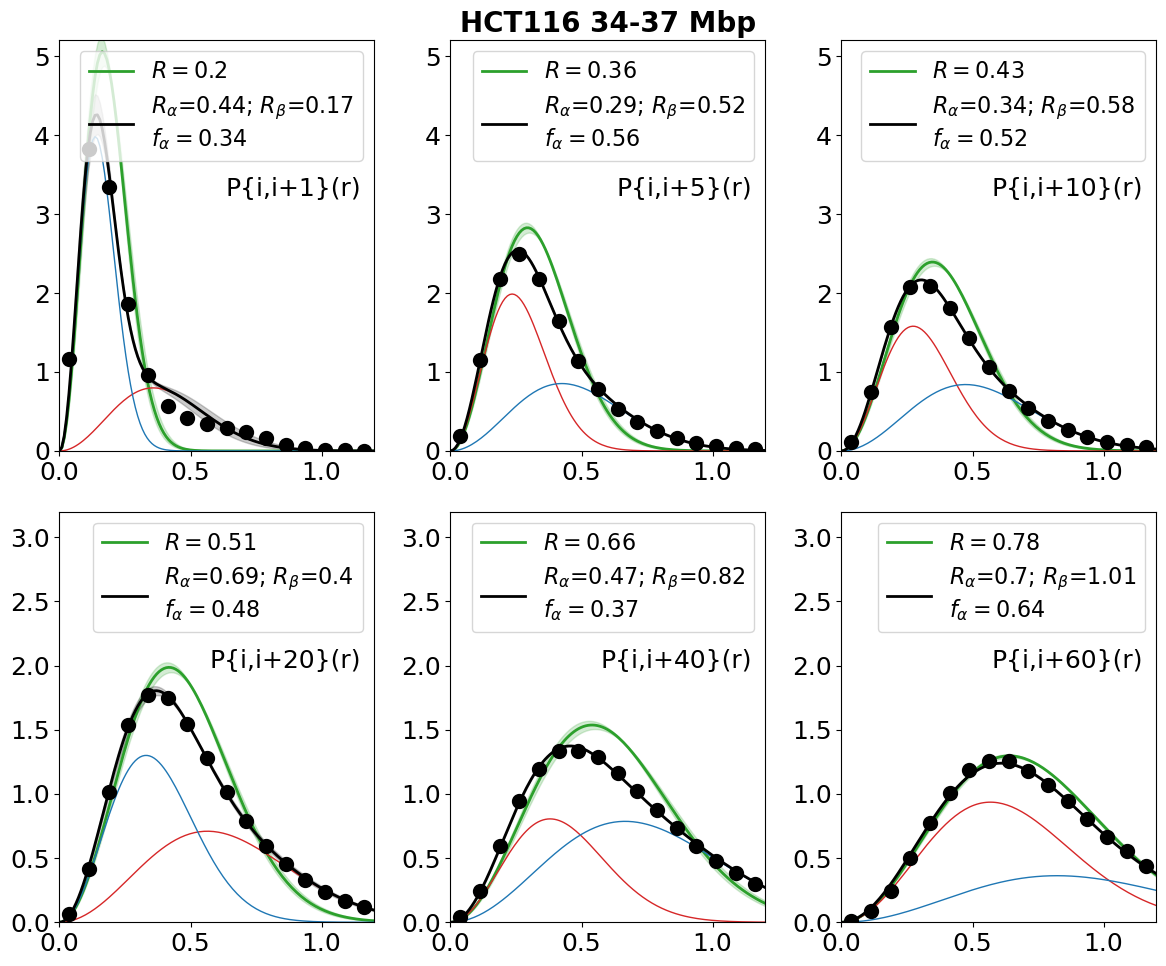

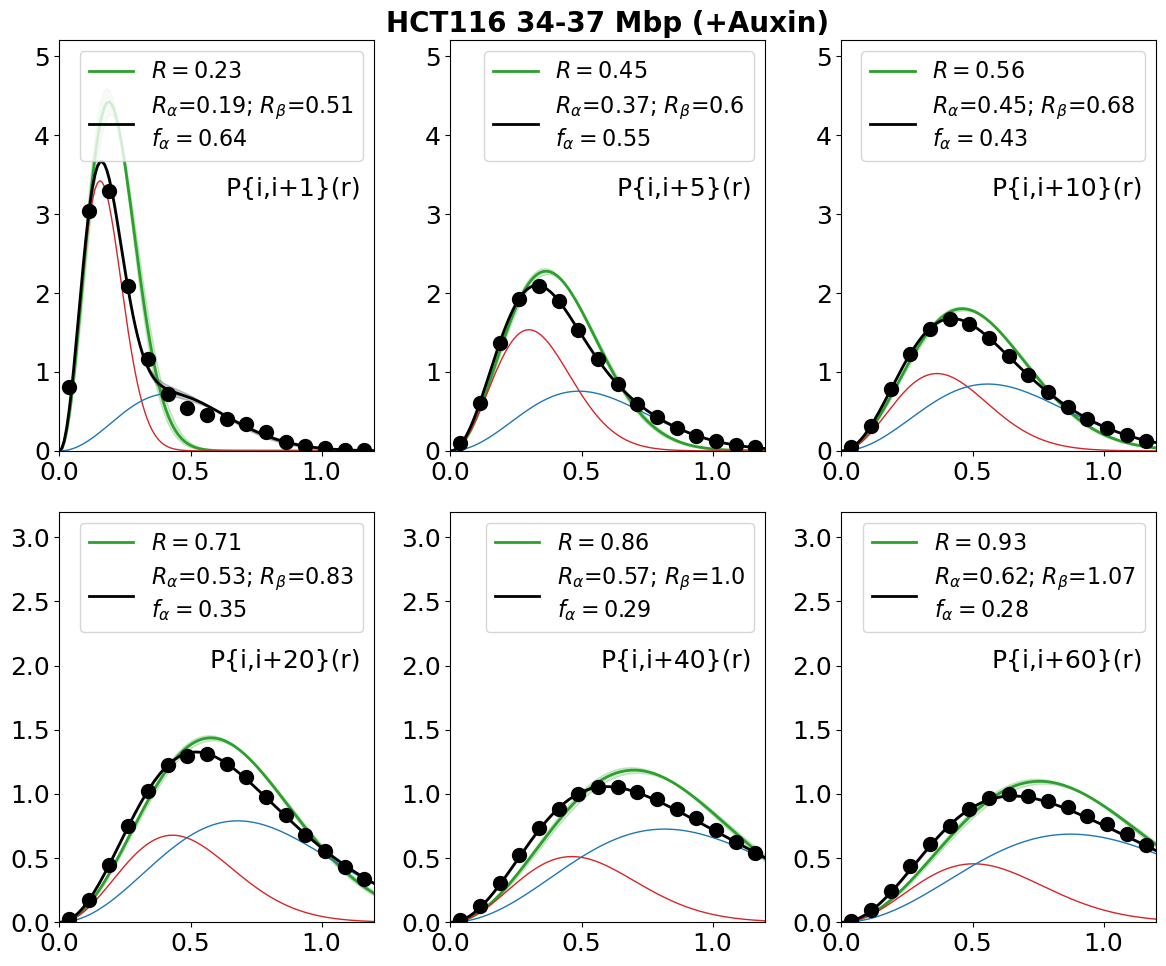

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Initialize parameters
bin_max = 1.8
nbr_bins = 25
bins = np.linspace(0, bin_max, nbr_bins)

# Define a list of tag differences to analyze
dtag = [1, 5, 10, 20, 40, 60]
# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Iterate over different cell lines ('IMR90')
for cell_line in ['HCT116','HCT116_AUXIN']:
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 10))

    # Iterate over different tag differences (dtag)
    for i, dt in enumerate(dtag):
        # Extract distances for all pairs of tags such that the difference between tags is equal to dt
        rr = []
        for tag1 in range(dm.shape[1]):
            for tag2 in range(tag1 + 1, dm.shape[1]):
                if tag2 - tag1 == dt:
                    rr.extend(dm[:, tag1, tag2])
        rr = np.array(rr)

        # Create a histogram and calculate bin centers
        hist, bins = np.histogram(rr, bins=bins, density=True)
        bc = 0.5 * (bins[1:] + bins[:-1])

        # Fit a Gaussian distribution to the data
        param1, pcov1 = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [bin_max]))
        std1 = np.sqrt(np.diag(pcov1))

        # Fit a weighted combination of two Gaussian distributions to the data
        # Define initial guesses for R1, R2, and f
        initial_guess = (1.0, 1.0, 0.7)  # Adjust these values based on your data
        
        # Perform curve fitting with initial guess
        param2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, p0=initial_guess, bounds=(0.05, [bin_max, bin_max, 1]))
        std2 = np.sqrt(np.diag(pcov2))
        
        #ra = np.min([param2[0], param2[1]])
        #rb = np.max([param2[0], param2[1]])
        #if ra == param2[0]:
        #    fa = param2[2]
        #else:
        #    fa = 1 - param2[2]
        ra = param2[0]
        rb = param2[1]
        fa = param2[2]


        # Create a range for plotting
        rr_plot = np.linspace(0, 1.8, 200)

        # Add a subplot to the figure
        ax = fig.add_subplot(nplots[i])

        # Customize the first subplot with a title
        if nplots[i] == 232:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')
        
        # Plot the Gaussian distribution with parameters and labels
        plt.plot(rr_plot, GAUSSIAN_DISTR(rr_plot, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)))
        plt.fill_between(rr_plot, GAUSSIAN_DISTR(rr_plot, param1[0] - std1[0]), GAUSSIAN_DISTR(rr_plot, param1[0] + std1[0]), color='tab:green', alpha=0.2)
        
        #plt.fill_between(rr_plot, fa * GAUSSIAN_DISTR(rr_plot, ra), color='tab:red', alpha=0.2)
        plt.plot(rr_plot, fa * GAUSSIAN_DISTR(rr_plot, ra), color='tab:red', lw=1)
        #plt.fill_between(rr_plot, (1 - fa + std2[2]) * GAUSSIAN_DISTR(rr_plot, rb - std2[1]),(1 - fa - std2[2]) * GAUSSIAN_DISTR(rr_plot, rb + std2[1]), color='tab:blue', alpha=0.2)
        plt.plot(rr_plot, (1 - fa) * GAUSSIAN_DISTR(rr_plot, rb), color='tab:blue', lw=1)

        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(ra, 2)) + r'; $R_\beta$=' + str(np.round(rb, 2)) + '\n' + r'$f_\alpha=$' + str(np.round(fa, 2))
        plt.plot(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *param2), c='black', lw=2, label=label)
        plt.fill_between(rr_plot, TWO_GAUSSIAN_DISTR(rr_plot, *(param2 - std2)), TWO_GAUSSIAN_DISTR(rr_plot, *(param2 + std2)), color='black', alpha=0.2)

        # Plot the data points
        plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        plt.xlim([0, 1.2])
        if nplots[i] in [231, 232, 233]:
            plt.ylim([0, 5.2])
        if nplots[i] in [234, 235, 236]:
            plt.ylim([0, 3.2])
        plt.legend(loc='upper right', fontsize=16)

        # Add text with tag information
        plt.text(0.96, 0.62, r'P{i,i+'+ str(dt)+'}(r)', transform=ax.transAxes, fontsize=18, ha='right')

    # Adjust the layout for better presentation
    plt.tight_layout()
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

    # Display the plot
    plt.show()

## 3.2 Chromosome 21 : 28-30 Mbp

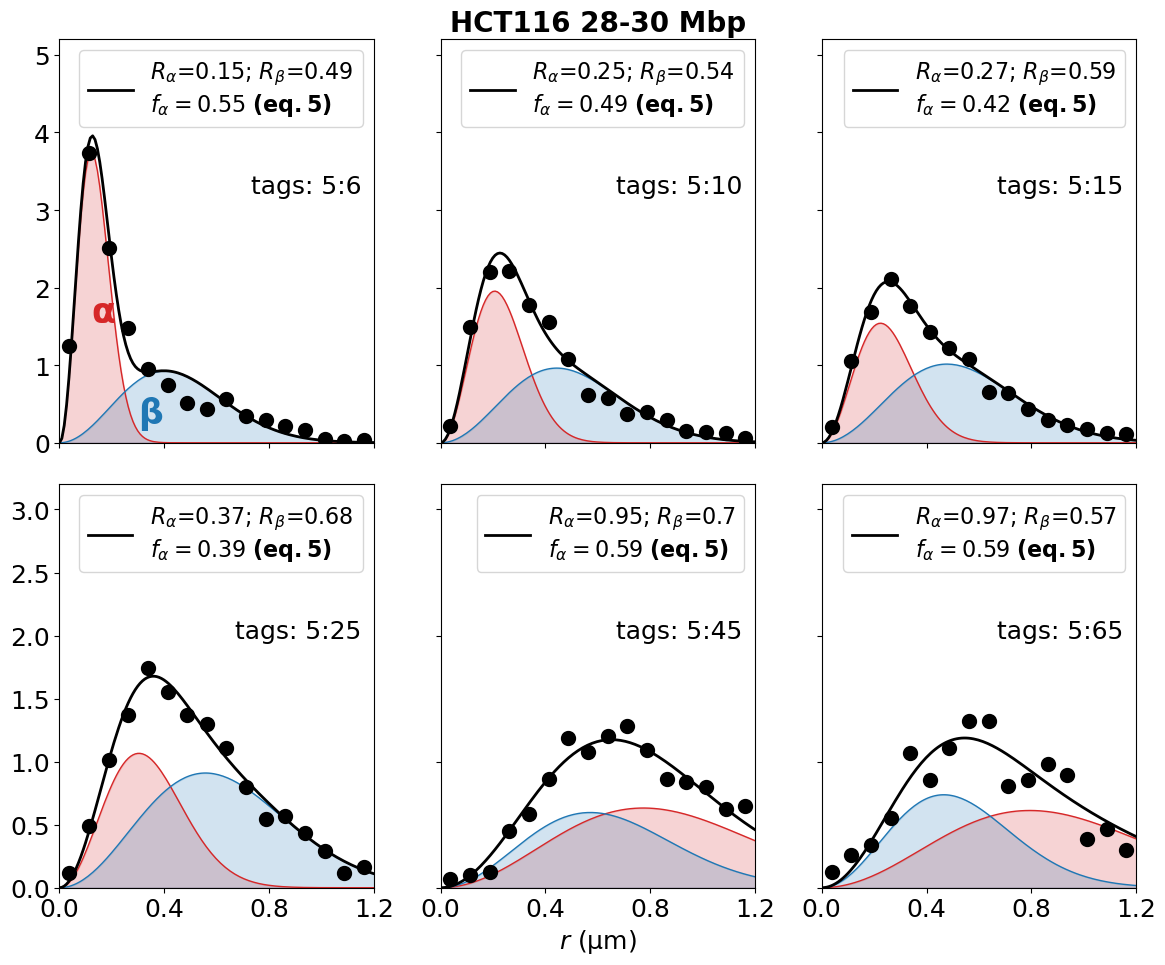

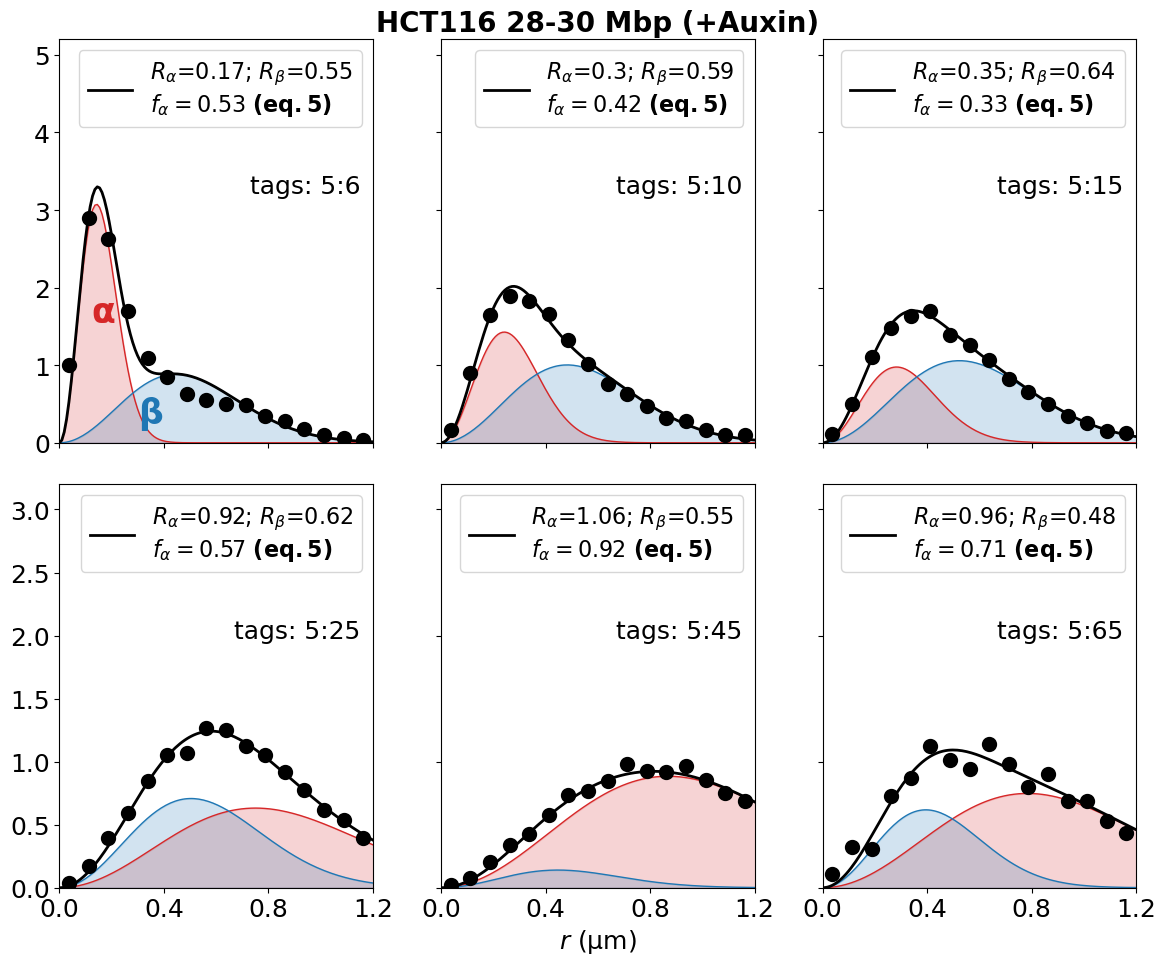

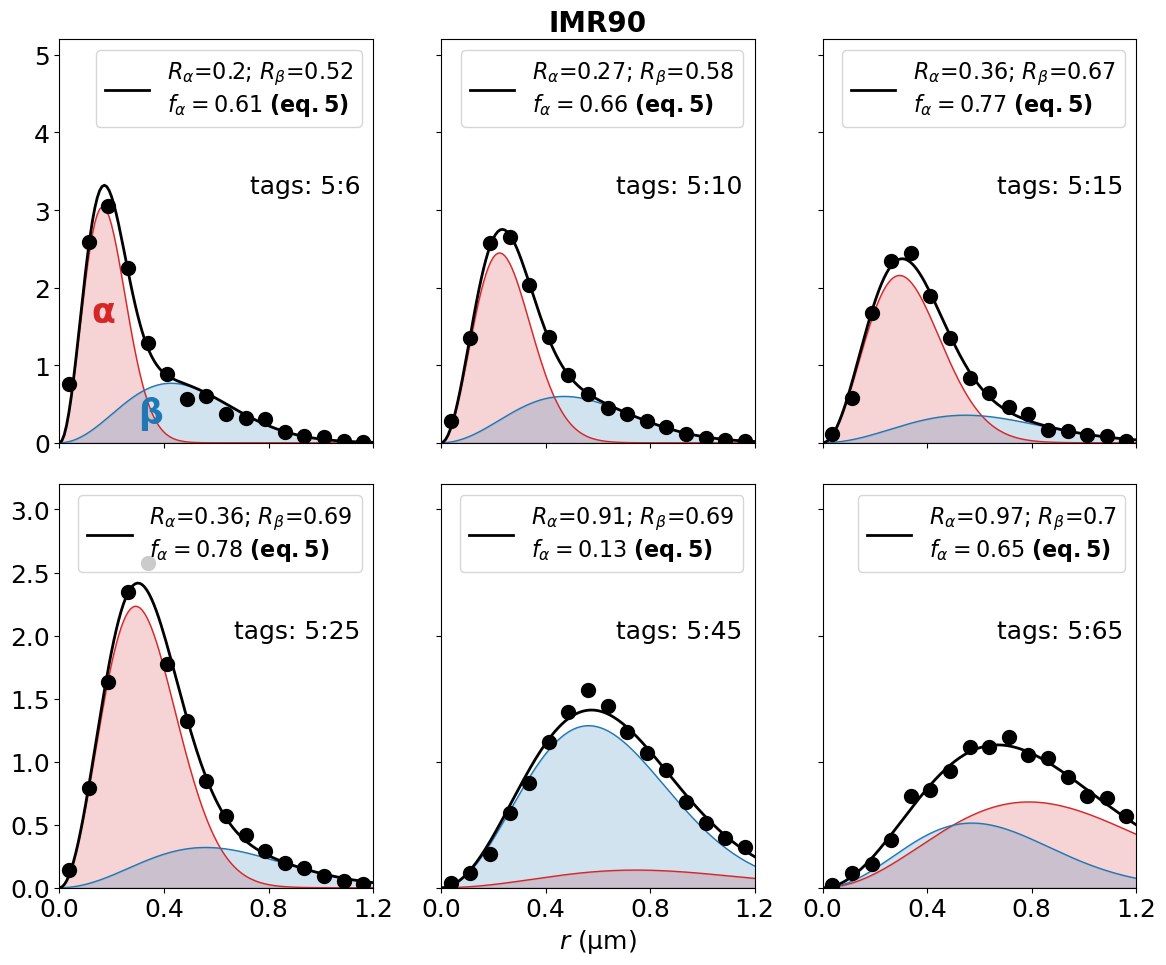

KeyError: 'K562'

In [61]:
tag = 5
# Define subplot positions for plotting
nplots = [231, 232, 233, 234, 235, 236]

# Iterate over different cell lines ('IMR90' and 'K562')
for cell_line in ['HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2', 'IMR90', 'K562','A549']:
    # Get the distance matrix for the current cell line
    dm = RESULTS[cell_line]['distmat']

    # Create a new figure for plotting
    fig = plt.figure(figsize=(12, 10))

    # Iterate over different tag differences (dtag)
    for i, dt in enumerate(dtag):
        # Extract distances based on the tag and tag difference
        rr = dm[:, tag - 1, tag + dt - 1]

        # Create a histogram and calculate bin centers
        hist, bins = np.histogram(rr, bins=bins, density=True)
        bc = 0.5 * (bins[1:] + bins[:-1])

        # Fit a Gaussian distribution to the data
        param1, pcov = curve_fit(GAUSSIAN_DISTR, bc, hist, bounds=([0], [2]))
        Rg = param1[0]

        # Fit a weighted combination of two Gaussian distributions to the data
        param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bc, hist, bounds=([param1[0]-0.2, 0.4, 0.0], [param1[0]+0.2, 0.7, 0.99]))

        # Create a range for plotting
        rr = np.linspace(0, 1.8, 200)

        # Add a subplot to the figure
        ax = fig.add_subplot(nplots[i])

        # Customize the first subplot with a title
        if nplots[i] == 232:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')

        # Plot the Gaussian distribution with parameters and labels
        #plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + r' $\mathbf{(eq. 2)}$')
        plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
        plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
        plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
        plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)
        
        # Add labels for the weighted Gaussian distribution
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) + r' $\mathbf{(eq. 5)}$'
        plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Plot the data points
        plt.plot(bc, hist, 'o', ms=8, mew=3, mec='black', c='black')

        # Customize plot limits and legend position
        plt.xlim([0, 1.2])
        if nplots[i] in [231, 232, 233]:
            plt.ylim([0, 5.2])
        if nplots[i] in [234, 235, 236]:
            plt.ylim([0, 3.2])
        plt.legend(loc='upper right', fontsize=16)

        # Add text with tag information
        plt.text(0.96, 0.62, f'tags: {tag}:{tag+dt}', transform=ax.transAxes, fontsize=18, ha='right')

        # Customize plot appearance
        if nplots[i] in [231]:
            plt.text(0.1, 0.3, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=25, color='tab:red')
            plt.text(0.25, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=25, color='tab:blue')
        plt.tick_params(labelsize=18)
        if nplots[i] in [ 235]:
            plt.xlabel(r'$r$ (µm)', size=18)
        if nplots[i] in [231]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
        if nplots[i] in [232, 233]:
            plt.xticks([0, 0.4, 0.8, 1.2], [])
            plt.yticks([0, 1, 2, 3, 4, 5], [])
        if nplots[i] in [235, 236]:
            plt.yticks([0, 1,  2, 3], [])
        if nplots[i] > 233:
            plt.xticks([0, 0.4, 0.8, 1.2])

    # Adjust the layout for better presentation
    plt.tight_layout()
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_distr.svg', facecolor='white', dpi=500)

    # Display the plot
    plt.show()


## 3.3 Summary diagrams of $R_\alpha$, $R_\beta$ and $f_\alpha$ for all the cell lines

In [23]:
# # Define the chi-squared function
# def chi_squared(observed, expected):
#     return np.sum((observed - expected) ** 2 / expected)
#
# # Update the fitting loop
# for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90','A549','HCT116_UNTREATED_FILE_2','HCT116_AUXIN_FILE_2']):
#     distance_mats = RESULTS[cell_line]['distmat']
#
#     ni = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
#     nj = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
#     bins = np.linspace(0, 1.8, 25)
#
#     Re1_matrix = np.zeros((len(ni), len(nj)))
#     Re2_matrix = np.zeros((len(ni), len(nj)))
#     fr_matrix = np.zeros((len(ni), len(nj)))
#     Rg_matrix = np.zeros((len(ni), len(nj)))
#
#     for i in range(len(ni)):
#         for j in range(i, len(nj)):
#             nx = ni[i]
#             ny = nj[j]
#
#             datah = np.array(distance_mats[:, nx, ny])
#             nn, bins = np.histogram(datah, bins)
#
#             b0 = bins[0]
#             bins2 = []
#             deltab = []
#
#             for bb in bins[1:]:
#                 bins2.append((bb + b0) / 2)
#                 deltab.append(bb - b0)
#                 b0 = bb
#
#             if np.sum(nn) == 0:
#                 continue
#             else:
#                 bins2 = np.array(bins2)  # Convert bins2 to numpy array
#
#                 # Fit with one Gaussian
#                 popt1, pcov1 = curve_fit(GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn), bounds=([0], [2]))
#                 Rg = popt1[0]
#                 Rg_matrix[i, j] = np.round(Rg, 2)
#                 Rg_matrix[j, i] = Rg_matrix[i, j]
#
#                 # Calculate chi-squared for one Gaussian
#                 expected_one_gaussian = GAUSSIAN_DISTR(bins2, *popt1)
#                 chi2_one_gaussian = chi_squared((nn / deltab) / np.sum(nn), expected_one_gaussian)
#
#                 # Fit with two Gaussians
#                 # popt2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn),
#                 #                          bounds=([Rg-0.2, 0.4, 0.0], [Rg+0.2, 0.75, 0.99]))
#
#                 popt2, pcov2 = curve_fit(TWO_GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn),
#                                          bounds=([0.0, 0.2, 0.01], [Rg+0.3, 0.8, 0.99]))
#                 # Calculate chi-squared for two Gaussians
#                 expected_two_gaussian = TWO_GAUSSIAN_DISTR(bins2, *popt2)
#                 chi2_two_gaussian = chi_squared((nn / deltab) / np.sum(nn), expected_two_gaussian)
#
#                 # Compare chi-squared values
#                 # if chi2_one_gaussian <= chi2_two_gaussian * 1.2:  # Adjust the threshold as needed
#                 #     Re1_matrix[i, j] = np.round(Rg, 2)
#                 #     Re2_matrix[i, j] = np.round(Rg, 2)
#                 #     fr_matrix[i, j] = 1
#                 # else:
#
#                 Re1 = popt2[0]
#                 Re2 = popt2[1]
#                 fr = popt2[2]
#
#                 Re1_matrix[i, j] = np.round(Re1, 2)
#                 Re2_matrix[i, j] = np.round(Re2, 2)
#                 fr_matrix[i, j] = fr
#
#                 # Use symmetry to avoid redundant fitting
#                 Re1_matrix[j, i] = Re1_matrix[i, j]
#                 Re2_matrix[j, i] = Re2_matrix[i, j]
#                 fr_matrix[j, i] = fr_matrix[i, j]
#
#     RESULTS[cell_line]['Re1_matrix'] = Re1_matrix
#     RESULTS[cell_line]['Re2_matrix'] = Re2_matrix
#     RESULTS[cell_line]['fr_matrix'] = fr_matrix
#     RESULTS[cell_line]['Rg_matrix'] = Rg_matrix
#
#     # Raw mean values:
#     RESULTS[cell_line]['Rt_matrix'] =  np.round(np.sqrt(np.nanmean(distance_mats**2, axis=0)), 2)
#     RESULTS[cell_line]['Median_matrix']= np.round(np.nanmedian(distance_mats, axis=0), 2)
#     print(cell_line, ': done')

In [62]:
# OLD

# Update the fitting loop
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90','A549','HCT116_UNTREATED_FILE_2','HCT116_AUXIN_FILE_2']):
    distance_mats = RESULTS[cell_line]['distmat']

    ni = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    nj = np.linspace(0, distance_mats.shape[1] - 1, distance_mats.shape[1], dtype=int)
    bins = np.linspace(0, 1.8, 25)

    Re1_matrix = np.zeros((len(ni), len(nj)))
    Re2_matrix = np.zeros((len(ni), len(nj)))
    fr_matrix = np.zeros((len(ni), len(nj)))
    Rg_matrix = np.zeros((len(ni), len(nj)))

    for i in range(len(ni)):
        for j in range(i, len(nj)):
            nx = ni[i]
            ny = nj[j]

            datah = np.array(distance_mats[:, nx, ny])
            nn, bins = np.histogram(datah, bins)

            b0 = bins[0]
            bins2 = []
            deltab = []

            for bb in bins[1:]:
                bins2.append((bb + b0) / 2)
                deltab.append(bb - b0)
                b0 = bb

            if np.sum(nn) == 0:
                continue
            else:
                bins2 = np.array(bins2)  # Convert bins2 to numpy array

            # Fit with one Gaussian
            popt1, pcov1 = curve_fit(GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn), bounds=([0], [2]))
            Rg = popt1[0]
            Rg_matrix[i, j] = np.round(Rg, 2)
            Rg_matrix[j, i] = Rg_matrix[i, j]

            popt2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bins2, (nn / deltab) / np.sum(nn),
                   bounds=([0.0, 0.2, 0.01], [1.2, 1.0, 0.99]))  # R1 bounds: (0.05, 1.0) , R2 bounds: (0.05, 1.5)

            Re1 = min(popt2[0], popt2[1])
            Re2 = max(popt2[0], popt2[1])
            if Re1 == popt2[0]:
                fr = popt2[2]
            else:
                fr = 1 - popt2[2]


            Re1_matrix[i, j] = np.round(Re1, 2)
            Re2_matrix[i, j] = np.round(Re2, 2)
            fr_matrix[i, j] = fr

            # Use symmetry to avoid redundant fitting
            Re1_matrix[j, i] = Re1_matrix[i, j]
            Re2_matrix[j, i] = Re2_matrix[i, j]
            fr_matrix[j, i] = fr_matrix[i, j]

    RESULTS[cell_line]['Re1_matrix'] = Re1_matrix
    RESULTS[cell_line]['Re2_matrix'] = Re2_matrix
    RESULTS[cell_line]['fr_matrix'] = fr_matrix
    RESULTS[cell_line]['Rg_matrix'] = Rg_matrix

    # Raw mean values:
    RESULTS[cell_line]['Rt_matrix'] =  np.round(np.sqrt(np.nanmean(distance_mats**2, axis=0)), 2)
    RESULTS[cell_line]['Median_matrix']= np.round(np.nanmedian(distance_mats, axis=0), 2)
    print(cell_line, ': done')

HCT116 : done
HCT116_AUXIN : done
IMR90 : done
A549 : done
HCT116_UNTREATED_FILE_2 : done
HCT116_AUXIN_FILE_2 : done


/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/2319027729.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


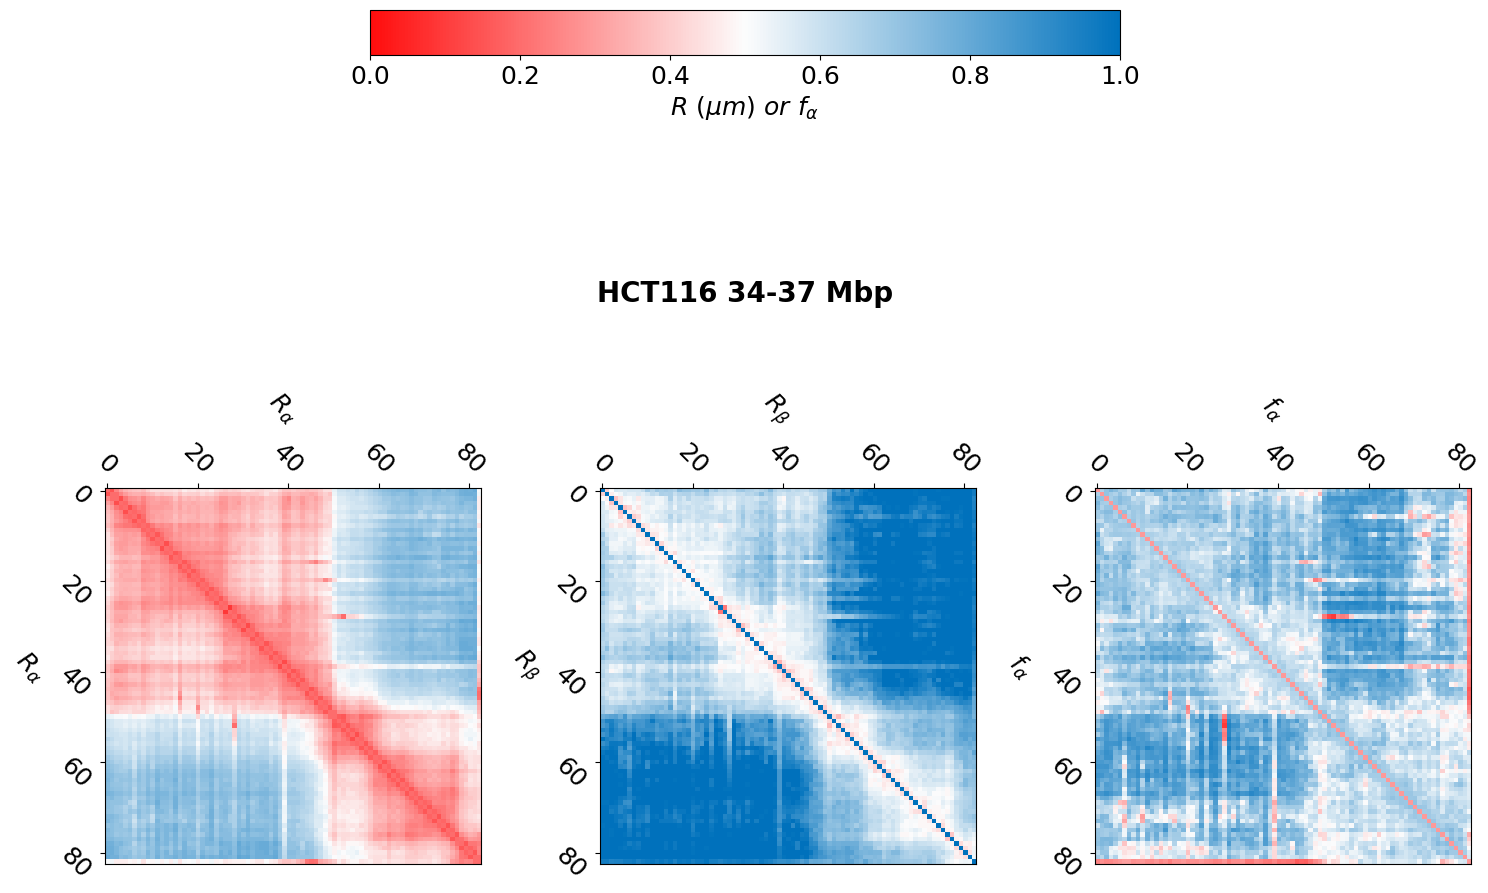

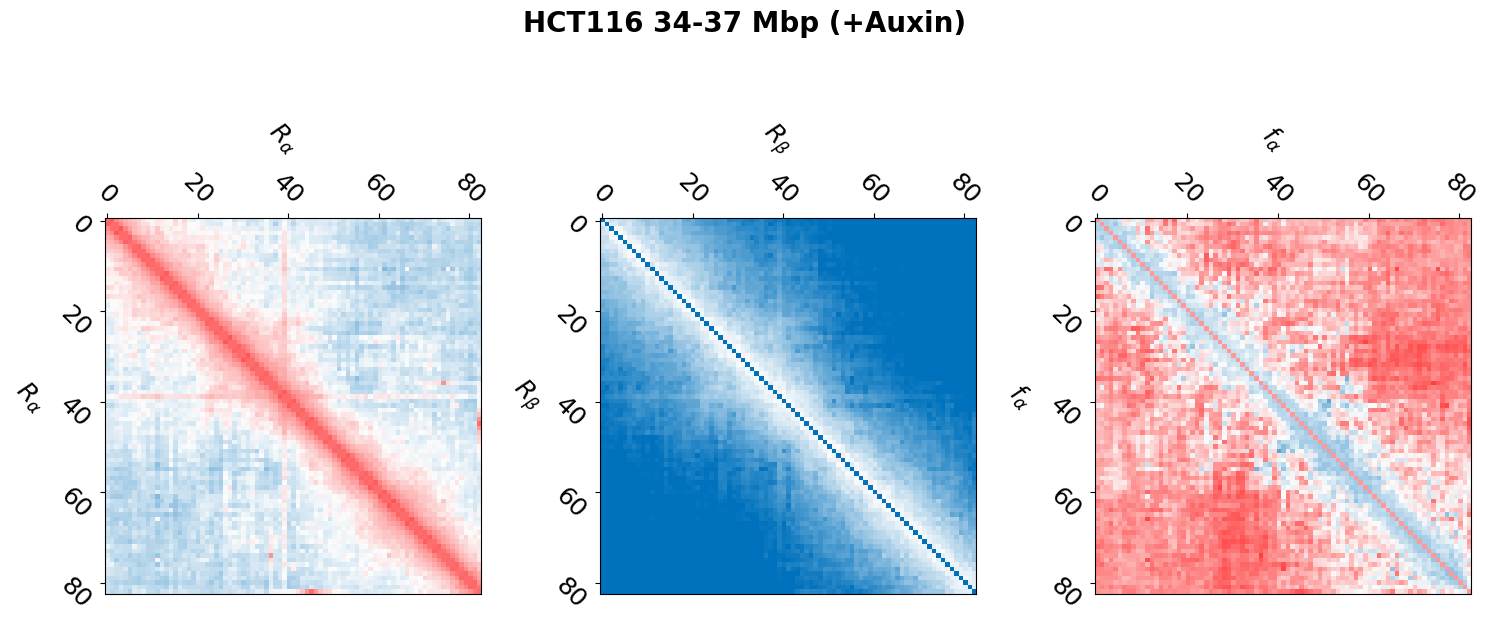

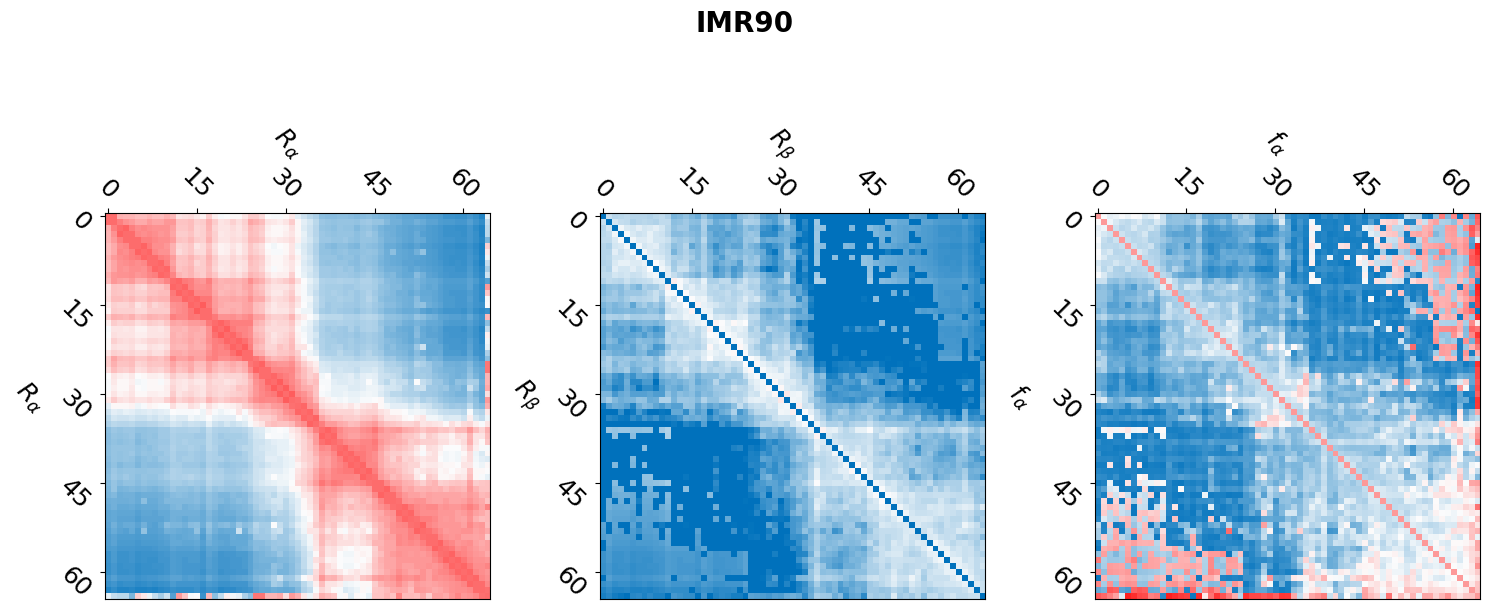

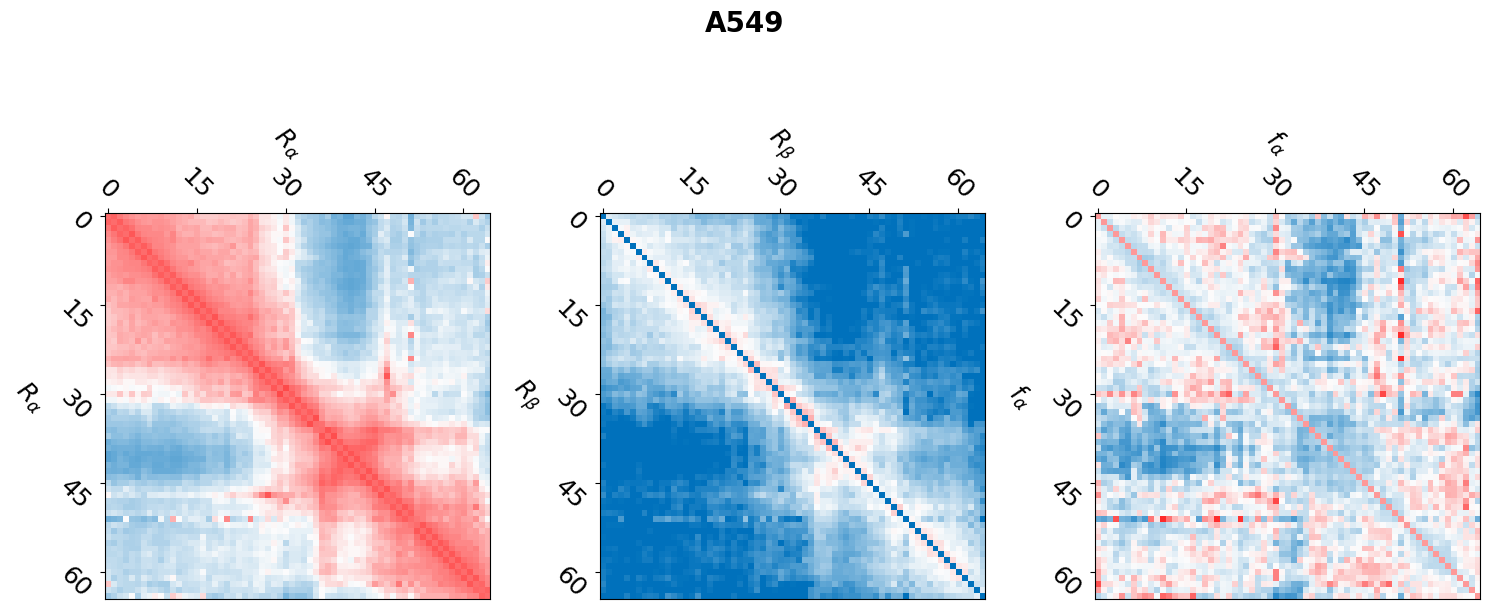

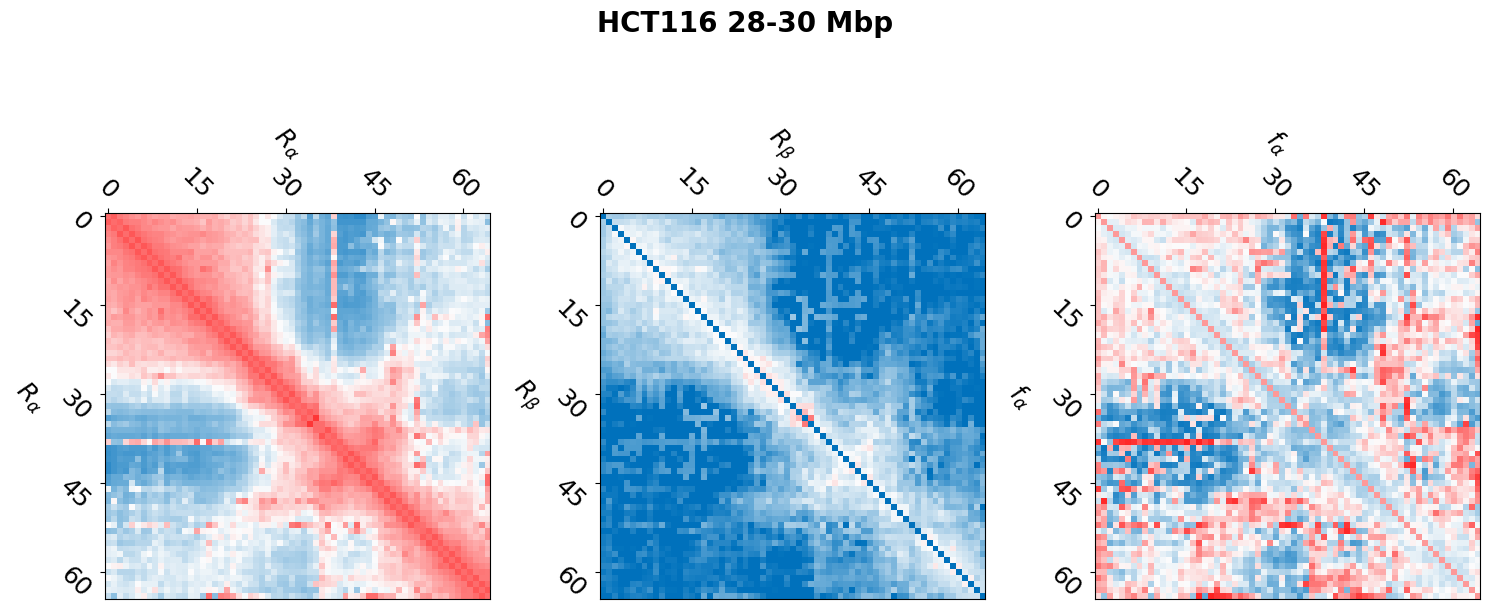

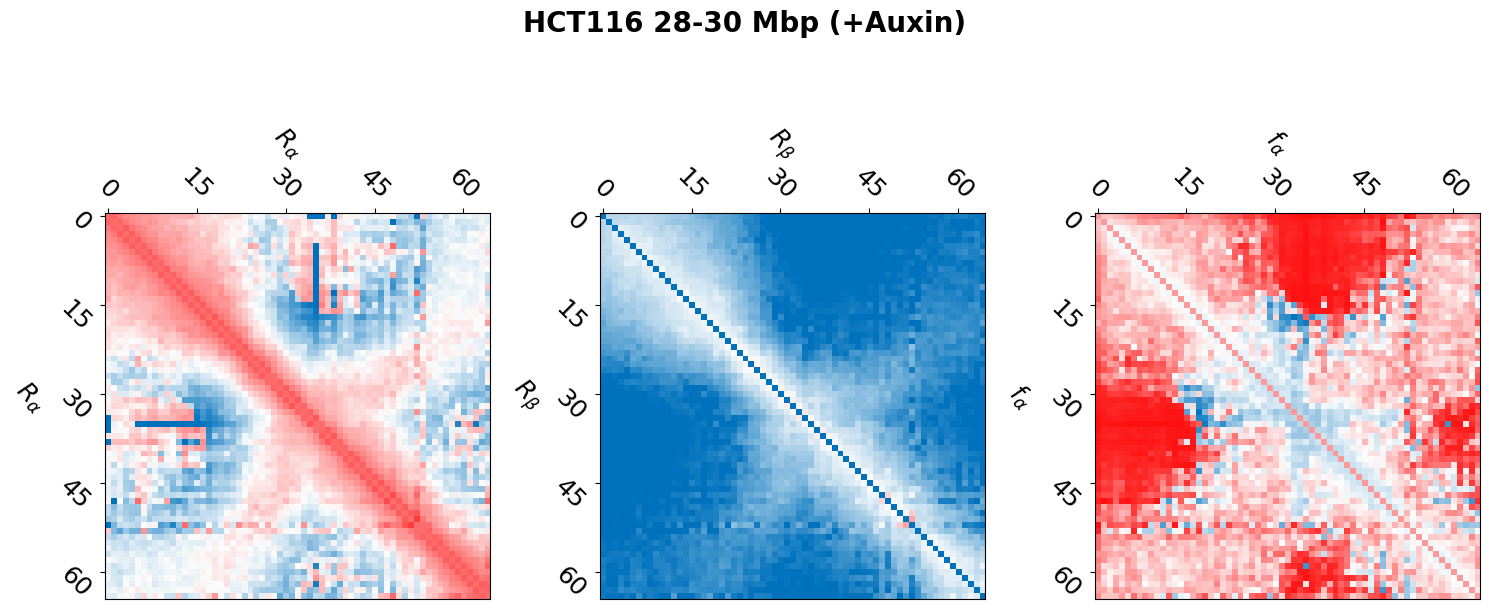

In [25]:
  # Define the color points for the custom colormap
colors = [(1, 0.05, 0.05), (0.99, 0.99, 0.99), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_colormap"
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
  
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90','A549','HCT116_UNTREATED_FILE_2','HCT116_AUXIN_FILE_2']):
    name = RESULTS[cell_line]['name']
    Re1_matrix = RESULTS[cell_line]['Re1_matrix'] 
    Re2_matrix = RESULTS[cell_line]['Re2_matrix'] 
    fr_matrix = RESULTS[cell_line]['fr_matrix'] 
   # Mask the matrices
    upper_triangle = np.triu(fr_matrix)
    upper_triangle[np.tril_indices_from(upper_triangle)] = np.nan

    lower_triangle = np.tril(1-fr_matrix)
    lower_triangle[np.triu_indices_from(lower_triangle)] = np.nan

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    fig.suptitle(f'{name}', y=0.75, fontsize=20, fontweight='bold')  # shared title for both subplots, adjusted position

    im1 = axs[0].imshow(Re1_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1.0)
    if cell_line in ['HCT116','HCT116_AUXIN'] :
        axs[0].yaxis.set_ticks([0, 20, 40, 60, 80])  # set y-axis ticks to specific locations
        axs[0].xaxis.set_ticks([0, 20, 40, 60, 80])
    else :
        axs[0].yaxis.set_ticks([0, 15, 30, 45, 60])  # set y-axis ticks to specific locations
        axs[0].xaxis.set_ticks([0, 15, 30, 45, 60])
    axs[0].yaxis.tick_left()  # move y axis ticks to right
    axs[0].xaxis.tick_top()  # ensure x axis ticks are at the bottom
    axs[0].set_xlabel(r"$R_{\alpha}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[0].set_ylabel(r"$R_{\alpha}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[0].tick_params(labelsize=18,labelrotation=-45)
    
    im2 = axs[1].imshow(Re2_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1.0)

    if cell_line in ['HCT116','HCT116_AUXIN'] :
        axs[1].yaxis.set_ticks([0, 20, 40, 60, 80])  # set y-axis ticks to specific locations
        axs[1].xaxis.set_ticks([0, 20, 40, 60, 80])  # set y-axis ticks to specific locations
    else :
        axs[1].yaxis.set_ticks([0, 15, 30, 45, 60])  # set y-axis ticks to specific locations
        axs[1].xaxis.set_ticks([0, 15, 30, 45, 60])  # set y-axis ticks to specific locations
    axs[1].yaxis.tick_left()  # move y axis ticks to right
    axs[1].xaxis.tick_top()  # ensure x axis ticks are at the bottom
    axs[1].set_xlabel(r"$R_{\beta}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[1].set_ylabel(r"$R_{\beta}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[1].tick_params(labelsize=18,labelrotation=-45)
    
    im3 = axs[2].imshow(fr_matrix, interpolation='nearest', cmap=custom_cmap, vmin=0, vmax=1)
    if cell_line in ['HCT116','HCT116_AUXIN'] :
        axs[2].yaxis.set_ticks([0, 20, 40, 60, 80])  # set y-axis ticks to specific locations
        axs[2].xaxis.set_ticks([0, 20, 40, 60, 80])  # set y-axis ticks to specific locations
    else :
        axs[2].yaxis.set_ticks([0, 15, 30, 45, 60])  # set y-axis ticks to specific locations
        axs[2].xaxis.set_ticks([0, 15, 30, 45, 60])  # set y-axis ticks to specific locations
    axs[2].yaxis.tick_left()  # move y axis ticks to right
    axs[2].xaxis.tick_top()  # ensure x axis ticks are at the bottom


    axs[2].set_xlabel(r"$f_{\alpha}$", labelpad=-335, fontsize=18, rotation=-45, rotation_mode='anchor')  # set x label at the top
    axs[2].set_ylabel(r"$f_{\alpha}$", labelpad=+25, fontsize=18, rotation=-45, rotation_mode='anchor')  # label for y axis on the left side
    axs[2].tick_params(labelsize=18,labelrotation=-45)

    
    # Add colorbar only for the first cell line
    if cl == 0:
        cax1 = fig.add_axes([0.25, 0.9, 0.5, 0.03])  # Create new axes at the top middle
        cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal')
        cbar1.set_label(r"$R\ (\mu m)\ or\ f_\alpha$", fontsize=18, rotation=-0)
        cbar1.ax.tick_params(labelsize=18, rotation=0)

    plt.tight_layout()
#     plt.subplots_adjust(top=0.85)
#     fig.savefig(cell_line+'_diagrams.pdf')
    plt.show()
  

## 3.4 Average $f_\alpha$ log plots vs the genomic distance (bp)

In [63]:
#  Here we calculate the average fraction of the alpha phase as a function of the pairwise genomic distance

# Filter out inf and NaN values from the data
def filter_invalid_values(x, y):
    valid_indices = np.isfinite(y)
    return x[valid_indices], y[valid_indices]
# Define the number of cell lines
cell_lines = ['HCT116', 'IMR90', 'HCT116_AUXIN','A549','HCT116_UNTREATED_FILE_2','HCT116_AUXIN_FILE_2','K562']

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']
    Rg_matrix = RESULTS[cell_line]['Rg_matrix']
    color = RESULTS[cell_line]['color']

    fr_matrix = RESULTS[cell_line]['fr_matrix']

    mean_values_fa = []
    std_values_fa = []
    
    mean_values_Ra = []
    std_values_Ra = []

    mean_values_Rb = []
    std_values_Rb = []

    mean_values_Rt = []
    std_values_Rt = []

    mean_values_Rg = []
    std_values_Rg = []

    x_range = range(1, Re1_matrix.shape[1] - 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    # Calculate the mean and std for each i and i + x pair for Ra and Rb
    for x in x_range:
        mean_Ra = np.mean([Re1_matrix[i, i + x] for i in range(Re1_matrix.shape[0] - x)])
        mean_Rb = np.mean([Re2_matrix[i, i + x] for i in range(Re2_matrix.shape[0] - x)])
        mean_Rt = np.mean([Rt_matrix[i, i + x] for i in range(Rt_matrix.shape[0] - x)])
        mean_Rg = np.mean([Rg_matrix[i, i + x] for i in range(Rg_matrix.shape[0] - x)])

        std_Ra = np.std([Re1_matrix[i, i + x] for i in range(Re1_matrix.shape[0] - x)])
        std_Rb = np.std([Re2_matrix[i, i + x] for i in range(Re2_matrix.shape[0] - x)])
        std_Rt = np.std([Rt_matrix[i, i + x] for i in range(Rt_matrix.shape[0] - x)])
        std_Rg = np.std([Rg_matrix[i, i + x] for i in range(Rg_matrix.shape[0] - x)])

        mean_values_Ra.append(mean_Ra)
        mean_values_Rb.append(mean_Rb)
        mean_values_Rt.append(mean_Rt)
        mean_values_Rg.append(mean_Rg)
        mean_values_fa.append(np.mean([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))

        std_values_Ra.append(std_Ra)
        std_values_Rb.append(std_Rb)
        std_values_Rt.append(std_Rt)
        std_values_Rg.append(std_Rg)
        std_values_fa.append(np.std([fr_matrix[i, i + x] for i in range(fr_matrix.shape[0] - x)]))

    mean_values_fa = np.array(mean_values_fa)
    std_values_fa = np.array(std_values_fa)

    f_lower = mean_values_fa - std_values_fa
    f_upper = mean_values_fa + std_values_fa

    fr_vs_distance = np.array([mean_values_fa, f_lower, f_upper])
    RESULTS[cell_line]['fr_vs_distance'] = fr_vs_distance

    mean_values_Ra = np.array(mean_values_Ra)
    std_values_Ra = np.array(std_values_Ra)

    mean_values_Rb = np.array(mean_values_Rb)
    std_values_Rb = np.array(std_values_Rb)

    mean_values_Rt = np.array(mean_values_Rt)
    std_values_Rt = np.array(std_values_Rt)

    mean_values_Rg = np.array(mean_values_Rg)
    std_values_Rg = np.array(std_values_Rg)

    Ra_lower = mean_values_Ra - std_values_Ra
    Ra_upper = mean_values_Ra + std_values_Ra

    Rb_lower = mean_values_Rb - std_values_Rb
    Rb_upper = mean_values_Rb + std_values_Rb

    Rt_lower = mean_values_Rt - std_values_Rt
    Rt_upper = mean_values_Rt + std_values_Rt

    Rg_lower = mean_values_Rg - std_values_Rg
    Rg_upper = mean_values_Rg + std_values_Rg

    Reconstructed_R = np.sqrt(mean_values_Ra**2 * mean_values_fa + mean_values_Rb**2 * (1 - mean_values_fa))

    # Define ss and n after mean_values_Ra and mean_values_Rb are calculated
    n = len(ss)  # Length of the data to fit

    # Filter the data to include only points where ss <= 5 * 10^5 for Ra
    max_ss_Ra = 2 * 10**5
    filtered_indices_Ra = ss <= max_ss_Ra

    ss_filtered_Ra = ss[filtered_indices_Ra]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices_Ra]

    # Filter the data to include only points where ss <= 2 * 10^5 for Rb
    max_ss_Rb = 2 * 10**5
    filtered_indices_Rb = ss <= max_ss_Rb

    ss_filtered_Rb = ss[filtered_indices_Rb]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices_Rb]
    



    # Fit the power function to the filtered data for Ra and Rb
    pa, pcov = curve_fit(power_function, ss_filtered_Ra, mean_values_Ra_filtered)
    pb, pcov = curve_fit(power_function, ss_filtered_Rb, mean_values_Rb_filtered)

    vu_T = [0, 0]
    vu_eff = [0, 0]
    vu_g = [0, 0]

    # Loop over the range of x values
    for x in range(2, len(mean_values_Rt)-5):
        # Filter the ss and mean_values_Rt data
        ss_filtered = ss[:x]
        mean_values_Rt_filtered = mean_values_Rt[:x]
        Reconstructed_R_filtered = Reconstructed_R[:x]
        mean_values_Rg_filtered = mean_values_Rg[:x]
        # Fit the power function to the filtered data
        try :
            pt, pcov = curve_fit(power_function, ss_filtered, mean_values_Rt_filtered)
            pg, pcov = curve_fit(power_function, ss_filtered, mean_values_Rg_filtered)
            peff, pcov = curve_fit(power_function, ss_filtered, Reconstructed_R_filtered)
        except :
            print('Error in fitting')

        # Append the fitted exponent to vu_T
        vu_T.append(pt[1])
        vu_g.append(pg[1])
        vu_eff.append(peff[1])

    # Store the results in the existing dictionary with keys ending in _vs_gd
    RESULTS[cell_line].update({
        'mean_values_fa_vs_gd': mean_values_fa,
        'std_values_fa_vs_gd': std_values_fa,
        'mean_values_Ra_vs_gd': mean_values_Ra,
        'std_values_Ra_vs_gd': std_values_Ra,
        'mean_values_Rb_vs_gd': mean_values_Rb,
        'std_values_Rb_vs_gd': std_values_Rb,
        'mean_values_Rt_vs_gd': mean_values_Rt,
        'std_values_Rt_vs_gd': std_values_Rt,
        'mean_values_Rg_vs_gd': mean_values_Rg,
        'std_values_Rg_vs_gd': std_values_Rg,
        'Ra_lower_vs_gd': Ra_lower,
        'Ra_upper_vs_gd': Ra_upper,
        'Rb_lower_vs_gd': Rb_lower,
        'Rb_upper_vs_gd': Rb_upper,
        'Rt_lower_vs_gd': Rt_lower,
        'Rt_upper_vs_gd': Rt_upper,
        'Rg_lower_vs_gd': Rg_lower,
        'Rg_upper_vs_gd': Rg_upper,
        'Reconstructed_R_vs_gd': Reconstructed_R,
        'vu_T_vs_gd': vu_T,
        'vu_eff_vs_gd': vu_eff,
        'vu_g_vs_gd': vu_g
    })

#     
    print(cell_line, ': done')

/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/4011930351.py:134: OptimizeWarning: Covariance of the parameters could not be estimated
  pt, pcov = curve_fit(power_function, ss_filtered, mean_values_Rt_filtered)
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/4011930351.py:135: OptimizeWarning: Covariance of the parameters could not be estimated
  pg, pcov = curve_fit(power_function, ss_filtered, mean_values_Rg_filtered)
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/4011930351.py:136: OptimizeWarning: Covariance of the parameters could not be estimated
  peff, pcov = curve_fit(power_function, ss_filtered, Reconstructed_R_filtered)


HCT116 : done
IMR90 : done
HCT116_AUXIN : done
A549 : done
HCT116_UNTREATED_FILE_2 : done
HCT116_AUXIN_FILE_2 : done


KeyError: 'K562'

In [64]:
plt.rcParams.update(plt.rcParamsDefault)
import scienceplots

# with plt.style.context(['science','no-latex']):
    
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex='col', sharey='row')


for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']
    mean_fa_vs_distance = RESULTS[cell_line]['mean_values_fa_vs_gd']
    std_fa_vs_gd = RESULTS[cell_line]['std_values_fa_vs_gd']
    

    f_lower = mean_fa_vs_distance - std_fa_vs_gd
    f_upper = mean_fa_vs_distance + std_fa_vs_gd
    
    x_range = range(1, len(mean_fa_vs_distance) + 1)
    

    
    # Plot the data
    ax = axs[cl % 2]
    ax.plot(np.array(x_range) * 30000, mean_fa_vs_distance, linewidth=2, color=color, label=name)
    ax.fill_between(np.array(x_range) * 30000, f_lower, f_upper, color=color, alpha=0.2)

    # Set the title for each subplot
    ax.legend(fontsize=18, loc='lower left')
    
    ax.set_xscale('log')

    # Set the ticks font size
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax.set_ylim(0, 1)

    if cl > 1:
        ax.set_xlabel(r"$s$ $(bp)$", fontsize=18)
        ax.set_xticks([100000, 1000000, 2500000])
    else:
        ax.set_xticks([])

    if cl == 0 or cl == 2:
        ax.set_ylabel(r"$f_{\alpha}$", fontsize=18, rotation=0, rotation_mode='anchor')
plt.style.use(['science'])
plt.tight_layout(pad=0.1)
# plt.savefig("f_mean_logscale.pdf")
plt.show()

KeyError: 'K562'

['HCT116', 'HCT116_AUXIN', 'IMR90', 'A549', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2']


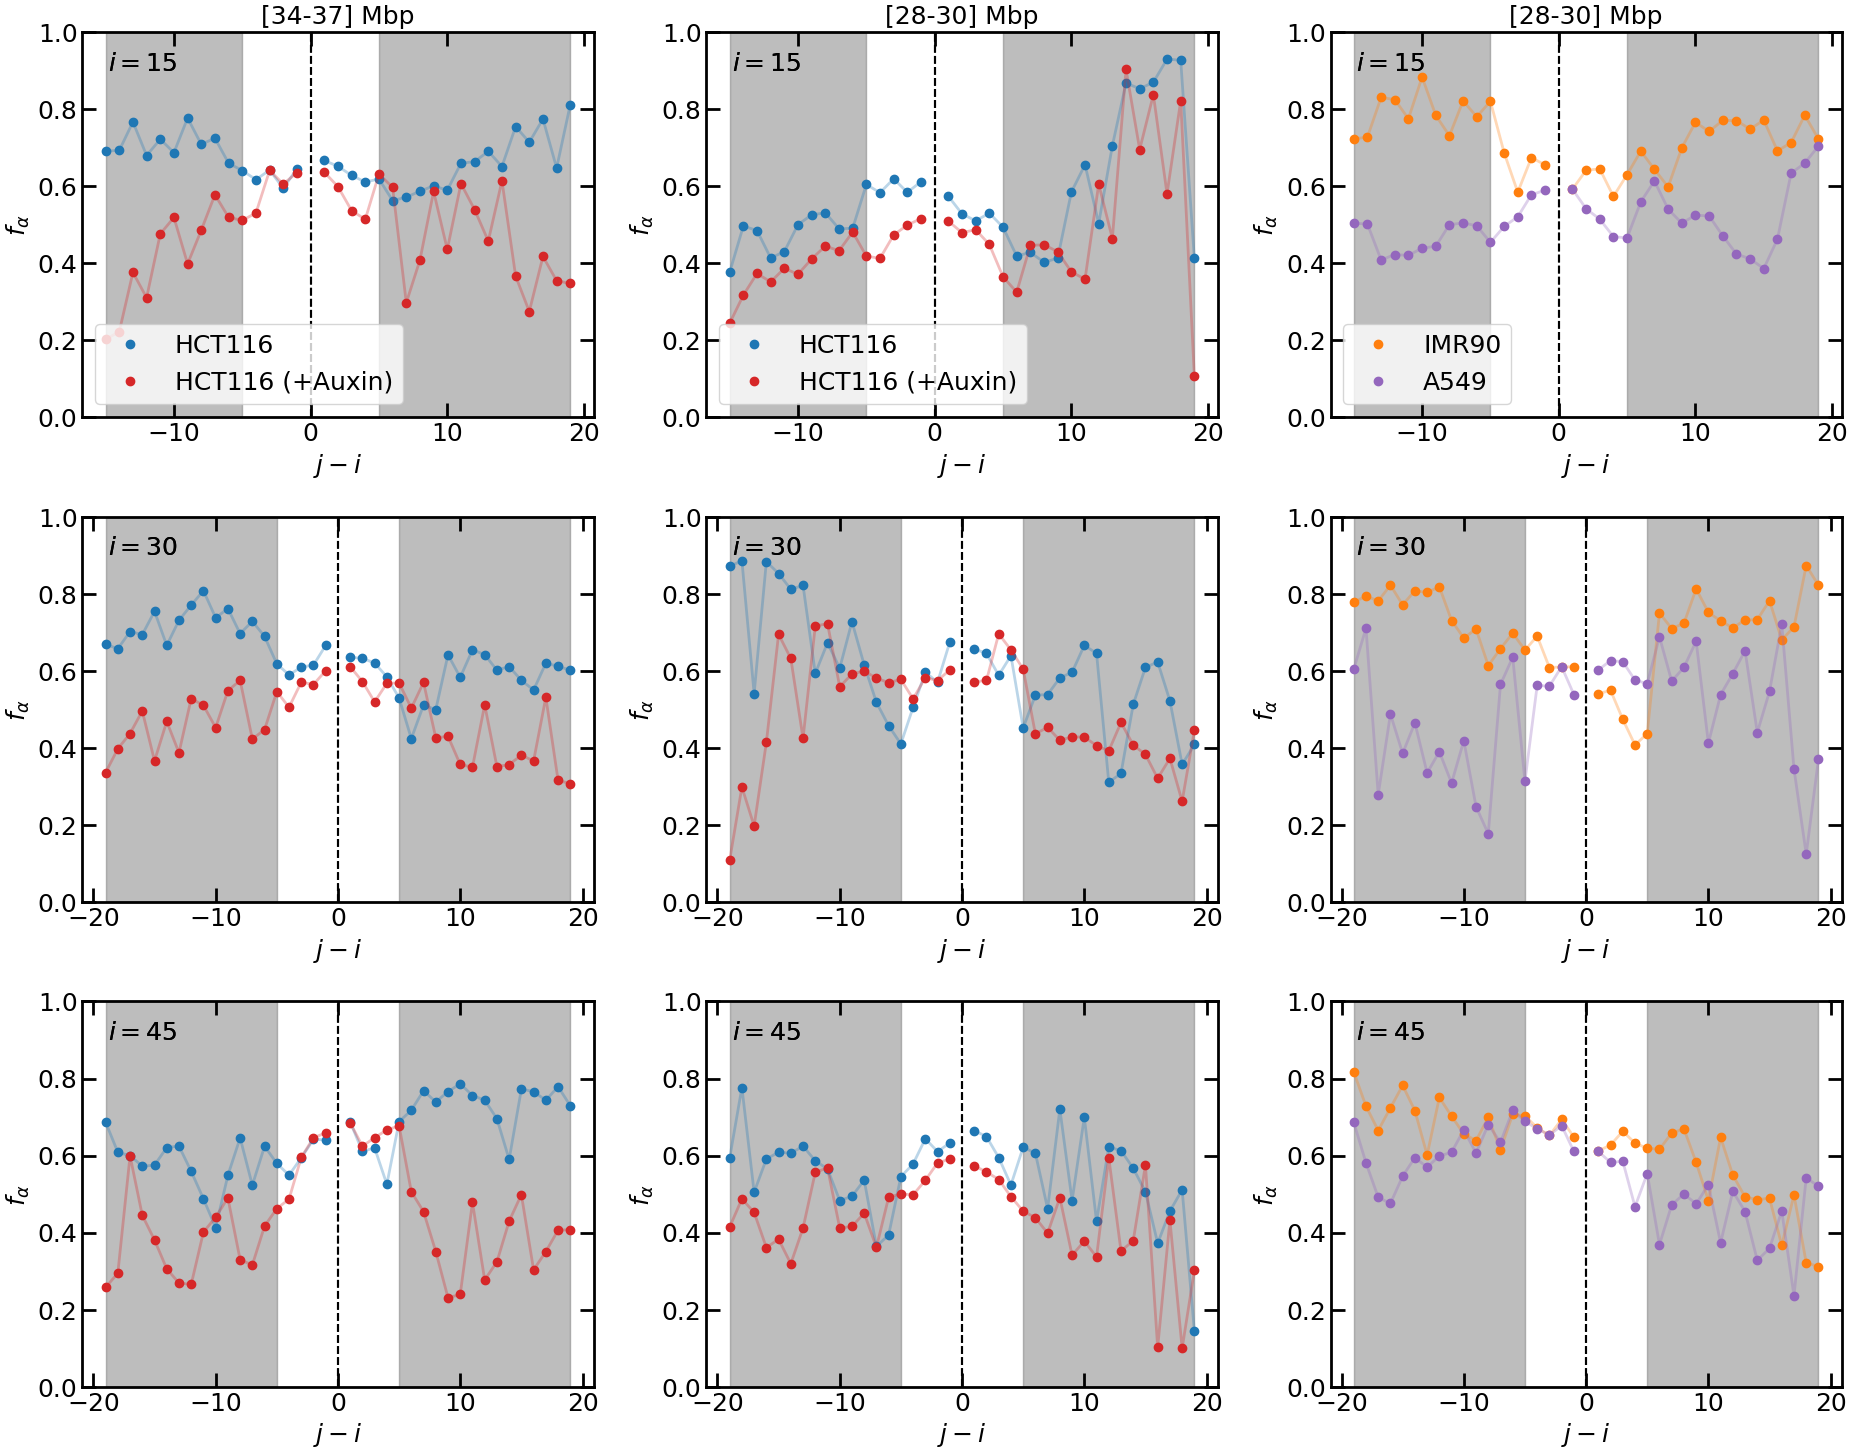

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

plt.rcParams.update(plt.rcParamsDefault)

fig, axs = plt.subplots(3, 3, figsize=(19, 15))

# Define the fixed tag values
fixed_i_values = [15, 30, 45]

# Sort cell lines by the size of mean_fa_vs_distance
# cell_lines_sorted = sorted(cell_lines, key=lambda cl: len(RESULTS[cl]['fr_matrix']), reverse=True)
cell_line_sorted = ['HCT116', 'HCT116_AUXIN', 'IMR90', 'A549', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2']
print(cell_line_sorted)

for row, fixed_i in enumerate(fixed_i_values):
    for cl, cell_line in enumerate(cell_line_sorted):
        name = RESULTS[cell_line]['name']
        color = RESULTS[cell_line]['color']

        # Ensure mean_values_fa_vs_gd and std_values_fa_vs_gd are 2D arrays
        mean_values_fa_vs_gd = RESULTS[cell_line]['fr_matrix']
        std_values_fa_vs_gd = RESULTS

        mean_fa_vs_distance = mean_values_fa_vs_gd[fixed_i, :]  # Select the row i

        x_range = np.arange(len(mean_fa_vs_distance)) - fixed_i

        # Filter the data to exclude the point at i=j and only show -20 < j-i < 20
        mask = (x_range != 0) & (x_range > -20) & (x_range < 20)
        x_range = x_range[mask]
        mean_fa_vs_distance = mean_fa_vs_distance[mask]

        # Determine the subplot based on the sample name
        if 'HCT116 34-37 Mbp' in name:
            ax = axs[row, 0]
            title = '[34-37] Mbp'
        elif 'HCT116 28-30 Mbp' in name:
            ax = axs[row, 1]
            title = '[28-30] Mbp'
        else:
            ax = axs[row, 2]
            title = '[28-30] Mbp'

        # Plot the data
        if name == 'HCT116 34-37 Mbp' or name == 'HCT116 28-30 Mbp':
            name = 'HCT116'
        if name == 'HCT116 34-37 Mbp (+Auxin)' or name == 'HCT116 28-30 Mbp (+Auxin)':
            name = 'HCT116 (+Auxin)'
        cell_line_names = ['HCT116 Untreated', 'HCT116 Auxin', 'IMR90', 'K562', 'A549']
        ax.plot(x_range, mean_fa_vs_distance, 'o', color=color, label=name)
        ax.plot(x_range[x_range < 0], mean_fa_vs_distance[x_range < 0], color=color, linewidth=2, alpha=0.3)
        ax.plot(x_range[x_range > 0], mean_fa_vs_distance[x_range > 0], color=color, linewidth=2, alpha=0.3)



        ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        # Add a vertical black line at the 0 position
        ax.axvline(x=0, color='black', linestyle='--')
        # Add transparent gray area for j-i > 5 or j-i < -5
        # ax.fill_between(x_range, 0, 1, where=(x_range > 5) | (x_range < -5), color='gray', alpha=0.3)
        ax.axvspan(x_range.min(), -5, color='gray', alpha=0.3)
        ax.axvspan(5, x_range.max(), color='gray', alpha=0.3)
        # Add a text label in LaTeX format with the value of i
        ax.text(0.05, 0.95, f'$i={fixed_i}$', transform=ax.transAxes, fontsize=18, verticalalignment='top')

        # Set the title for each subplot
        if row == 0:
            ax.legend(fontsize=18, loc='lower left')
            ax.set_title(title, fontsize=18)
        # Set the ticks font size
        ax.tick_params(axis='both', which='both', labelsize=18)
        ax.set_ylim(0, 1)

        ax.set_xlabel(r"$j - i$", fontsize=18)
        ax.set_ylabel(r"$f_{\alpha}$", fontsize=18)

plt.style.use(['science'])
plt.tight_layout(pad=2.0)  # Increase the padding
plt.savefig("f_i.pdf")
plt.show()

A =  0.007638458127810441 B =  0.09769152828342188 B/A =  12.789430360001868
A =  0.0037357279743360527 B =  0.10430308363588021 B/A =  27.920417212502713
A =  0.0054821554191165954 B =  0.11145868502367433 B/A =  20.3311793450823
A =  0.0017769727065728067 B =  0.07372870229630701 B/A =  41.49118443046057


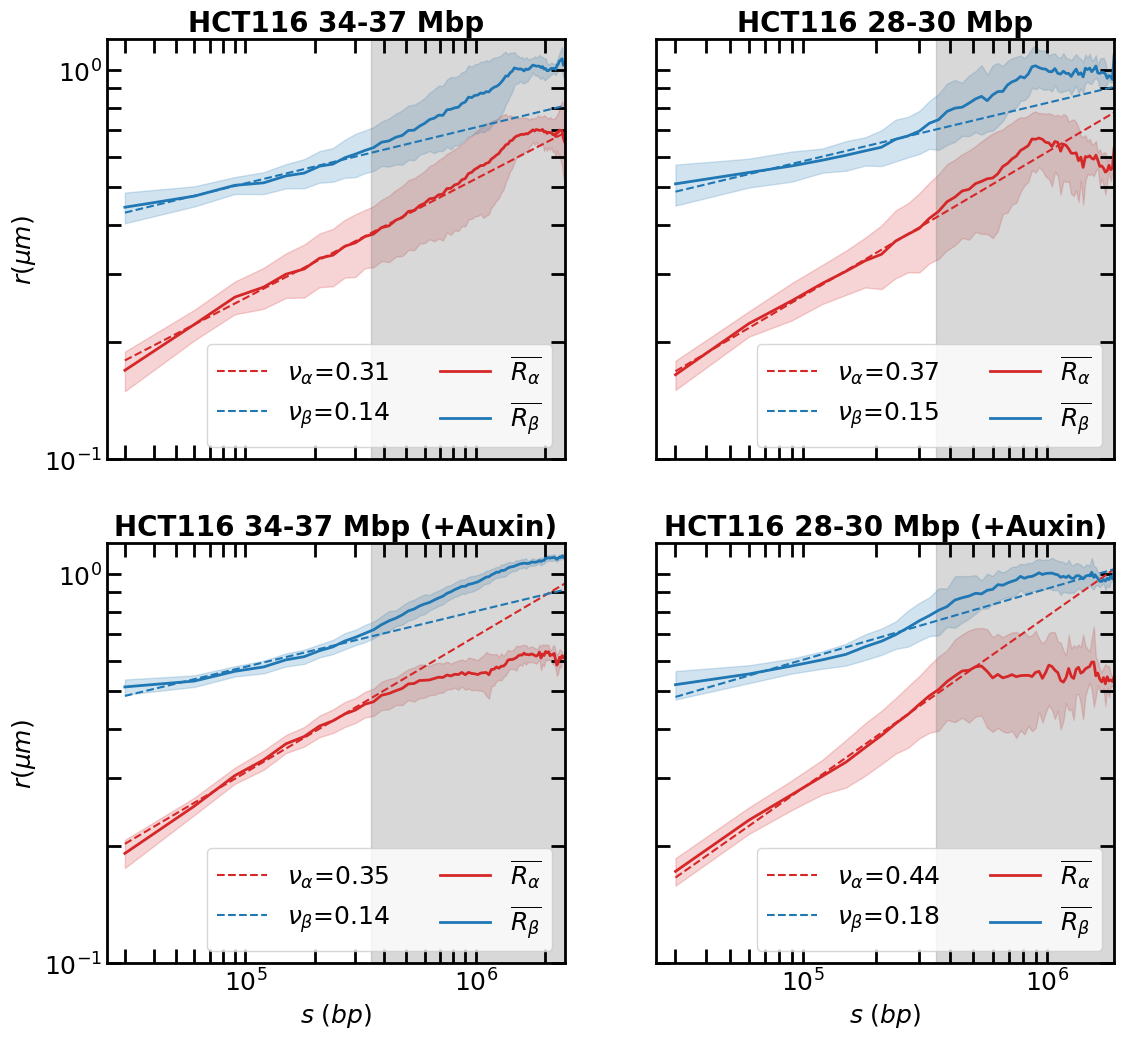

In [75]:
# default matplotlib style
plt.rcParams.update(plt.rcParamsDefault)


# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['HCT116', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN', 'HCT116_AUXIN_FILE_2']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 2, figsize=(13, 12), sharex='col', sharey='row')
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=2, color=RESULTS['HCT116_AUXIN']['color'], label=r'$\overline{R_{\alpha}}$')
    ax.fill_between(ss, Ra_lower, Ra_upper, color=RESULTS['HCT116_AUXIN']['color'], alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=2, color=RESULTS['HCT116']['color'], label=r'$\overline{R_{\beta}}$')
    ax.fill_between(ss, Rb_lower, Rb_upper, color=RESULTS['HCT116']['color'], alpha=0.2)

    # Plot Rt
    # ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
    # ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 1.2)
    ax.set_xlim(25000, ss.max())
    ax.legend(ncol=2, fontsize=18, loc='lower right')

    if cl in [0, 2]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5, 1])
        ax.set_yticklabels([r'$0.1$', r'$0.5$', r'$1.0$'])
    if cl >= 2:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([100000, 1000000])
        ax.set_xticklabels([r'$10^5$', r'$10^6$'])

    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

    ax.set_title(name, fontsize=20, fontweight='bold')

# plt.savefig("R_mean_vs_s_logscale_old.pdf")
plt.show()

A =  0.009831991773049387 B =  0.13686817967428402 B/A =  13.92069713173025
A =  0.0037357279743360527 B =  0.10430308363588021 B/A =  27.920417212502713
A =  0.006188454542992259 B =  0.08280907948456388 B/A =  13.381221257953008
A =  0.0017769727065728067 B =  0.07372870229630701 B/A =  41.49118443046057


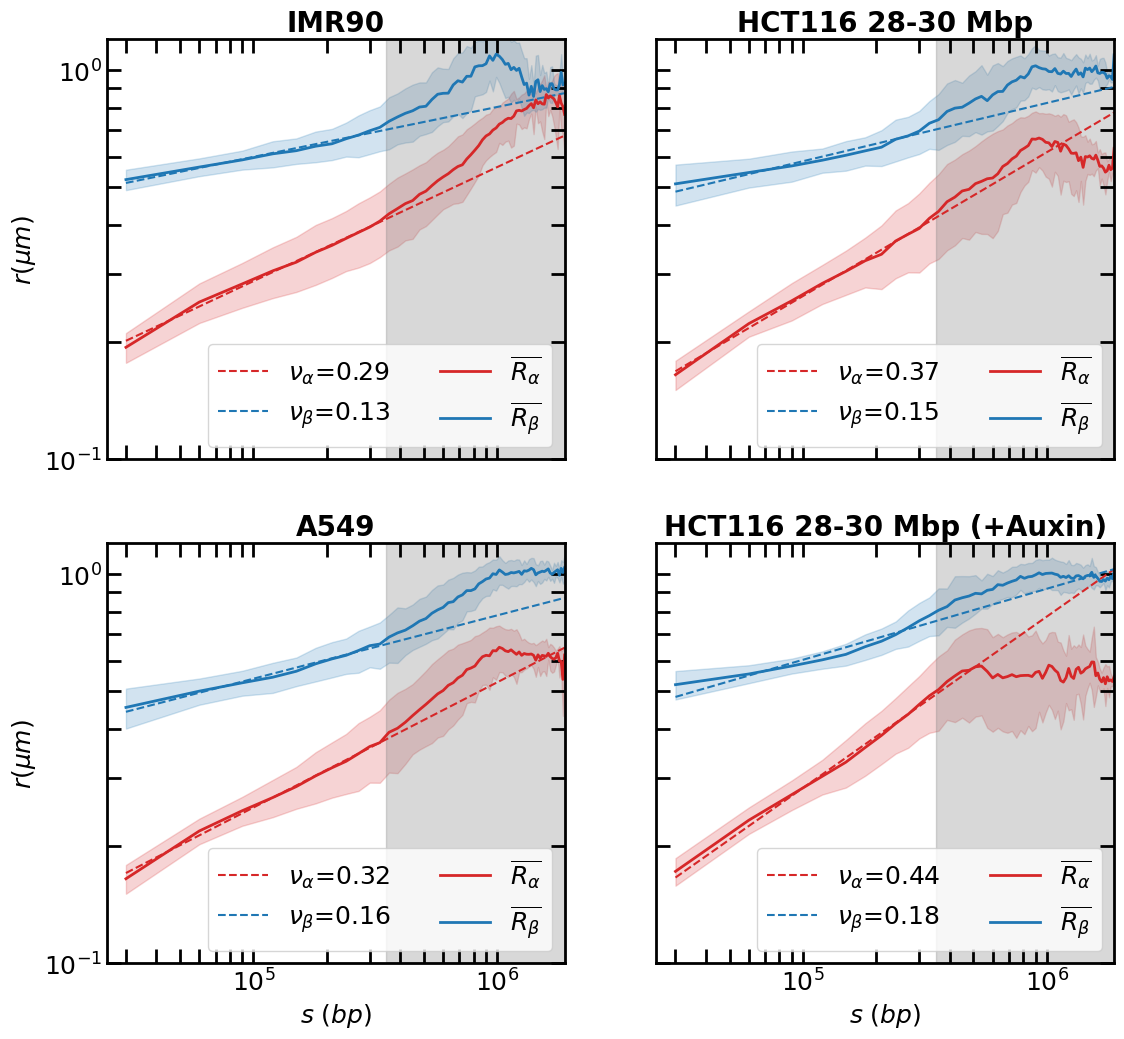

In [67]:


from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['IMR90', 'HCT116_UNTREATED_FILE_2', 'A549', 'HCT116_AUXIN_FILE_2']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 2, figsize=(13, 12), sharex='col', sharey='row')
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=2, color=RESULTS['HCT116_AUXIN']['color'], label=r'$\overline{R_{\alpha}}$')
    ax.fill_between(ss, Ra_lower, Ra_upper, color=RESULTS['HCT116_AUXIN']['color'], alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=2, color=RESULTS['HCT116']['color'], label=r'$\overline{R_{\beta}}$')
    ax.fill_between(ss, Rb_lower, Rb_upper, color=RESULTS['HCT116']['color'], alpha=0.2)

    # Plot Rt
    # ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
    # ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 1.2)
    ax.set_xlim(25000, ss.max())
    ax.legend(ncol=2, fontsize=18, loc='lower right')

    if cl in [0, 2]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5, 1])
        ax.set_yticklabels([r'$0.1$', r'$0.5$', r'$1.0$'])
    if cl >= 2:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([100000, 1000000])
        ax.set_xticklabels([r'$10^5$', r'$10^6$'])

    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

    ax.set_title(name, fontsize=20, fontweight='bold')

# plt.savefig("R_mean_vs_s_logscale_old_2.pdf")
plt.show()

A =  0.010026204610403449 B =  0.14508540775231554 B/A =  14.470621076471069
A =  0.004053801464589698 B =  0.11929564809931407 B/A =  29.428093393663143
A =  0.007570892360360317 B =  0.10418017445902188 B/A =  13.760620214928494
A =  0.006179298689866712 B =  0.08544907008626236 B/A =  13.828279611469227
A =  0.001964063086977851 B =  0.08454833170550992 B/A =  43.04766596657869
A =  0.005183866392447159 B =  0.12044838145590692 B/A =  23.23524032783696


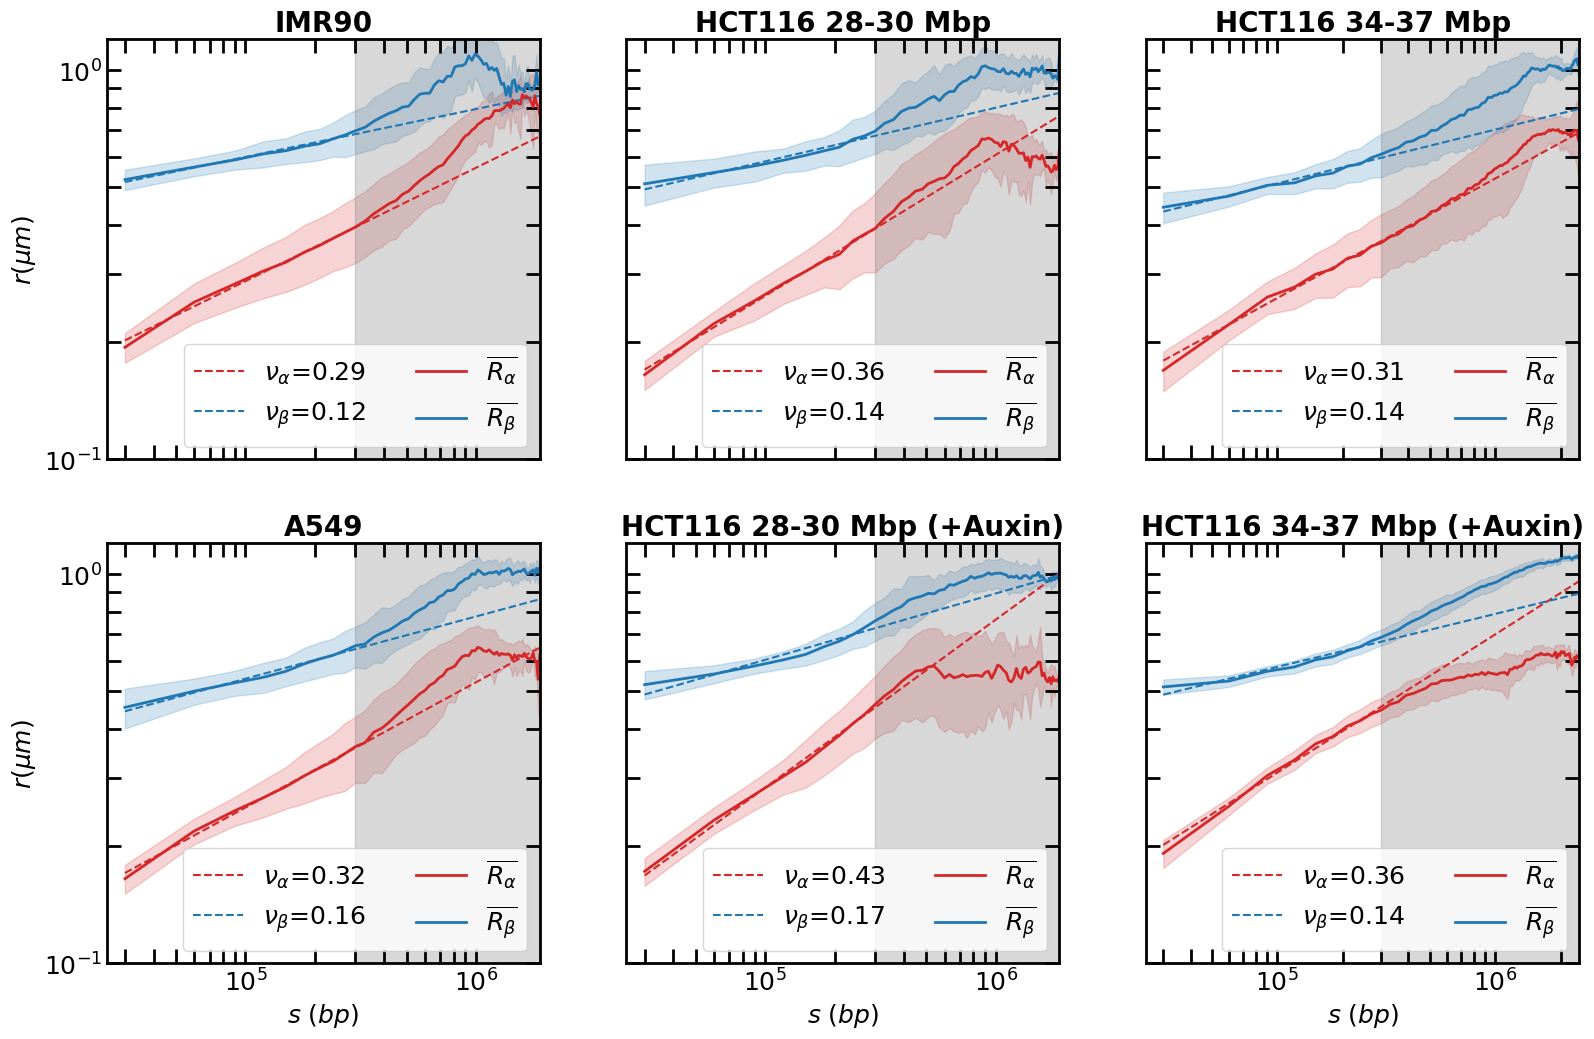

In [31]:
import textwrap

# ALLL SAMPLES

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# from matplotlib.lines import Line2D
# from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['IMR90', 'HCT116_UNTREATED_FILE_2','HCT116', 'A549', 'HCT116_AUXIN_FILE_2','HCT116_AUXIN']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 3, figsize=(19, 12), sharex='col', sharey='row')
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3 * 10**5
    filtered_indices = ss <= max_ss
    
    

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]
    
    ss_filtered, mean_values_Ra_filtered = filter_invalid_values(ss_filtered, mean_values_Ra_filtered)
    ss_filtered, mean_values_Rb_filtered = filter_invalid_values(ss_filtered, mean_values_Rb_filtered)
    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=2, color=RESULTS['HCT116_AUXIN']['color'], label=r'$\overline{R_{\alpha}}$')
    ax.fill_between(ss, Ra_lower, Ra_upper, color=RESULTS['HCT116_AUXIN']['color'], alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=2, color=RESULTS['HCT116']['color'], label=r'$\overline{R_{\beta}}$')
    ax.fill_between(ss, Rb_lower, Rb_upper, color=RESULTS['HCT116']['color'], alpha=0.2)

    # Plot Rt
    # ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
    # ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 1.2)
    ax.set_xlim(25000, ss.max())
    ax.legend(ncol=2, fontsize=18, loc='lower right')

    if cl in [0, 3]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5, 1])
        ax.set_yticklabels([r'$0.1$', r'$0.5$', r'$1.0$'])
    if cl >= 3:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([100000, 1000000])
        ax.set_xticklabels([r'$10^5$', r'$10^6$'])

    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

    ax.set_title(name, fontsize=20, fontweight='bold')

# plt.savefig("R_mean_vs_s_logscale_old_all_bintu.pdf")
plt.show()

A =  0.010026204610403449 B =  0.14508540775231554 B/A =  14.470621076471069
A =  0.004053801464589698 B =  0.11929564809931407 B/A =  29.428093393663143
A =  0.007570892360360317 B =  0.10418017445902188 B/A =  13.760620214928494
A =  0.006179298689866712 B =  0.08544907008626236 B/A =  13.828279611469227
A =  0.0030181308820611532 B =  0.1631658338071103 B/A =  54.06188140379137
A =  0.0031187882821738268 B =  0.17943876996780608 B/A =  57.534771113971054


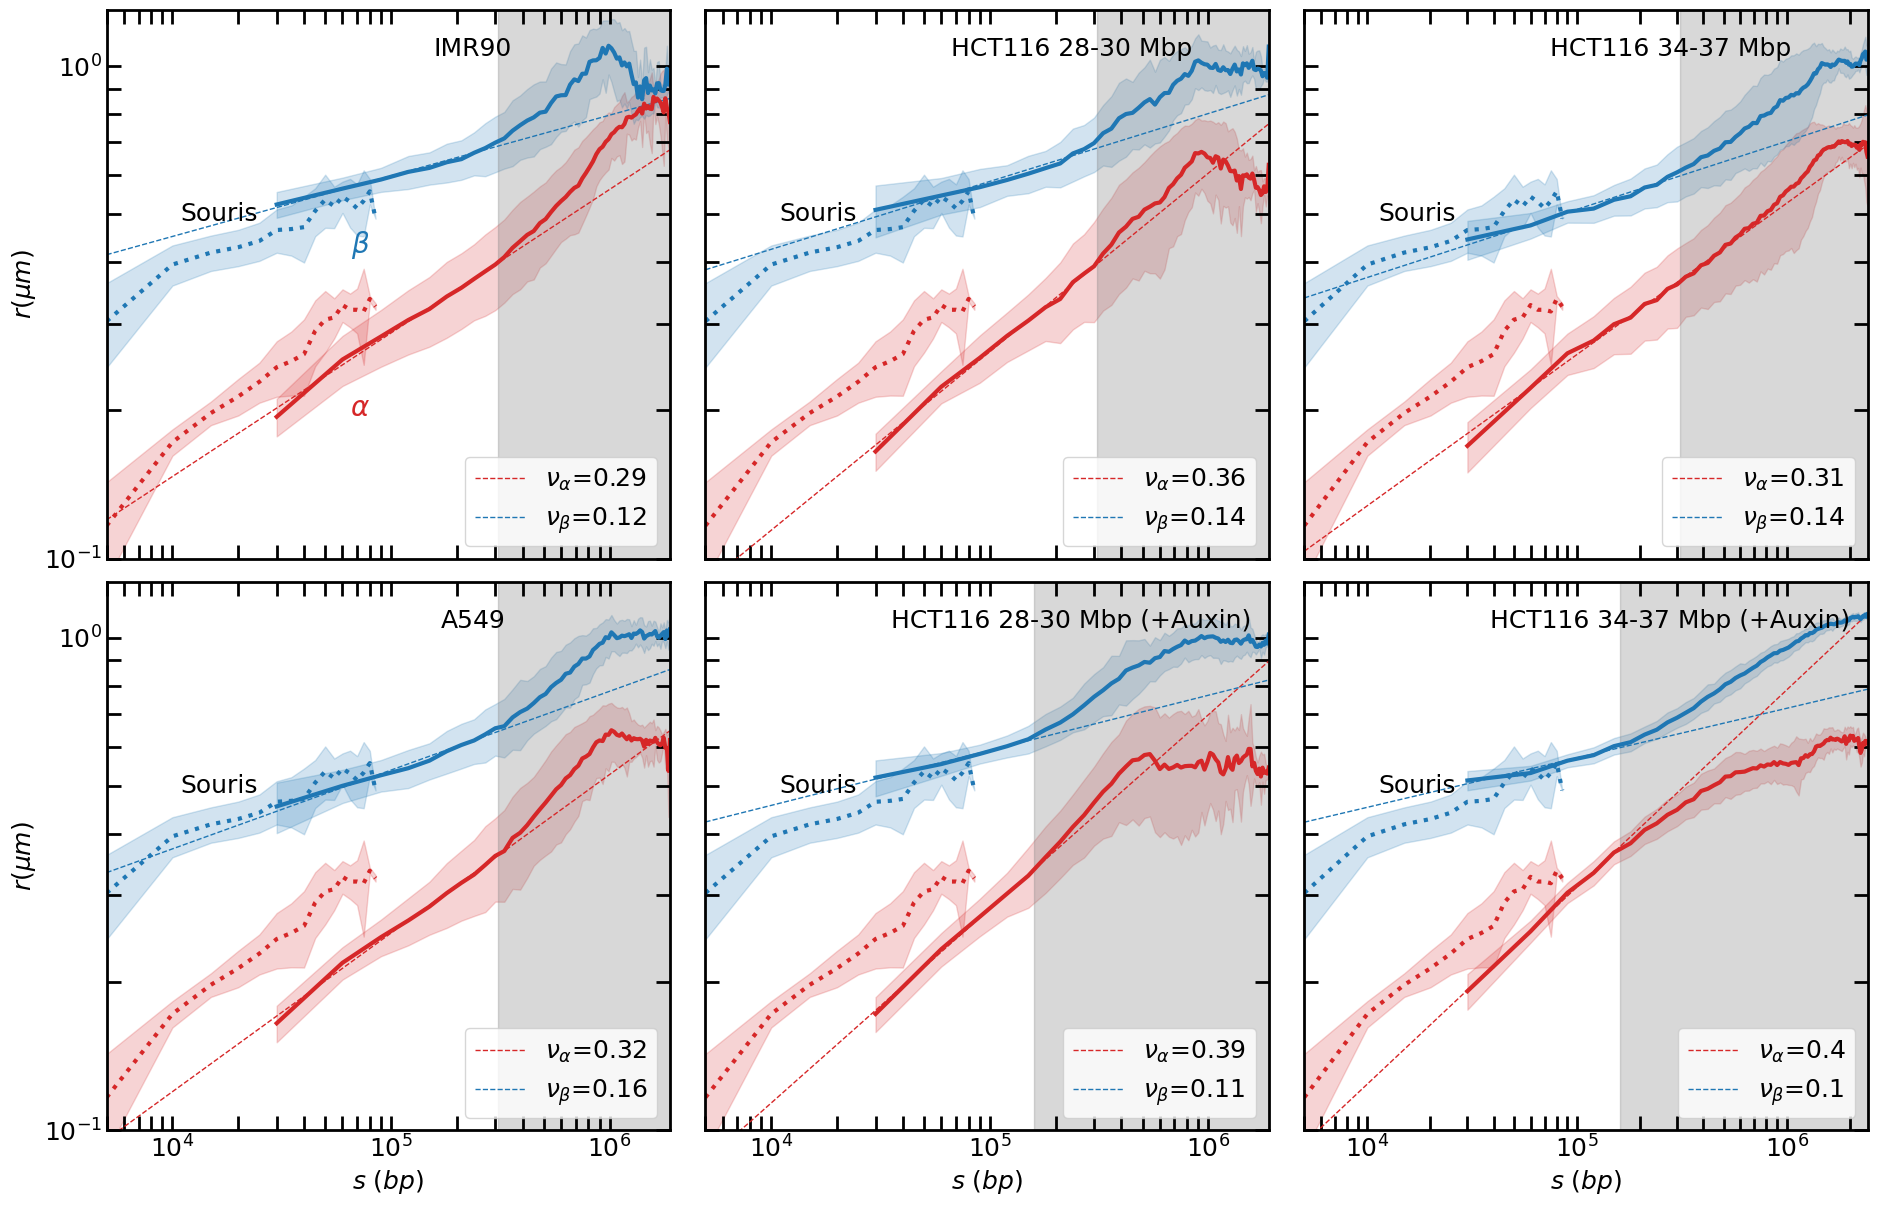

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['IMR90', 'HCT116_UNTREATED_FILE_2', 'HCT116', 'A549', 'HCT116_AUXIN_FILE_2', 'HCT116_AUXIN']

# Load mouse data from 'filtered_data.txt'
mouse_data = np.loadtxt('filtered_data.txt', delimiter=',', skiprows=1)
ss_mouse = mouse_data[:, 0]
mean_values_Ra_mouse = mouse_data[:, 1]
mean_values_Rb_mouse = mouse_data[:, 2]
std_values_Ra_mouse = mouse_data[:, 3]
std_values_Rb_mouse = mouse_data[:, 4]

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 3, figsize=(19, 12), sharex='col', sharey='row')
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    if cell_line in ['HCT116_AUXIN_FILE_2', 'HCT116_AUXIN']:
        
        max_ss = 1.6 * 10**5
        filtered_indices = ss <= max_ss
    else:
        max_ss = 3.1 * 10**5
        filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    ss_filtered, mean_values_Ra_filtered = filter_invalid_values(ss_filtered, mean_values_Ra_filtered)
    ss_filtered, mean_values_Rb_filtered = filter_invalid_values(ss_filtered, mean_values_Rb_filtered)
    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)
    
    new_ss = np.logspace(np.log10(np.min(ss_mouse)), np.log10(np.max(ss)), num=100)

    # Plot the data
    ax = axs[cl]
    ax.loglog(new_ss, power_function(new_ss, *pa), c='tab:red', linestyle='--', lw=1,label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(new_ss, power_function(new_ss, *pb), c='tab:blue', linestyle='--',lw=1, label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=3, color=RESULTS['HCT116_AUXIN']['color'])
    ax.fill_between(ss, Ra_lower, Ra_upper, color=RESULTS['HCT116_AUXIN']['color'], alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=3, color=RESULTS['HCT116']['color'])
    ax.fill_between(ss, Rb_lower, Rb_upper, color=RESULTS['HCT116']['color'], alpha=0.2)

    # Plot mouse data
    ax.loglog(ss_mouse, mean_values_Ra_mouse, ':',lw=3, color='tab:red')
    ax.fill_between(ss_mouse, mean_values_Ra_mouse - std_values_Ra_mouse, mean_values_Ra_mouse + std_values_Ra_mouse, color='tab:red', alpha=0.2)
    ax.loglog(ss_mouse, mean_values_Rb_mouse, ':',lw=3, color='tab:blue')
    ax.fill_between(ss_mouse, mean_values_Rb_mouse - std_values_Rb_mouse, mean_values_Rb_mouse + std_values_Rb_mouse, color='tab:blue', alpha=0.2)

    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 1.3)
    ax.set_xlim(5000, ss.max())
    ax.legend(ncol=1, fontsize=18, loc='lower right')

    if cl in [0, 3]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5, 1])
        ax.set_yticklabels([r'$0.1$', r'$0.5$', r'$1.0$'])
    if cl >= 3:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([10000,100000, 1000000])
        ax.set_xticklabels([r'$10^4$',r'$10^5$', r'$10^6$'])

    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

    # Place the title inside the panel
    ax.text(0.65, 0.95, name, transform=ax.transAxes, fontsize=18,  ha='center', va='top')
    ax.text(0.2, 0.65,  "Souris", transform=ax.transAxes, fontsize=18,  ha='center', va='top')
    if cl == 0:
        ax.text(0.45, 0.3,r"$\alpha$",color='tab:red', transform=ax.transAxes, fontsize=20,  ha='center', va='top')
        ax.text(0.45, 0.6,r"$\beta$",color='tab:blue', transform=ax.transAxes, fontsize=20,  ha='center', va='top')
    
# Define legend labels and handles
legend_labels = [
    r'$\overline{R_{\alpha}}$',
    r'$\overline{R_{\beta}}$',
    r'$\overline{R_{\alpha}}$ (Mouse cells)',
    r'$\overline{R_{\beta}}$ (Mouse cells)'
]

handles = [Line2D([0], [0], linestyle='-', lw=3,  color='tab:red',label=legend_labels[0]),
           Line2D([0], [0], linestyle='-', lw=3,   color='tab:blue',label=legend_labels[1]),
           Line2D([0], [0], linestyle=':', lw=3,  color='tab:red', label=legend_labels[2]),
           Line2D([0], [0], linestyle=':', lw=3,  color='tab:blue', label=legend_labels[3])]

# fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=20)

plt.tight_layout(pad=0.5)
plt.savefig("Radii_vs_mouse.pdf", bbox_inches='tight')
plt.show()

A =  0.006188454542992259 B =  0.08280907948456388 B/A =  13.381221257953008


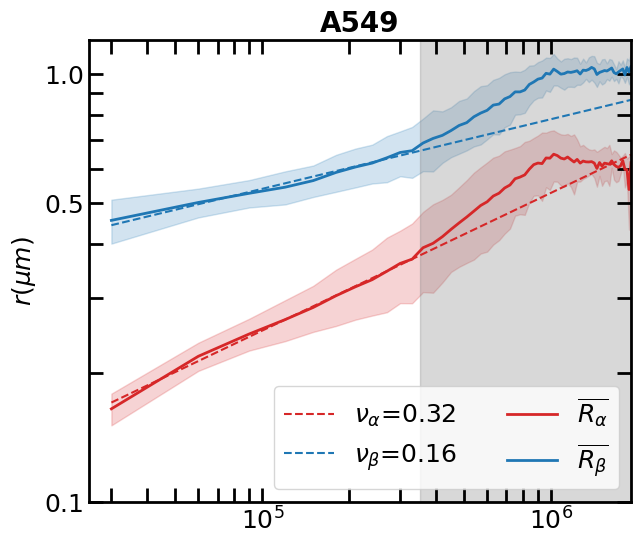

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the color points for the custom colormap
f_colors = [(1, 0.05, 0.05), (0, 0.4470, 0.7410)]

# Create a custom colormap with the adjusted colors
n_bins = 256
cmap_name = "custom_f_colormap"
custom_cmap_f = LinearSegmentedColormap.from_list(cmap_name, f_colors, N=n_bins)

# Define the number of cell lines
cell_lines = ['A549']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(figsize=(7, 6))

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    fr_vs_distance = RESULTS[cell_line]['fr_vs_distance']
    mean_values_fa = fr_vs_distance[0]
    f_lower = fr_vs_distance[1]
    f_upper = fr_vs_distance[2]

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    print('A = ', pa[0], 'B = ', pb[0], 'B/A = ', pb[0] / pa[0])

    # Plot Ra
    ax.loglog(ss, mean_values_Ra, linewidth=2, color=RESULTS['HCT116_AUXIN']['color'], label=r'$\overline{R_{\alpha}}$')
    ax.fill_between(ss, Ra_lower, Ra_upper, color=RESULTS['HCT116_AUXIN']['color'], alpha=0.2)

    # Plot Rb
    ax.loglog(ss, mean_values_Rb, linewidth=2, color=RESULTS['HCT116']['color'], label=r'$\overline{R_{\beta}}$')
    ax.fill_between(ss, Rb_lower, Rb_upper, color=RESULTS['HCT116']['color'], alpha=0.2)

    # Plot Rt
    # ax.loglog(ss, mean_values_Rt, linewidth=2, color='k')
    # ax.fill_between(ss, Rt_lower, Rt_upper, color='k', alpha=0.2)
    ax.tick_params(axis='both', which='both', labelsize=18, direction='in', top=True, right=True, length=10, width=2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xscale('log')
    ax.set_ylim(0.1, 1.2)
    ax.set_xlim(25000, ss.max())
    ax.legend(ncol=2, fontsize=18, loc='lower right')

    if cl in [0, 3]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
        ax.set_yticks([0.1, 0.5, 1])
        ax.set_yticklabels([r'$0.1$', r'$0.5$', r'$1.0$'])
    if cl >= 3:
        ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax.set_xticks([100000, 1000000])
        ax.set_xticklabels([r'$10^5$', r'$10^6$'])

    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

    ax.set_title(name, fontsize=20, fontweight='bold')

# plt.savefig("R_mean_vs_s_logscale_one.pdf")
plt.show()

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/134549899.py:82: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f'$r(\mu m)$', fontsize=18)


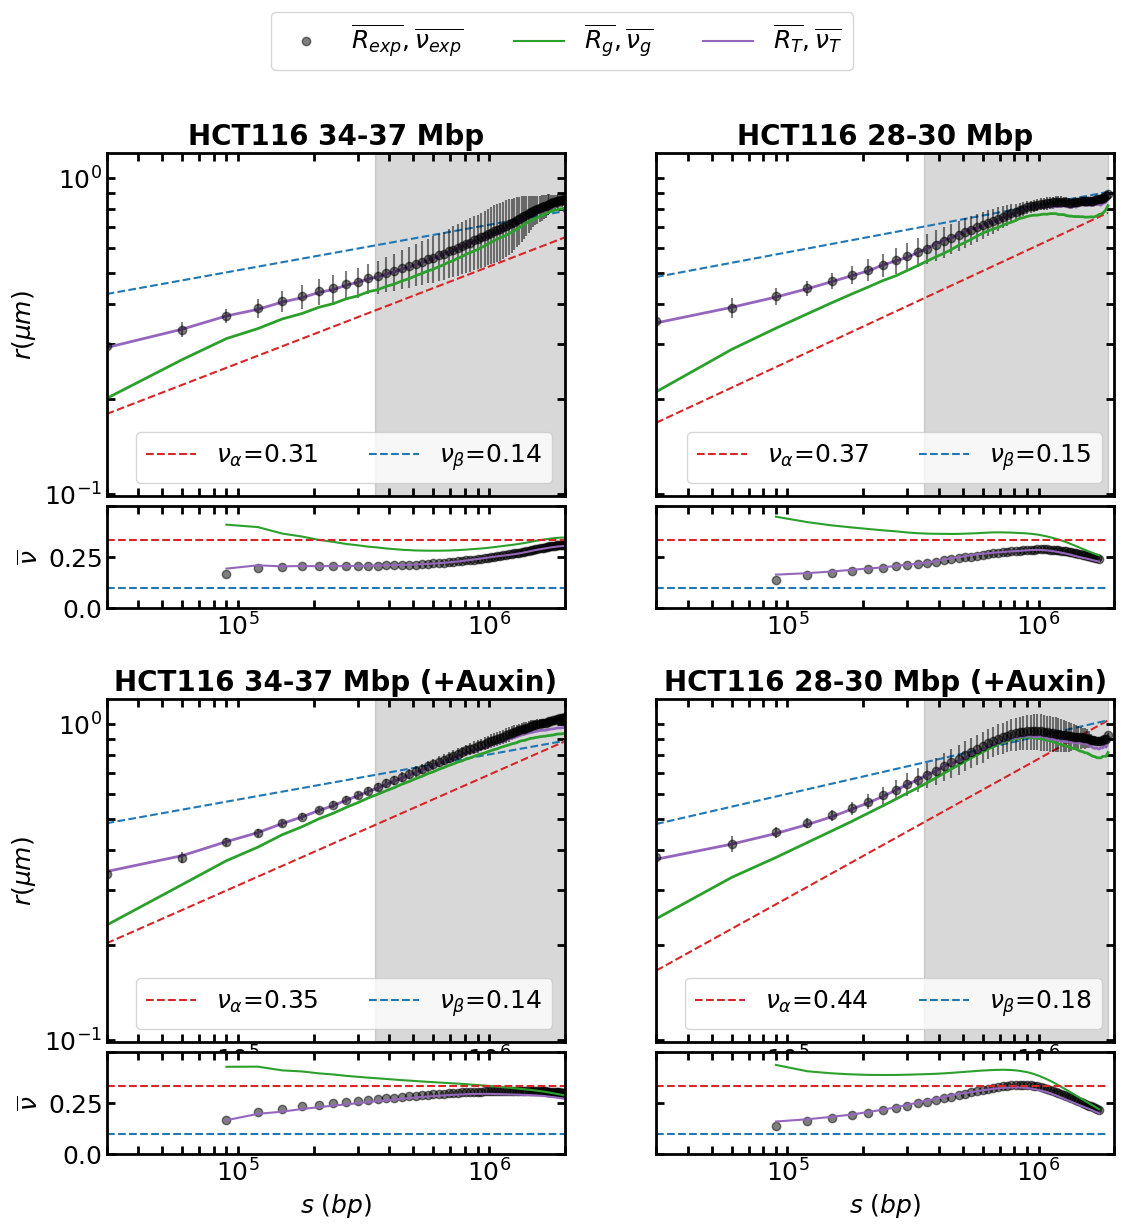

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.container import ErrorbarContainer

# Define the number of cell lines
cell_lines = ['HCT116','HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN','HCT116_AUXIN_FILE_2']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']
    mean_values_Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
    std_values_Rg = RESULTS[cell_line]['std_values_Rg_vs_gd']
    Reconstructed_R = RESULTS[cell_line]['Reconstructed_R_vs_gd']
    vu_T = RESULTS[cell_line]['vu_T_vs_gd']
    vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
    vu_g = RESULTS[cell_line]['vu_g_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']
    Rg_lower = RESULTS[cell_line]['Rg_lower_vs_gd']
    Rg_upper = RESULTS[cell_line]['Rg_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    # Plot Rt
    ax.errorbar(ss, mean_values_Rt, yerr=std_values_Rt, fmt='o', color='k',alpha=0.5)

    # Plot Rg
    ax.loglog(ss, mean_values_Rg, linewidth=2, color='tab:green')
    # ax.fill_between(ss, Rg_lower, Rg_upper, color='tab:green', alpha=0.2)

    # Plot Reconstructed Rt
    ax.loglog(ss, Reconstructed_R, linewidth=2, color='tab:purple')

    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0.09, 1.2)
    ax.set_xlim(30000, 2 * 10**6)
    ax.legend(ncol=2, fontsize=18, loc='lower right')
    ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xticklabels([])  # Remove x-tick labels
    # if cl >= 2:
        # ax.set_xlabel('Genomic distance (bp)', fontsize=18)
    if cl in [0, 2]:
        ax.set_ylabel(f'$r(\mu m)$', fontsize=18)
    ax.set_ylim(0.099, 1.2)
    ax.set_title(name, fontsize=20, fontweight='bold')
    ax.set_xticklabels([])  # Remove x-tick labels
    # Add secondary panel for vu_T, vu_g, and vu_eff at the bottom of the subplot
    x_range = range(1, len(vu_T) + 1)
    assert len(x_range) == len(vu_T), "x_range and vu_T must have the same length"

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="30%", pad=0.1, sharex=ax)
    ax2.plot(np.array(x_range)[2:] * 30000, vu_T[2:], 'o', color='k',alpha=0.5, label=r'$\nu_T$', zorder=1) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_g[2:], color='tab:green', label=r'$\nu_g$', zorder=2) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_eff[2:], color='tab:purple', label=r'$\nu_{eff}$', zorder=2) 
    ax2.plot(ss, [1/3]*len(ss), color='tab:red', linestyle='--', label=r'$\nu_\alpha$')
    ax2.plot(ss, [1/10]*len(ss), color='tab:blue', linestyle='--', label=r'$\nu_\beta$')
    ax2.set_ylim(-0.0001, 0.5)
    
    if cl in [0, 2]:
        ax2.set_ylabel(r'$\overline{\nu}$', fontsize=18, color='k')
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([r'$0.0$', r'$0.25$',''])
    else:
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([])
    if cl >= 2:
        ax2.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax2.set_xticks([100000, 1000000])
        ax2.set_xticklabels([r'$10^5$', r'$10^6$'])
    ax2.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)
    
    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

# Create a common legend for R_alpha, R_beta, and R_T outside the loop
legend_labels = [r'$\overline{R_{exp}}, \overline{\nu_{exp}}$', r'$\overline{R_{g}}, \overline{\nu_{g}}$', r'$\overline{R_{T}}, \overline{\nu_{T}}$']
handles = [Line2D([0], [0], linestyle='', marker='o',alpha=0.5, color='k',label=legend_labels[0]),
           Line2D([0], [0], linestyle='-', color='tab:green', label=legend_labels[1]),
           Line2D([0], [0], linestyle='-', color='tab:purple', label=legend_labels[2])]

fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=18)

# plt.savefig('scaling_behavior_old.pdf')
# plt.tight_layout()
plt.show()

<>:82: SyntaxWarning: invalid escape sequence '\m'
<>:82: SyntaxWarning: invalid escape sequence '\m'
/var/folders/tq/dgzmpwks2bd9glbd8wtm_99m0000gp/T/ipykernel_12065/1541122668.py:82: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel(f'$r(\mu m)$', fontsize=18)


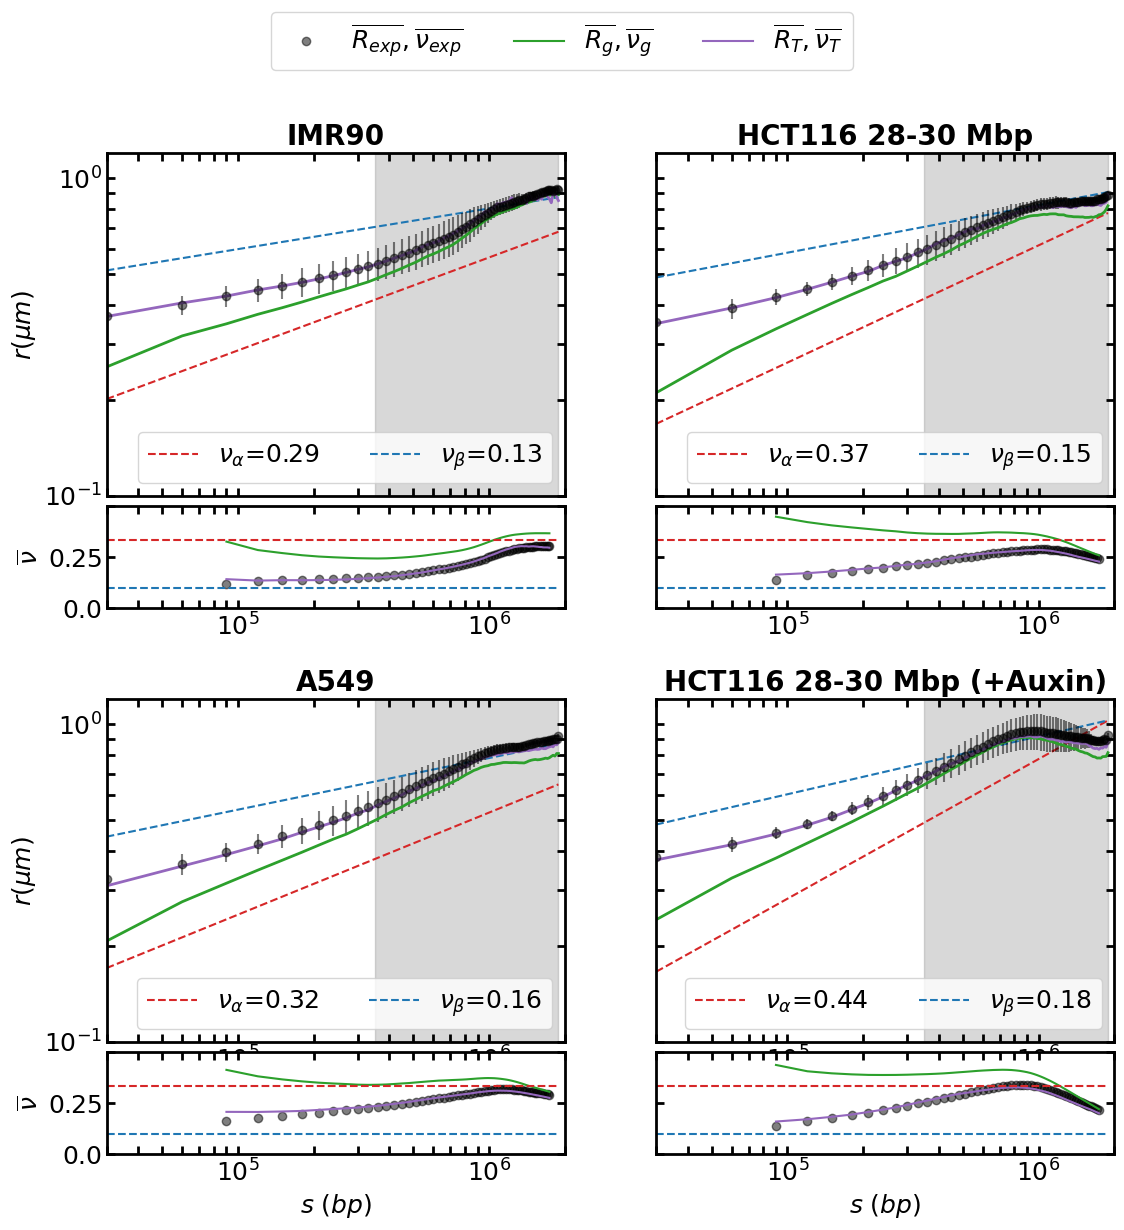

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.container import ErrorbarContainer

# Define the number of cell lines
cell_lines = ['IMR90', 'HCT116_UNTREATED_FILE_2', 'A549', 'HCT116_AUXIN_FILE_2']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']
    mean_values_Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
    std_values_Rg = RESULTS[cell_line]['std_values_Rg_vs_gd']
    Reconstructed_R = RESULTS[cell_line]['Reconstructed_R_vs_gd']
    vu_T = RESULTS[cell_line]['vu_T_vs_gd']
    vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
    vu_g = RESULTS[cell_line]['vu_g_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']
    Rg_lower = RESULTS[cell_line]['Rg_lower_vs_gd']
    Rg_upper = RESULTS[cell_line]['Rg_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    # Plot Rt
    ax.errorbar(ss, mean_values_Rt, yerr=std_values_Rt, fmt='o', color='k',alpha=0.5)

    # Plot Rg
    ax.loglog(ss, mean_values_Rg, linewidth=2, color='tab:green')
    # ax.fill_between(ss, Rg_lower, Rg_upper, color='tab:green', alpha=0.2)

    # Plot Reconstructed Rt
    ax.loglog(ss, Reconstructed_R, linewidth=2, color='tab:purple')

    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0.09, 1.2)
    ax.set_xlim(30000, 2 * 10**6)
    ax.legend(ncol=2, fontsize=18, loc='lower right')
    ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xticklabels([])  # Remove x-tick labels
    # if cl >= 2:
        # ax.set_xlabel('Genomic distance (bp)', fontsize=18)
    if cl in [0, 2]:
        ax.set_ylabel(f'$r(\mu m)$', fontsize=18)
    ax.set_ylim(0.1, 1.2)
    ax.set_title(name, fontsize=20, fontweight='bold')
    ax.set_xticklabels([])  # Remove x-tick labels
    # Add secondary panel for vu_T, vu_g, and vu_eff at the bottom of the subplot
    x_range = range(1, len(vu_T) + 1)
    assert len(x_range) == len(vu_T), "x_range and vu_T must have the same length"

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="30%", pad=0.1, sharex=ax)
    ax2.plot(np.array(x_range)[2:] * 30000, vu_T[2:], 'o', color='k',alpha=0.5, label=r'$\nu_T$', zorder=1) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_g[2:], color='tab:green', label=r'$\nu_g$', zorder=2) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_eff[2:], color='tab:purple', label=r'$\nu_{eff}$', zorder=2) 
    ax2.plot(ss, [1/3]*len(ss), color='tab:red', linestyle='--', label=r'$\nu_\alpha$')
    ax2.plot(ss, [1/10]*len(ss), color='tab:blue', linestyle='--', label=r'$\nu_\beta$')
    ax2.set_ylim(-0.0001, 0.5)
    
    if cl in [0, 2]:
        ax2.set_ylabel(r'$\overline{\nu}$', fontsize=18, color='k')
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([r'$0.0$', r'$0.25$',''])
    else:
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([])
    if cl >= 2:
        ax2.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax2.set_xticks([100000, 1000000])
        ax2.set_xticklabels([r'$10^5$', r'$10^6$'])
    ax2.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)
    
    # Add shaded area starting from s = 500000
    ax.axvspan(max_ss, ss.max(), color='gray', alpha=0.3)

# Create a common legend for R_alpha, R_beta, and R_T outside the loop
legend_labels = [r'$\overline{R_{exp}}, \overline{\nu_{exp}}$', r'$\overline{R_{g}}, \overline{\nu_{g}}$', r'$\overline{R_{T}}, \overline{\nu_{T}}$']
handles = [Line2D([0], [0], linestyle='', marker='o',alpha=0.5, color='k',label=legend_labels[0]),
           Line2D([0], [0], linestyle='-', color='tab:green', label=legend_labels[1]),
           Line2D([0], [0], linestyle='-', color='tab:purple', label=legend_labels[2])]

fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=18)


plt.savefig('scaling_behavior_old_2.pdf')
# plt.tight_layout()
plt.show()

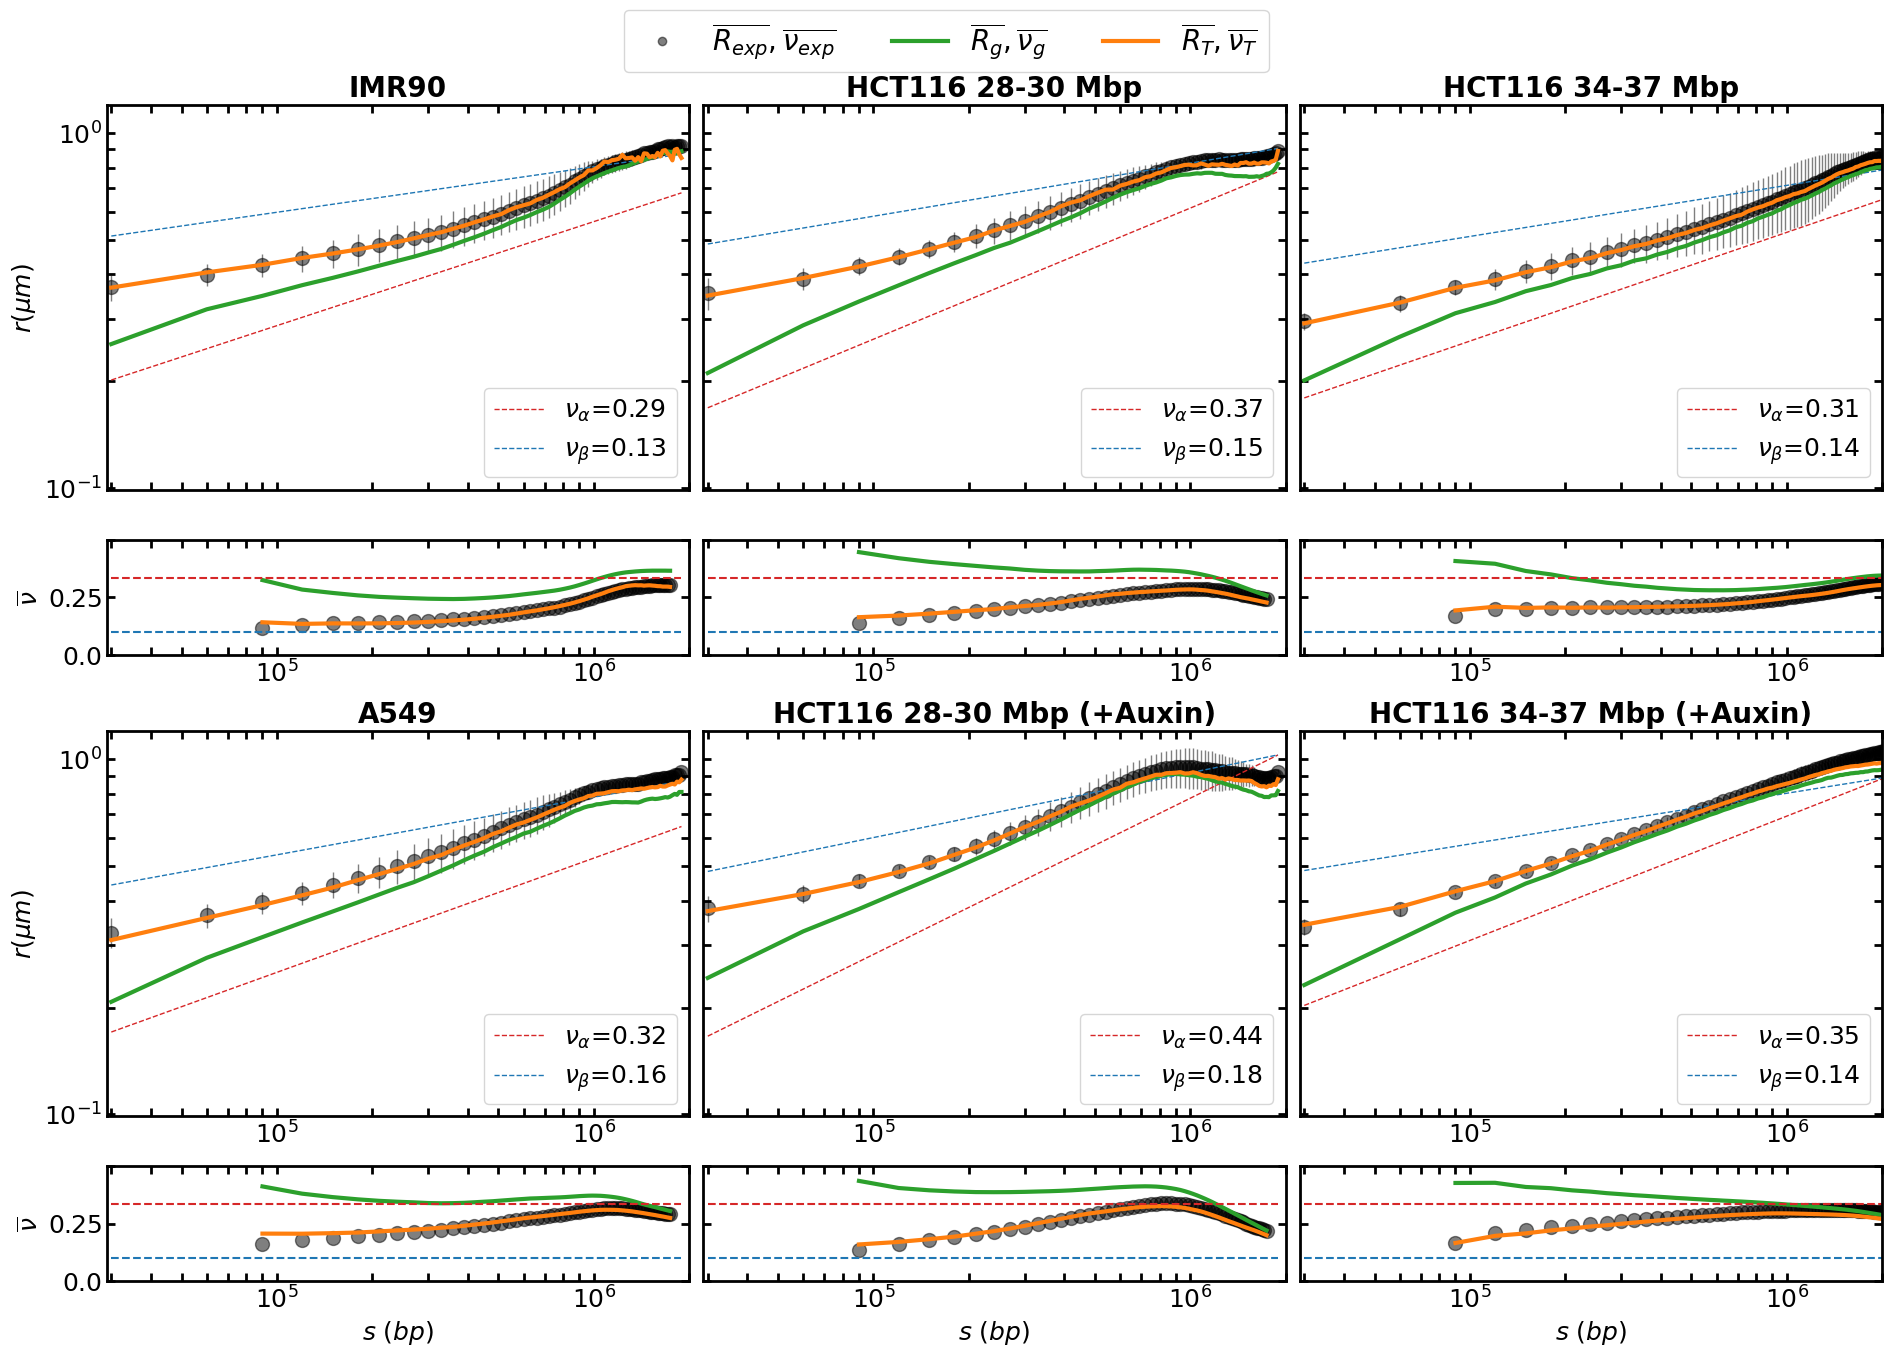

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the number of cell lines
cell_lines = ['IMR90', 'HCT116_UNTREATED_FILE_2', 'HCT116', 'A549', 'HCT116_AUXIN_FILE_2', 'HCT116_AUXIN']

# Create subplots with the correct number of axes
fig, axs = plt.subplots(2, 3, figsize=(19, 13), sharex=True, sharey=True)
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier indexing

for cl, cell_line in enumerate(cell_lines):
    name = RESULTS[cell_line]['name']
    color = RESULTS[cell_line]['color']

    mean_values_Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    std_values_Ra = RESULTS[cell_line]['std_values_Ra_vs_gd']
    mean_values_Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    std_values_Rb = RESULTS[cell_line]['std_values_Rb_vs_gd']
    mean_values_Rt = RESULTS[cell_line]['mean_values_Rt_vs_gd']
    std_values_Rt = RESULTS[cell_line]['std_values_Rt_vs_gd']
    mean_values_Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
    std_values_Rg = RESULTS[cell_line]['std_values_Rg_vs_gd']
    Reconstructed_R = RESULTS[cell_line]['Reconstructed_R_vs_gd']
    vu_T = RESULTS[cell_line]['vu_T_vs_gd']
    vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
    vu_g = RESULTS[cell_line]['vu_g_vs_gd']

    x_range = range(1, len(mean_values_Ra) + 1)
    ss = np.array(x_range) * 30000  # Genomic distances

    Ra_lower = RESULTS[cell_line]['Ra_lower_vs_gd']
    Ra_upper = RESULTS[cell_line]['Ra_upper_vs_gd']
    Rb_lower = RESULTS[cell_line]['Rb_lower_vs_gd']
    Rb_upper = RESULTS[cell_line]['Rb_upper_vs_gd']
    Rt_lower = RESULTS[cell_line]['Rt_lower_vs_gd']
    Rt_upper = RESULTS[cell_line]['Rt_upper_vs_gd']
    Rg_lower = RESULTS[cell_line]['Rg_lower_vs_gd']
    Rg_upper = RESULTS[cell_line]['Rg_upper_vs_gd']

    # Filter the data to include only points where ss <= 2 * 10^5 for Ra and Rb
    max_ss = 3.5 * 10**5
    filtered_indices = ss <= max_ss

    ss_filtered = ss[filtered_indices]
    mean_values_Ra_filtered = mean_values_Ra[filtered_indices]
    mean_values_Rb_filtered = mean_values_Rb[filtered_indices]

    # Fit the power function to the filtered data for Ra and Rb
    pa, _ = curve_fit(power_function, ss_filtered, mean_values_Ra_filtered)
    pb, _ = curve_fit(power_function, ss_filtered, mean_values_Rb_filtered)

    # Plot the data
    ax = axs[cl]
    
    ax.loglog(ss, power_function(ss, *pa), c='tab:red', linestyle='--',lw=1, label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
    ax.loglog(ss, power_function(ss, *pb), c='tab:blue', linestyle='--',lw=1, label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

    # Plot Rt
    ax.errorbar(ss, mean_values_Rt, yerr=std_values_Rt, fmt='o',markersize=10,lw=1, color='k',alpha=0.5, zorder=1) 

    # Plot Rg
    ax.loglog(ss, mean_values_Rg, linewidth=3, color='tab:green', zorder=2) 

    # Plot Reconstructed Rt
    ax.loglog(ss, Reconstructed_R, linewidth=3, color='tab:orange', zorder=2) 

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(29000, 2 * 10**6)
    ax.legend(ncol=1, fontsize=18, loc='lower right')
    ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xticklabels([])  # Remove x-tick labels
    if cl in [0, 3]:
        ax.set_ylabel(r'$r(\mu m)$', fontsize=18)
    ax.set_ylim(0.099, 1.2)
    ax.set_title(name, fontsize=20, fontweight='bold')
    # Remove x-tick labels for all but the bottom row
    if cl < 6:
        ax.set_xticklabels([])

    # Add secondary panel for vu_T, vu_g, and vu_eff at the bottom of the subplot
    x_range = range(1, len(vu_T) + 1)
    assert len(x_range) == len(vu_T), "x_range and vu_T must have the same length"

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="30%", pad=0.5, sharex=ax)
    ax2.plot(np.array(x_range)[2:] * 30000, vu_T[2:], 'o',markersize=10, color='k',alpha=0.5, label=r'$\nu_T$', zorder=1) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_g[2:],lw=3, color='tab:green', label=r'$\nu_g$', zorder=2) 
    ax2.plot(np.array(x_range)[2:] * 30000, vu_eff[2:],lw=3, color='tab:orange', label=r'$\nu_{eff}$', zorder=2) 
    ax2.plot(ss, [1/3]*len(ss), color='tab:red', linestyle='--', label=r'$\nu_\alpha$')
    ax2.plot(ss, [1/10]*len(ss), color='tab:blue', linestyle='--', label=r'$\nu_\beta$')
    ax2.set_ylim(-0.0001, 0.5)
    
    if cl in [0, 3]:
        ax2.set_ylabel(r'$\overline{\nu}$', fontsize=18, color='k')
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([r'$0.0$', r'$0.25$',''],fontsize=18)
    else:
        ax2.set_yticks([0, 0.25, 0.5])
        ax2.set_yticklabels([])
    if cl >= 3:
        ax2.set_xlabel(r'$s$ ($bp$)', fontsize=18)
        ax2.set_xticks([100000, 1000000])
        ax2.set_xticklabels([r'$10^5$', r'$10^6$'],fontsize=18)
    ax2.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax2.spines['top'].set_linewidth(2)
    ax2.spines['right'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)
    
    # Add shaded area starting from s = 500000
    # ax.axvspan(max_ss, 2*10**6, color='gray', alpha=0.3)

# Create a common legend for R_alpha, R_beta, and R_T outside the loop
legend_labels = [r'$\overline{R_{exp}}, \overline{\nu_{exp}}$', r'$\overline{R_{g}}, \overline{\nu_{g}}$', r'$\overline{R_{T}}, \overline{\nu_{T}}$']
handles = [Line2D([0], [0], linestyle='', lw=3 , marker='o',alpha=0.5, color='k',label=legend_labels[0]),
           Line2D([0], [0], linestyle='-', lw=3, color='tab:green', label=legend_labels[1]),
           Line2D([0], [0], linestyle='-', lw=3, color='tab:orange', label=legend_labels[2])]

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=20)

plt.tight_layout(pad=1)
# plt.savefig('scaling_behavior_all_bintu.pdf', bbox_inches='tight')
plt.show()

# 3.7 **Contact probability**


In [37]:
import numpy as np

def compute_contact_probability(distance_matrix, tag_i, tag_j, r_seuil):
    """
    Compute the contact probability for a given tag couple (i, j).

    Parameters:
    - distance_matrix (numpy.ndarray): The distance matrix for a cell line.
    - tag_i (int): The index of the first tag.
    - tag_j (int): The index of the second tag.
    - median_r (float): The median distance threshold.

    Returns:
    - float: The contact probability for the tag couple (i, j).
    """
    distances = distance_matrix[:, tag_i, tag_j]
    # Filter out NaN values
    distances = distances[~np.isnan(distances)]
    contact_count = np.sum(distances < r_seuil)
    total_cells = len(distances)
    contact_probability = contact_count / total_cells
    return contact_probability

def compute_all_contact_probabilities(cell_lines, results, r_seuil):
    """
    Compute the contact probabilities for all tag couples (i, j) for each cell line.

    Parameters:
    - cell_lines (list): List of cell line names.
    - results (dict): Dictionary containing the results for each cell line.
    - median_r (float): The median distance threshold.

    Returns:
    - dict: Updated results dictionary with contact probabilities.
    """
    for cell_line in cell_lines:
        distance_matrix = results[cell_line]['distmat']
        num_tags = distance_matrix.shape[1]
        contact_prob_matrix = np.zeros((num_tags, num_tags))

        for i in range(num_tags):
            for j in range(i, num_tags):
                contact_prob = compute_contact_probability(distance_matrix, i, j, r_seuil)
                contact_prob_matrix[i, j] = contact_prob
                contact_prob_matrix[j, i] = contact_prob  # Ensure symmetry

        results[cell_line]['contact_prob_matrix'] = contact_prob_matrix

    return results


def compute_average_contact_probability(contact_prob_matrix):
    num_tags = contact_prob_matrix.shape[0]
    avg_contact_prob = np.zeros(num_tags - 1)
    for i in range(1, num_tags):
        avg_contact_prob[i - 1] = np.mean([contact_prob_matrix[j, j + i] for j in range(num_tags - i)])
    return avg_contact_prob





In [38]:
# import matplotlib.pyplot as plt
# import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
# 
# # Set the font size for all elements
# plt.rcParams.update({'font.size': 18})
# 
# 
# # Initialize a dictionary to store the average contact probabilities
# avg_contact_probs = {}
# # Define the cell lines to be analyzed
# cell_lines = ['HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2', 'IMR90', 'A549', 'HCT116', 'HCT116_AUXIN']
# # Compute the average contact probabilities for each cell line
# for cell_line in cell_lines:
#     contact_prob_matrix = RESULTS[cell_line]['contact_prob_matrix']
#     avg_contact_probs[cell_line] = compute_average_contact_probability(contact_prob_matrix)
# 
# # Find the minimum length of avg_contact_probs across all cell lines
# min_length = min(len(avg_contact_probs[cell_line]) for cell_line in cell_lines)
# 
# # Define the genomic distances (ss) with the minimum length
# ss = np.arange(1, min_length + 1) * 30000  # Assuming 30,000 bp intervals
# 
# # Plot the average contact probabilities with respect to ss
# fig, axs = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
# 
# for cl, cell_line in enumerate(cell_lines):
#     Pc_s_tot = RESULTS[cell_line]['Reconstructed_P_c_s']
#     Pc_s_gauss = RESULTS[cell_line]['Reconstructed_P_d_s_g']
#     color = RESULTS[cell_line]['color']
# 
#     ss = np.arange(1, len(avg_contact_probs[cell_line]) + 1) * 30000
#     s = np.arange(1, len(avg_contact_probs[cell_line])) * 30000
#     log_s = np.log(ss[:min_length])
#     log_P = np.log(avg_contact_probs[cell_line][:min_length])
# 
#     # Interpolate with CubicSpline
#     cs_P = CubicSpline(log_s, log_P)
#     smooth_log_P = cs_P(log_s)
# 
#     # Compute the derivative
#     dlogP_dlogs = cs_P.derivative()(log_s)
# 
#     derivative_rec = np.gradient(np.log(Pc_s_tot), np.log(s))
# 
#     # Plot the interpolated contact probabilities
#     if cl < 4:
#         axs[0].loglog(ss[:min_length], np.exp(smooth_log_P), 'o', color=color, alpha=0.5, label=RESULTS[cell_line]['name'])
#         axs[0].loglog(s[:min_length], Pc_s_tot[:min_length], '-', color=color)
#         axs[0].set_title('[28 - 30] Mbp', fontsize=20, fontweight='bold')
#     else:
#         axs[1].loglog(ss[:min_length], np.exp(smooth_log_P), 'o', color=color, alpha=0.5, label=RESULTS[cell_line]['name'])
#         axs[1].loglog(s[:min_length], Pc_s_tot[:min_length], '-', color=color)
#         axs[1].set_title('[34 - 37] Mbp', fontsize=20, fontweight='bold')
# 
# # Plot the reference line
# x = np.array([25000, 2000000])
# y = 10000 / x
# axs[0].loglog(x, y, '--', color='k', label=r'$P_c(s) \propto s^{-1}$')
# axs[1].loglog(x, y, '--', color='k', label=r'$P_c(s) \propto s^{-1}$')
# 
# # Set labels and legend for the subplots
# axs[0].set_xlabel(r'$s$ ($bp$)', fontsize=18)
# axs[0].set_ylabel(r'$P_c(s)$', fontsize=18)
# axs[1].set_xlabel(r'$s$ ($bp$)', fontsize=18)
# 
# axs[0].tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
# axs[0].spines['top'].set_linewidth(2)
# axs[0].spines['right'].set_linewidth(2)
# axs[0].spines['bottom'].set_linewidth(2)
# axs[0].spines['left'].set_linewidth(2)
# 
# axs[1].tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
# axs[1].spines['top'].set_linewidth(2)
# axs[1].spines['right'].set_linewidth(2)
# axs[1].spines['bottom'].set_linewidth(2)
# axs[1].spines['left'].set_linewidth(2)
# 
# # Create a shared legend with custom handles
# custom_handles = [
#     Patch(facecolor='tab:blue', label='HCT116'),
#     Line2D([0], [0], marker='o', color='w', markerfacecolor='k', alpha=0.5, markersize=10, label=r'Exp $P_c(s)$'),
#     Patch(facecolor='tab:red', label='HCT116 (+Auxin 6h)'),
#     Line2D([0], [0], lw=2, color='k', label=r'Reconstructed $P_c(s)$'),
#     Patch(facecolor='tab:orange', label='IMR90'),
#     Line2D([0], [0], linestyle='--', color='k', label=r'$P_c(s) \propto s^{-1}$'),
#     Patch(facecolor='tab:purple', label='A549')]
# 
# fig.legend(handles=custom_handles, loc='upper center', ncol=4, fontsize=18, bbox_to_anchor=(0.5, 1.15))
# 
# # Adjust layout to make room for the shared legend
# plt.tight_layout()
# 
# # Save the figure with the legend included
# plt.savefig('Pc_s.pdf', bbox_inches='tight')
# plt.show()

In [39]:
# Define the constant r_seuil
r_seuil = 0.09  # Example value, adjust as needed

# Compute the theoretical contact probability P(ss)
cell_lines = ['HCT116', 'HCT116_AUXIN', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2','IMR90','A549']

for cell_line in cell_lines:
    Pc_s = []
    Pc_s_g =[]
    Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
    Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
    fa = RESULTS[cell_line]['mean_values_fa_vs_gd']
    Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
    
    vu_T = RESULTS[cell_line]['vu_T_vs_gd']
    vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
    vu_g = RESULTS[cell_line]['vu_g_vs_gd']
    
    Pc_s = np.sqrt(6/np.pi) * r_seuil**3 * (fa/Ra**3 + (1-fa)/Rb**3)
    # Compute Pc_s_g
    Pc_s_g = 4/3 * np.pi * r_seuil**3 * (3 / (2 * np.pi))**(1.5) / Rg**3
    
    # Check the shape of the result

    RESULTS[cell_line]['Reconstructed_P_c_s'] = Pc_s
    RESULTS[cell_line]['Reconstructed_P_d_s_g'] = Pc_s_g
    
# Define the cell lines to be analyzed
cell_lines = ['HCT116', 'HCT116_AUXIN', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2','IMR90','A549']

# Compute the contact probabilities for all tag couples (i, j) for each cell line
RESULTS = compute_all_contact_probabilities(cell_lines, RESULTS,r_seuil=r_seuil)

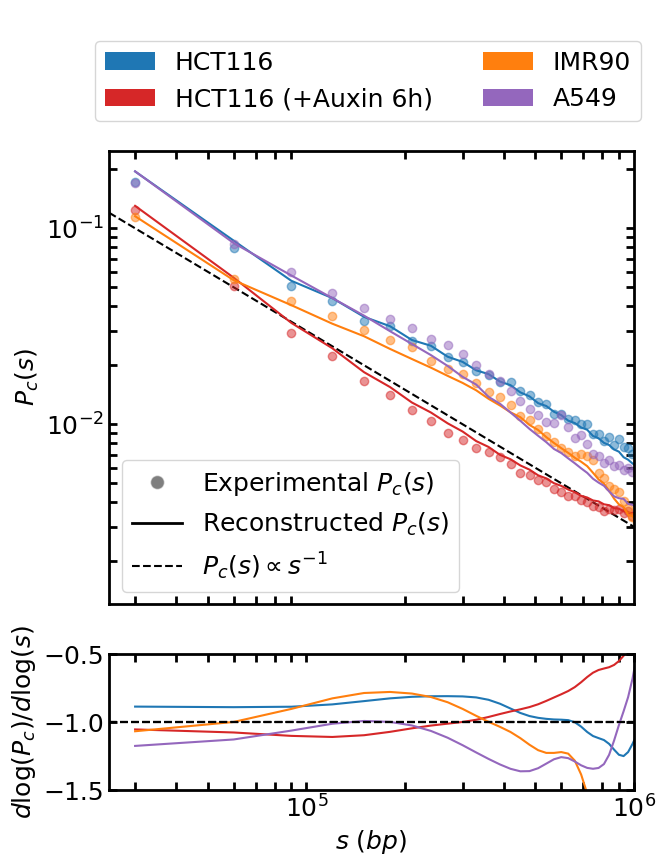

In [44]:

from scipy.ndimage import gaussian_filter1d

# Set the font size for all elements
plt.rcParams.update({'font.size': 18})


# Initialize a dictionary to store the average contact probabilities
avg_contact_probs = {}
# Define the cell lines to be plotted
cell_lines = ['HCT116', 'HCT116_AUXIN', 'IMR90','A549']

# Compute the average contact probabilities for each cell line
for cell_line in cell_lines:
    contact_prob_matrix = RESULTS[cell_line]['contact_prob_matrix']
    avg_contact_probs[cell_line] = compute_average_contact_probability(contact_prob_matrix)

# Find the minimum length of avg_contact_probs across all cell lines
min_length = min(len(avg_contact_probs[cell_line]) for cell_line in cell_lines)

# Define the genomic distances (ss) with the minimum length
ss = np.arange(1, min_length + 1) * 30000  # Assuming 30,000 bp intervals

# Plot the average contact probabilities with respect to ss
fig, ax = plt.subplots(figsize=(7, 9))

# Create inset axes before the loop
divider = make_axes_locatable(ax)
ax_inset = divider.append_axes("bottom", size="30%", pad=0.5)
# Plot the reference line
x = np.array([25000, 1000000])
y = 3000 / x
ax.loglog(x, y, '--', color='k', label=r'$P_c(s) \propto s^{-1}$')
for cell_line in cell_lines:
    Pc_s_tot = RESULTS[cell_line]['Reconstructed_P_c_s']
    color = RESULTS[cell_line]['color']

    # Ensure the lengths match
    if len(Pc_s_tot) > min_length:
        Pc_s_tot = Pc_s_tot[:min_length]

    # Recalculate ss for consistency
    ss = np.arange(1, min_length + 1) * 30000

    # Experimental log-transformed data
    log_s_exp = np.log(ss[:len(Pc_s_tot)])
    log_P_exp = np.log(avg_contact_probs[cell_line][:len(Pc_s_tot)])

    # Reconstructed log-transformed data
    log_Pc_s_tot = np.log(Pc_s_tot)
    
    # Interpolate with CubicSpline on the experimental curve
    cs_P_exp = CubicSpline(log_s_exp, log_P_exp)
    smooth_log_Pc_s_exp = cs_P_exp(log_s_exp)
    # Interpolate with CubicSpline on the reconstructed curve
    cs_P_tot = CubicSpline(log_s_exp, log_Pc_s_tot)
    smooth_log_Pc_s_tot = cs_P_tot(log_s_exp)

    # Compute the derivative (slope) of the smoothed reconstructed curve
    dlogP_exp_dlogs = cs_P_exp.derivative()(log_s_exp)
    dlogP_tot_dlogs = cs_P_tot.derivative()(log_s_exp)
    
    
    # Plot the experimental and reconstructed curves in the main figure
    ax.loglog(ss[:len(Pc_s_tot)], np.exp(smooth_log_Pc_s_exp), 'o', color=color, alpha=0.5, label=f'{RESULTS[cell_line]["name"]} Experimental')
    ax.loglog(ss[:len(Pc_s_tot)], np.exp(smooth_log_Pc_s_tot), '-', color=color, label=f'{RESULTS[cell_line]["name"]} Reconstructed')

    # Plot the derivative of the smoothed reconstructed curve in the inset

    # Apply Gaussian smoothing to the derivative data
    smoothed_dlogP_tot_dlogs = gaussian_filter1d(dlogP_tot_dlogs, sigma=2)
    smoothed_dlogP_exp_dlogs = gaussian_filter1d(dlogP_exp_dlogs, sigma=2)
    
    
    # Plot the smoothed data
    ax_inset.plot(ss[:len(Pc_s_tot)], smoothed_dlogP_tot_dlogs, '-', color=color)
    # ax_inset.plot(ss[:len(Pc_s_tot)], smoothed_dlogP_exp_dlogs, ':', color=color)
    ax_inset.plot(x, [-1]*len(x), '--', color='k')

# Set labels and title for the main plot
ax.set_ylabel(r'$P_c(s)$', fontsize=18)
ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Remove x-ticks from ax
ax.set_xlim(25000, 1000000)
ax.set_xticks([])

# Customize inset axis appearance
ax_inset.set_ylabel(r'$d\log(P_c)/d\log(s)$', fontsize=18)
ax_inset.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
ax_inset.set_xscale('log')
ax_inset.set_yscale('linear')
ax_inset.spines['top'].set_linewidth(2)
ax_inset.spines['right'].set_linewidth(2)
ax_inset.spines['bottom'].set_linewidth(2)
ax_inset.spines['left'].set_linewidth(2)
ax_inset.set_ylim(-1.5, -0.5)
ax_inset.set_xlim(25000, 1000000)
# ax_inset.set_xticks([100000, 1000000])
# ax_inset.set_xticklabels([r"$10^5$", r"$10^6$"], fontsize=18)
ax_inset.set_xlabel(r'$s$ ($bp$)', fontsize=18)
ax_inset.set_yticks([ -1.5,-1, -0.5])
# ax_inset.set_yticklabels([ r"$-1.5$", r"$-1$", r"$-0.5$"], fontsize=18)

# Create a shared legend with custom handles
custom_handles = [
    Patch(facecolor='tab:blue', label='HCT116'),
    Patch(facecolor='tab:red', label='HCT116 (+Auxin 6h)'),
    Patch(facecolor='tab:orange', label='IMR90'),
    Patch(facecolor='tab:purple', label='A549')
]

fig.legend(handles=custom_handles, loc='upper center', ncol=2, fontsize=18, bbox_to_anchor=(0.55, 0.95))

# Create a new inset axis for the custom_handles2 legend
ax_legend = divider.append_axes("top", size="20%", pad=0.5, sharex=ax)
ax_legend.axis('off')  # Hide the axis

# Add the custom_handles2 legend to the new inset axis
custom_handles2 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='k', alpha=0.5, markersize=10, label=r'Experimental $P_c(s)$'),
    Line2D([0], [0], lw=2, color='k', label=r'Reconstructed $P_c(s)$'),
    Line2D([0], [0], linestyle='--', color='k', label=r'$P_c(s) \propto s^{-1}$')
]

ax.legend(handles=custom_handles2, ncol=1, fontsize=18, loc='lower left')
# ax_legend(handles=custom_handles2, loc='lower left', fontsize=18, bbox_to_anchor=(0, 0))
# Adjust layout to make room for the shared legend
plt.tight_layout()

# Save the figure with the legend included
# plt.savefig('Pc_s_selected_cell_lines_with_slope.pdf', bbox_inches='tight')
plt.show()

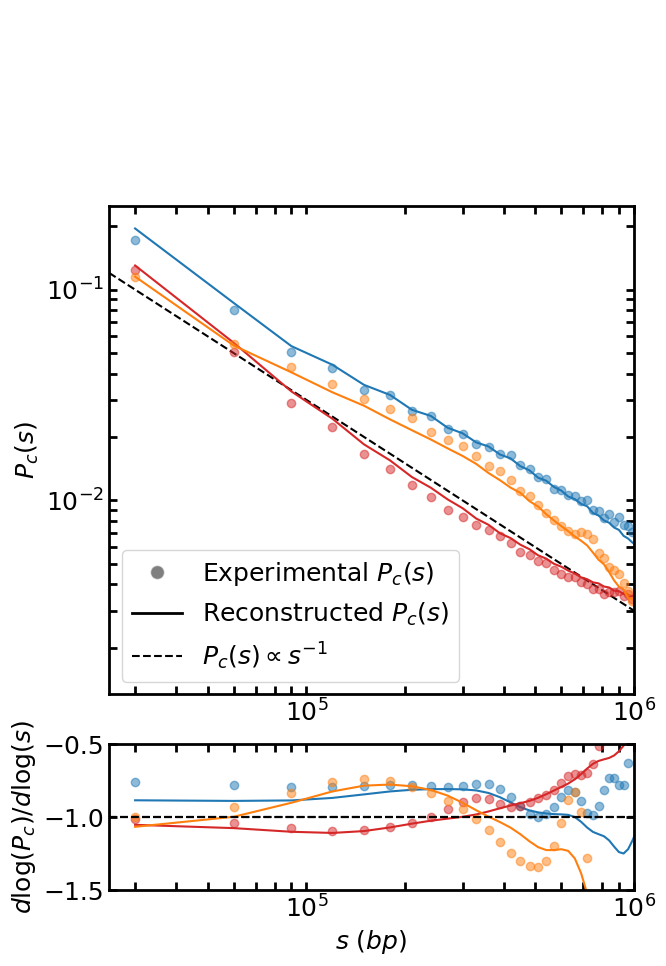

In [41]:
# TEST

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the different r_seuil values
r_seuil_values = [0.1]

# Define the cell lines to be analyzed
cell_lines = ['HCT116', 'HCT116_AUXIN', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2', 'IMR90', 'A549']

# Set the font size for all elements
plt.rcParams.update({'font.size': 18})

for r_seuil in r_seuil_values:
    # Compute the theoretical contact probability P(ss) for each cell line
    for cell_line in cell_lines:
        Pc_s = []
        Pc_s_g = []
        Ra = RESULTS[cell_line]['mean_values_Ra_vs_gd']
        Rb = RESULTS[cell_line]['mean_values_Rb_vs_gd']
        fa = RESULTS[cell_line]['mean_values_fa_vs_gd']
        Rg = RESULTS[cell_line]['mean_values_Rg_vs_gd']
        
        vu_T = RESULTS[cell_line]['vu_T_vs_gd']
        vu_eff = RESULTS[cell_line]['vu_eff_vs_gd']
        vu_g = RESULTS[cell_line]['vu_g_vs_gd']
        
        Pc_s = np.sqrt(6/np.pi) * r_seuil**3 * (fa/Ra**3 + (1-fa)/Rb**3)
        Pc_s_g = 4/3 * np.pi * r_seuil**3 * (3 / (2 * np.pi))**(1.5) / Rg**3
        
        RESULTS[cell_line]['Reconstructed_P_c_s'] = Pc_s
        RESULTS[cell_line]['Reconstructed_P_d_s_g'] = Pc_s_g
    
    # Compute the contact probabilities for all tag couples (i, j) for each cell line
    RESULTS = compute_all_contact_probabilities(cell_lines, RESULTS, r_seuil=r_seuil)
    
    # Initialize a dictionary to store the average contact probabilities
    avg_contact_probs = {}
    cell_lines_to_plot = ['HCT116', 'HCT116_AUXIN', 'IMR90']
    
    # Compute the average contact probabilities for each cell line
    for cell_line in cell_lines_to_plot:
        contact_prob_matrix = RESULTS[cell_line]['contact_prob_matrix']
        avg_contact_probs[cell_line] = compute_average_contact_probability(contact_prob_matrix)
    
    # Find the minimum length of avg_contact_probs across all cell lines
    min_length = min(len(avg_contact_probs[cell_line]) for cell_line in cell_lines_to_plot)
    
    # Define the genomic distances (ss) with the minimum length
    ss = np.arange(1, min_length + 1) * 30000  # Assuming 30,000 bp intervals
    
    # Plot the average contact probabilities with respect to ss
    fig, ax = plt.subplots(figsize=(7, 10))
    
    # Create inset axes before the loop
    divider = make_axes_locatable(ax)
    ax_inset = divider.append_axes("bottom", size="30%", pad=0.5)
    
    # Plot the reference line
    x = np.array([25000, 1000000])
    y = 3000 /x
    ax.loglog(x, y, '--', color='k', label=r'$P_c(s) \propto s^{-1}$')
    
    for cell_line in cell_lines_to_plot:
        Pc_s_tot = RESULTS[cell_line]['Reconstructed_P_c_s']
        color = RESULTS[cell_line]['color']
        
        if len(Pc_s_tot) > min_length:
            Pc_s_tot = Pc_s_tot[:min_length]
        
        ss = np.arange(1, min_length + 1) * 30000
        
        log_s_exp = np.log(ss[:len(Pc_s_tot)])
        log_P_exp = np.log(avg_contact_probs[cell_line][:len(Pc_s_tot)])
        log_Pc_s_tot = np.log(Pc_s_tot)
        
        cs_P_exp = CubicSpline(log_s_exp, log_P_exp)
        smooth_log_Pc_s_exp = cs_P_exp(log_s_exp)
        cs_P_tot = CubicSpline(log_s_exp, log_Pc_s_tot)
        smooth_log_Pc_s_tot = cs_P_tot(log_s_exp)
        
        dlogP_exp_dlogs = cs_P_exp.derivative()(log_s_exp)
        dlogP_tot_dlogs = cs_P_tot.derivative()(log_s_exp)
        
        ax.loglog(ss[:len(Pc_s_tot)], np.exp(smooth_log_Pc_s_exp), 'o', color=color, alpha=0.5, label=f'{RESULTS[cell_line]["name"]} Experimental')
        ax.loglog(ss[:len(Pc_s_tot)], np.exp(smooth_log_Pc_s_tot), '-', color=color, label=f'{RESULTS[cell_line]["name"]} Reconstructed')
        
        smoothed_dlogP_tot_dlogs = gaussian_filter1d(dlogP_tot_dlogs, sigma=2)
        smoothed_dlogP_exp_dlogs = gaussian_filter1d(dlogP_exp_dlogs, sigma=2)
        
        ax_inset.plot(ss[:len(Pc_s_tot)], smoothed_dlogP_tot_dlogs, '-', color=color)
        ax_inset.plot(ss[:len(Pc_s_tot)], smoothed_dlogP_exp_dlogs, 'o', color=color, alpha=0.5)
        ax_inset.plot(x, [-1]*len(x), '--', color='k')
    
    ax.set_ylabel(r'$P_c(s)$', fontsize=18)
    ax.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.set_xlim(25000, 1000000)
    # ax.set_xticks([])
    
    ax_inset.set_ylabel(r'$d\log(P_c)/d\log(s)$', fontsize=18)
    ax_inset.tick_params(axis='both', which='both', direction='in', length=6, width=2, labelsize=18, top=True, right=True)
    ax_inset.set_xscale('log')
    ax_inset.set_yscale('linear')
    ax_inset.spines['top'].set_linewidth(2)
    ax_inset.spines['right'].set_linewidth(2)
    ax_inset.spines['bottom'].set_linewidth(2)
    ax_inset.spines['left'].set_linewidth(2)
    ax_inset.set_ylim(-1.5, -0.5)
    ax_inset.set_xlim(25000, 1000000)
    ax_inset.set_xlabel(r'$s$ ($bp$)', fontsize=18)
    ax_inset.set_yticks([-1.5, -1, -0.5])
    
    custom_handles = [
        Patch(facecolor='tab:blue', label='HCT116', alpha=0.5 ),
        Patch(facecolor='tab:red', label='HCT116 (+Auxin 6h)', alpha=0.5),
        Patch(facecolor='tab:orange', label='IMR90', alpha=0.5)
    ]
    
    # fig.legend(handles=custom_handles, loc='upper center', ncol=3, fontsize=18, bbox_to_anchor=(0.55, 0.9))
    
    ax_legend = divider.append_axes("top", size="30%", pad=0.5, sharex=ax)
    ax_legend.axis('off')
    
    custom_handles2 = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', alpha=0.5, markersize=10, label=r'Experimental $P_c(s)$'),
        Line2D([0], [0], lw=2, color='k', label=r'Reconstructed $P_c(s)$'),
        Line2D([0], [0], linestyle='--', color='k', label=r'$P_c(s) \propto s^{-1}$')
    ]
    
    ax.legend(handles=custom_handles2, ncol=1, fontsize=18, loc='lower left')
    plt.tight_layout()
    
    plt.savefig(f'Pc_with_slope.pdf', bbox_inches='tight')
    plt.show()


# 3.7 **3 way Contact probability**


In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline

def compute_contact_probability(distance_matrix, tag_i, tag_j, r_seuil):
    distances = distance_matrix[:, tag_i, tag_j]
    valid_indices = ~np.isnan(distances)
    distances = distances[valid_indices]
    contact_count = np.sum(distances < r_seuil)
    total_cells = len(distances)
    contact_probability = contact_count / total_cells
    return contact_probability

def compute_triplet_contact_probability(distance_matrix, tag_i, tag_j, tag_k, r_seuil):
    if tag_i >= distance_matrix.shape[1] or tag_j >= distance_matrix.shape[1] or tag_k >= distance_matrix.shape[1]:
        raise IndexError("One of the indices is out of bounds")

    prob_ij = compute_contact_probability(distance_matrix, tag_i, tag_j, r_seuil)
    prob_ik = compute_contact_probability(distance_matrix, tag_i, tag_k, r_seuil)
    prob_jk = compute_contact_probability(distance_matrix, tag_j, tag_k, r_seuil)

    contact_probability = prob_ij * prob_ik * prob_jk
    return contact_probability

def compute_average_triplet_contact_probability(distance_matrix, r_seuil):
    num_tags = distance_matrix.shape[1]
    avg_triplet_contact_prob = np.zeros((num_tags, num_tags, num_tags))
    for i in range(num_tags):
        for j in range(i + 1, num_tags):
            for k in range(j + 1, num_tags):
                avg_triplet_contact_prob[i, j, k] = compute_triplet_contact_probability(distance_matrix, i, j, k, r_seuil)
    return avg_triplet_contact_prob




In [45]:
import numpy as np

def compute_triplet_contact_probability(distance_matrix, tag_i, tag_j, tag_k, r_seuil):
    # Example implementation, replace with actual logic
    return np.random.random()

def compute_average_triplet_contact_probability(distance_matrix, r_seuil):
    max_distance = distance_matrix.shape[0]
    avg_triplet_contact_probs = {d: 0 for d in range(1, max_distance)}
    count = {d: 0 for d in range(1, max_distance)}

    for i in range(max_distance):
        for j in range(i + 1, max_distance):
            for k in range(j + 1, max_distance):
                if abs(i - j) == abs(k - j):
                    prob = compute_triplet_contact_probability(distance_matrix, i, j, k, r_seuil)
                    distance = abs(i - j)
                    avg_triplet_contact_probs[distance] += prob
                    count[distance] += 1

    # Avoid division by zero and normalize
    for d in avg_triplet_contact_probs:
        if count[d] > 0:
            avg_triplet_contact_probs[d] /= count[d]

    # Convert to a list for plotting
    avg_triplet_contact_probs_list = [avg_triplet_contact_probs[d] for d in range(1, max_distance) if count[d] > 0]
    return avg_triplet_contact_probs_list

# Example usage
r_seuil = 0.1
cell_lines = ['HCT116', 'HCT116_AUXIN', 'IMR90']
avg_triplet_contact_probs = {}

for cell_line in cell_lines:
    distance_matrix = RESULTS[cell_line]['distmat']
    avg_triplet_contact_probs[cell_line] = compute_average_triplet_contact_probability(distance_matrix, r_seuil)

# Find the minimum length of avg_triplet_contact_probs across all cell lines
min_length = min(len(avg_triplet_contact_probs[cell_line]) for cell_line in cell_lines)

# Define the genomic distances (ss) with the minimum length
ss = np.arange(1, min_length + 1) * 30000  # Assuming 30,000 bp intervals

# Plot the average triplet contact probabilities with respect to ss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 9))

for cell_line in cell_lines:
    ax.loglog(ss, avg_triplet_contact_probs[cell_line][:min_length], label=cell_line)

# Plot the reference line
x = np.array([25000, 1000000])
y = 3000 / x
ax.loglog(x, y, '--', color='k', label=r'$P_c(s) \propto s^{-1}$')

# Set labels and title for the main plot
ax.set_xlabel(r'$s$ ($bp$)', fontsize=18)
ax.set_ylabel(r'$P_c(s)$', fontsize=18)
ax.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

PDF Rg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assume RESULTS dictionary is already defined

# Define cell lines
cell_lines = ['HCT116', 'HCT116_AUXIN', 'IMR90', 'A549', 'HCT116_UNTREATED_FILE_2', 'HCT116_AUXIN_FILE_2']
colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# Loop over all cell lines
for cl, cell_line in enumerate(cell_lines):
    # Extract matrices
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    num_tags = np.shape(Re1_matrix)[0]

    # Initialize matrix to hold R_T(i,j)
    R_T_matrix = np.sqrt(fr_matrix * Re1_matrix + (1 - fr_matrix) * Re2_matrix)

    # Initialize dictionary to hold Rg values for different segment lengths
    RESULTS[cell_line]['Rg_values'] = {}
    RESULTS[cell_line]['Rga_values'] = {}
    RESULTS[cell_line]['Rgb_values'] = {}

    # Loop over different segment lengths
    for segment_length in range(4, 8):
        Rg_values = []
        Rga_values = []
        Rgb_values = []
        

        # Loop over all starting indices for the segment
        for start in range(num_tags - segment_length + 1):
            Rg_square = 0
            Rga_square = 0
            Rgb_square = 0
            count = 0

            # Compute Rg, Rga, and Rgb for the segment
            for i in range(start, start + segment_length-1):
                for j in range(i + 1, start + segment_length):
                    Rg_square += fr_matrix[i, j] * Re1_matrix[i, j] ** 2 + (1 - fr_matrix[i, j]) * Re2_matrix[i, j] ** 2
                    Rga_square += Re1_matrix[i, j] ** 2
                    Rgb_square += Re2_matrix[i, j] ** 2
                    count += 1

            if count > 0:
                Rg_values.append(np.sqrt(Rg_square / count**2))
                Rga_values.append(np.sqrt(Rga_square / count**2))
                Rgb_values.append(np.sqrt(Rgb_square / count**2))

        # Store the Rg, Rga, and Rgb values for this segment length in the RESULTS dictionary
        RESULTS[cell_line]['Rg_values'][segment_length] = Rg_values
        RESULTS[cell_line]['Rga_values'][segment_length] = Rga_values
        RESULTS[cell_line]['Rgb_values'][segment_length] = Rgb_values

# Plot the PDFs for each segment length in subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
axs = axs.flatten()

for cl, cell_line in enumerate(cell_lines):
    ax = axs[cl]
    for segment_length, Rg_values in RESULTS[cell_line]['Rg_values'].items():
        cl = colors_list[segment_length-2]
        if len(Rg_values) > 0:  # Ensure there are elements to plot
            density = gaussian_kde(Rg_values)
            xs = np.linspace(min(Rg_values), max(Rg_values), 200)
            ax.plot(xs, density(xs),color=cl, label=r'$R_{G}, n=$' + f'{segment_length}')
    for segment_length, Rga_values in RESULTS[cell_line]['Rga_values'].items():
        cl = colors_list[segment_length-2]
        if len(Rga_values) > 0:  # Ensure there are elements to plot
            density = gaussian_kde(Rga_values)
            xs = np.linspace(min(Rga_values), max(Rga_values), 200)
            ax.plot(xs, density(xs),color=cl,  label=r'$R_{G,\alpha}$', linestyle='--')
    for segment_length, Rgb_values in RESULTS[cell_line]['Rgb_values'].items():
        cl = colors_list[segment_length-2]
        if len(Rgb_values) > 0:  # Ensure there are elements to plot
            density = gaussian_kde(Rgb_values)
            xs = np.linspace(min(Rgb_values), max(Rgb_values), 200)
            ax.plot(xs, density(xs),color=cl,  label=r'$R_{G,\beta}$', linestyle=':')

    ax.set_title(RESULTS[cell_line]['name'])
    ax.set_xlabel('Radius of Gyration (R_g)')
    ax.set_ylabel('Probability Density')
    ax.legend()

plt.suptitle('PDF of Radius of Gyration for Different Segment Lengths Across Cell Lines')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4 **Scaling behavior**

## 4.1 HCT116 cell line (+/-) Auxin: $\nu_\alpha$ and $\nu_\beta$

In [ ]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15

# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)

# Define directions, tags, and subplot positions
dirs = ['up', 'up', 'down', 'up', 'down', 'up', 'down', 'down', 'down']
tags = [4, 25, 25, 40, 40, 55, 55, 70, 80]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

# Iterate over cell lines
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Access pre-calculated matrices
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']

    # Create a figure for the plots
    fig = plt.figure(figsize=(15, 12))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        Ra,Rb,Rt,fr=[],[],[],[]
        # Access pre-calculated values based on direction
        
        # Extract data based on direction
        if dirs[i] == 'up':
            Ra = Re1_matrix[tag , tag+1:]
            Rb = Re2_matrix[tag , tag+1:]
            Rt = Rt_matrix[tag , tag+1:]
            fr = fr_matrix[tag , tag+1:]
        if dirs[i] == 'down':
            Ra = np.flip(Re1_matrix[tag , :tag ])
            Rb = np.flip(Re2_matrix[tag , :tag ])
            Rt = np.flip(Rt_matrix[tag , :tag ])
            fr = np.flip(fr_matrix[tag , :tag ])



        ss = 30000 * np.arange(1, len(Ra) + 1)

        # Perform calculations and fitting
        if len(Ra) > n:
            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])

            if len(Rt) > n_f + n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves
            plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3)

            plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

            plt.loglog(ss, power_function(ss, *pt), c='k', label=r'$\nu_{short}=$' + f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=r'$\nu_{long}$=' + f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                plt.xticks([], [])
                plt.yticks([], [])
            if nplots[i] in [331, 334]:
                plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])

            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [334]:
                plt.ylabel(r'$R$ (µm)', size=18)
            if nplots[i] in [338]:
                plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label,
                              markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k',
                              mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0 - 0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.2)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_scaling.pdf')

    # Show the plot
    plt.show()


## 4.2  HCT116 cell line (+/-) Auxin : Effective exponent $\nu_T$

In [ ]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)



dirs = ['up', 'up', 'up']
tags = [ 1, 20,  30]
nplots = [331, 332, 333]
# Iterate over cell lines
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Access distance matrix from RESULTS dictionary
    dm = RESULTS[cell_line]['distmat']

    # Create a figure for the plots
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Access pre-calculated values based on direction
        
        # Extract data based on direction
        if dirs[i] == 'up':

            Rt = Rt_matrix[tag , tag+1:]
        if dirs[i] == 'down':
            Rt = np.flip(Rt_matrix[tag , :tag])


        ss = 30000 * np.arange(1, len(Rt) + 1)

        # Perform calculations and fitting
        if len(Ra) > n:

            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])

            if len(Rt) > n_f + n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves

            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3, label='$R_T$')

            plt.loglog(ss, power_function(ss, *pt), c='k', label=f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                #plt.xticks([], [])
                plt.yticks([], [])
            #if nplots[i] in [331, 334]:
                #plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])
        
            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [331]:
                plt.ylabel(r'$R$ (µm)', size=18, labelpad=-20)

            if  cell_line == 'HCT116_AUXIN' :
                if nplots[i] in [332]:
                    plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    #fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.5)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
#     plt.savefig(f'{name}_scaling_RT.pdf')

    # Show the plot
    plt.show()
print("done")

## 4.3 IMR90 and K562 cell lines : $\nu_\alpha$ and $\nu_\beta$

In [ ]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


bins = np.linspace(0, 1.8, 25)
dirs = ['up', 'up', 'down', 'up', 'up', 'down', 'up', 'down', 'down']
tags = [1, 9, 20, 30, 32, 33, 45, 55, 60]
nplots = [331, 332, 333, 334, 335, 336, 337, 338, 339]

for cell_line in ['IMR90', 'K562']:

    # Access pre-calculated matrices
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']

    # Create a figure for the plots
    fig = plt.figure(figsize=(15, 12))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Access pre-calculated values based on direction
        
        # Extract data based on direction
        if dirs[i] == 'up':
            Ra = Re1_matrix[tag , tag+1:]
            Rb = Re2_matrix[tag , tag+1:]
            Rt = Rt_matrix[tag , tag+1:]
            fr = fr_matrix[tag , tag+1:]
        if dirs[i] == 'down':
            Ra = np.flip(Re1_matrix[tag , :tag ])
            Rb = np.flip(Re2_matrix[tag , :tag ])
            Rt = np.flip(Rt_matrix[tag , :tag ])
            fr = np.flip(fr_matrix[tag , :tag ])


        ss = 30000 * np.arange(1, len(Ra) + 1)

        # Perform calculations and fitting
        if len(Ra) > n:
            pa, pcov = curve_fit(power_function, ss[:n], Ra[:n])
            pb, pcov = curve_fit(power_function, ss[:n], Rb[:n])
            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])

            if len(Rt) > n_f + n:
                if cell_line in ['K562']:
                    try:
                        pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])
                    except:
                        print(f'all nan entries for tag {tag}')
                else :
                    pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])
                    

                
            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves
            plt.loglog(ss, Ra, '^', c='tab:red', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rb, 'o', c='tab:blue', ms=8, mew=2, alpha=0.3)
            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3)

            plt.loglog(ss, power_function(ss, *pa), c='tab:red', label=r'$\nu_\alpha$=' + f'{np.round(pa[1], 2)}')
            plt.loglog(ss, power_function(ss, *pb), c='tab:blue', label=r'$\nu_\beta$=' + f'{np.round(pb[1], 2)}')

            plt.loglog(ss, power_function(ss, *pt), c='k', label=r'$\nu_{short}=$' + f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=r'$\nu_{long}$=' + f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                plt.xticks([], [])
                plt.yticks([], [])
            if nplots[i] in [331, 334]:
                plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])

            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [334]:
                plt.ylabel(r'$R$ (µm)', size=18)
            if nplots[i] in [338]:
                plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label,
                              markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k',
                              mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0 - 0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.2)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
    # plt.savefig(f'{name}_scaling.png')

    # Show the plot
    plt.show()


## 4.4 IMR90 and K562 cell lines : Effective exponent $\nu_T$

In [ ]:
# Define the number of first neighboring tags used to compute the scaling behavior
n = 5

# Define the number of furthest tags used to compute the long-range scaling
n_f = 15


# Define bin edges for histogram
bins = np.linspace(0, 1.8, 25)



dirs = ['up', 'up', 'up']
tags = [ 1, 20,  30]
nplots = [331, 332, 333]
# Iterate over cell lines
for cell_line in ['IMR90', 'K562']:
    # Access distance matrix from RESULTS dictionary
    dm = RESULTS[cell_line]['distmat']

    # Create a figure for the plots
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(hspace=0.01, wspace=0.1)

    # Iterate over tags and directions
    for i, tag in enumerate(tags):
        # Access pre-calculated values based on direction
        
        # Extract data based on direction
        if dirs[i] == 'up':

            Rt = Rt_matrix[tag , tag+1:]
        if dirs[i] == 'down':
            Rt = np.flip(Rt_matrix[tag , :tag ])


        ss = 30000 * np.arange(1, len(Rt) + 1)

        # Perform calculations and fitting
        if len(Ra) > n:

            pt, pcov = curve_fit(power_function, ss[:n], Rt[:n])

            if len(Rt) > n_f + n:
                pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt[n_f:])

            # Add subplots
            ax = fig.add_subplot(nplots[i])

            # Plot data and fitted curves

            plt.loglog(ss, Rt, 's', c='k', ms=8, mew=2, alpha=0.3, label='$R_T$')

            plt.loglog(ss, power_function(ss, *pt), c='k', label=f'{np.round(pt[1], 2)}')
            plt.loglog(ss, power_function(ss, *pt_end), '--', c='k', label=f'{np.round(pt_end[1], 2)}')

            # Set y-axis limit
            plt.ylim([0.1, 1.5])

            # Add text label indicating direction
            if dirs[i] == 'up':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\uparrow$', transform=ax.transAxes, size=16, ha='left', va='top')
            if dirs[i] == 'down':
                plt.text(0.05, 0.95, f'tag: {tag}' + r'$\downarrow$', transform=ax.transAxes, size=16, ha='left', va='top')

            # Modify tick labels based on subplot position
            if nplots[i] in [332, 333, 335, 336]:
                #plt.xticks([], [])
                plt.yticks([], [])
            #if nplots[i] in [331, 334]:
                #plt.xticks([], [])
            if nplots[i] in [338, 339]:
                plt.yticks([], [])
        
            # Add subplot legend, labels, and adjust tick sizes
            plt.legend(loc='lower right', ncol=1, fontsize=16)
            plt.tick_params(labelsize=18)

            # Add y-label for specific subplots
            if nplots[i] in [331]:
                plt.ylabel(r'$R$ (µm)', size=18, labelpad=-20)

            if  cell_line == 'HCT116_AUXIN' :
                if nplots[i] in [332]:
                    plt.xlabel(r'Genomic Distance (bp)', size=18)

            # Set title for a specific subplot
            if nplots[i] == 332:
                name = RESULTS[cell_line]['name']
                plt.title(f'{name}', fontsize=20, fontweight='bold')

    # Create a common legend for R_alpha, R_beta, and R_T outside the loop
    legend_labels = [r'$R_\alpha$', r'$R_\beta$', r'$R_T$']
    handles = []
    for i, label in enumerate(legend_labels):
        handles.append(Line2D([0], [0], marker='^' if i == 0 else 'o' if i == 1 else 's', color='w', label=label, markersize=12, markerfacecolor='tab:red' if i == 0 else 'tab:blue' if i == 1 else 'k', mew=2))

    # Create a common legend for R_alpha, R_beta, and R_T
    #fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, 0-0.1))

    # Ensure plots are well-arranged
    plt.tight_layout(pad=0.5)
    name = RESULTS[cell_line]['name']

    # Uncomment the following line to save the plot as an SVG file
#     plt.savefig(f'{name}_scaling_RT.pdf')

    # Show the plot
    plt.show()
print("done")

# 5 **Exponents' profiles and distributions**

## 5.1 Functions

In [ ]:
def analyze_and_plot_cell_line(RESULTS, cell_line, Re1_matrix, Re2_matrix, fr_matrix, Rt_matrix):
    # Define the value of 'n' and 'n_f' for scaling analysis
    n = 5
    n_f = 15

    bins = np.linspace(0, 1.8, 25)
    dm = RESULTS[cell_line]['distmat']  # Get the distance matrix for the current cell line
    ncells, ntags, a = dm.shape  # Get the dimensions of the distance matrix
    
    # Initialize lists for results
    va_up, vb_up, vt_up, vt_up_long = [0] * ntags, [0] * ntags, [0] * ntags, [0] * ntags
    va_down, vb_down, vt_down, vt_down_long = [0] * ntags, [0] * ntags, [0] * ntags, [0] * ntags

    # Iterate over tags and directions for scaling analysis
    for tag in range(ntags):
       
        # Access pre-calculated matrices
        Re1_matrix_tag = Re1_matrix[tag , tag+1:]
        Re2_matrix_tag = Re2_matrix[tag , tag+1:]
        fr_matrix_tag = fr_matrix[tag , tag+1:]
        Rt_matrix_tag = Rt_matrix[tag , tag+1:]
        
        ss = 30000 * np.arange(1,len(Rt_matrix_tag)+1 )

        if len(Re1_matrix_tag) > n:
            pa, pcov = curve_fit(power_function, ss[:n], Re1_matrix_tag[:n])
            va_up[tag] = pa[1]

        if len(Re2_matrix_tag) > n:
            pb, pcov = curve_fit(power_function, ss[:n], Re2_matrix_tag[:n])
            vb_up[tag] = pb[1]

        if len(Rt_matrix_tag) > n:
            pt, pcov = curve_fit(power_function, ss[:n], Rt_matrix_tag[:n])
            vt_up[tag] = pt[1]

            if len(Rt_matrix_tag) > n_f + n:
                if cell_line in ['K562']:
                    try:
                        pt_long, pcov = curve_fit(power_function, ss[n_f:], Rt_matrix_tag[n_f:])
                        vt_up_long[tag] = (pt_long[1])
                    except:
                        print(f'all nan entries for tag {tag}')
                else :
                    pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt_matrix_tag[n_f:])
                    vt_up_long[tag] = pt_end[1]

        # Reverse the data for the 'down' direction
        Re1_matrix_tag_down = np.flip(Re1_matrix[tag , :tag])
        Re2_matrix_tag_down = np.flip(Re2_matrix[tag , :tag ])
        Rt_matrix_tag_down = np.flip(Rt_matrix[tag , :tag ])
        
        ss = 30000 * np.arange(1, len(Rt_matrix_tag_down)+1 )
        
        if len(Re1_matrix_tag_down) > n:
            pa, pcov = curve_fit(power_function, ss[:n], Re1_matrix_tag_down[:n])
            va_down[tag] = pa[1]

        if len(Re2_matrix_tag_down) > n:
            pb, pcov = curve_fit(power_function, ss[:n], Re2_matrix_tag_down[:n])
            vb_down[tag] = pb[1]

        if len(Rt_matrix_tag_down) > n:
            pt, pcov = curve_fit(power_function, ss[:n], Rt_matrix_tag_down[:n])
            vt_down[tag] = pt[1]

            if len(Rt_matrix_tag_down) > n_f +n :
                if cell_line in ['K562']:
                    try:
                        pt_long, pcov = curve_fit(power_function, ss[n_f:], Rt_matrix_tag_down[n_f:])
                        vt_down_long[tag] = (pt_long[1])
                    except:
                        print(f'all nan entries for tag {tag}')
                else :
                    pt_end, pcov = curve_fit(power_function, ss[n_f:], Rt_matrix_tag_down[n_f:])
                    vt_down_long[tag] = pt_end[1]


    # Combine results for 'up' and 'down' directions
    va = va_up + va_down
    vb = vb_up + vb_down
    vt = vt_up + vt_down
    vt_long = vt_up_long + vt_down_long
    
    # Calculate the mean, standard deviation, and visualize results
    mean_va = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(va_up, va_down)]
    mean_vb = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vb_up, vb_down)]
    mean_vt = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vt_up, vt_down)]
    mean_vt_long = [np.mean([up, down]) if up != 0 and down != 0 else max(up, down) for up, down in zip(vt_up_long, vt_down_long)]

    std_va = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(va_up, va_down)]
    std_vb = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vb_up, vb_down)]
    std_vt = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vt_up, vt_down)]
    std_vt_long = [np.std([up, down]) if up != 0 and down != 0 else 0.0 for up, down in zip(vt_up_long, vt_down_long)]

    va = np.array(va)
    vb = np.array(vb)
    vt = np.array(vt)
    vt_long = np.array(vt_long)

    # Print the results for the current cell line
    print(f'{cell_line}')
    print('va:', round(np.mean(mean_va), 2), round(np.sqrt(np.var(mean_va)), 2))
    print('vb:', round(np.mean(mean_vb), 2), round(np.sqrt(np.var(mean_vb)), 2))
    print('vt:', round(np.mean(mean_vt), 2), round(np.sqrt(np.var(mean_vt)), 2))
    print('vt_long:', round(np.mean(mean_vt_long), 2), round(np.sqrt(np.var(mean_vt_long)), 2))


     # Plot the results for scaling and density
    if cell_line in ['K562']:
        fig = plt.figure(figsize=(7.5, 4.3)) 
    else :
        fig = plt.figure(figsize=(7.5, 4))
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # Adjust the width_ratios as needed

    # Create subplots
    axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]

    # Make subplots share the y-axis
    axes[1].sharey(axes[0])    
    plt.subplots_adjust(wspace=0.2)
    
    axes[0].plot(range(ntags), mean_vt, color='black', label=r"$\nu_{short}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vt), np.std(mean_vt)))
#     axes[0].plot(range(ntags), mean_vt_long, '--',color='black', label=r"$\nu_{long}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vt_long), np.std(mean_vt_long)))

    axes[0].plot(range(ntags), mean_va, color=color_cycle[3], label=r"$\nu_{\alpha}$ = %.2f $\pm$ %.2f" % (np.mean(mean_va), np.std(mean_va)))
    axes[0].plot(range(ntags), mean_vb, color=color_cycle[0], label=r"$\nu_{\beta}$ = %.2f $\pm$ %.2f" % (np.mean(mean_vb), np.std(mean_vb)))

#     To display every single exponent (up and down) of each phase, uncomment:
#     axes[0].plot(range(ntags), va_up, '^', color=color_cycle[3])
#     axes[0].plot(range(ntags), vb_up, '^', color=color_cycle[0])
#     axes[0].plot(range(ntags), va_down, 'v', color=color_cycle[3]) 
#     axes[0].plot(range(ntags), vb_down, 'v', color=color_cycle[0])
    
    # Plot the uncertainty as transparency around the curves
    axes[0].fill_between(range(ntags), np.array(mean_vt) - np.array(std_vt), np.array(mean_vt) + np.array(std_vt), color='black', alpha=0.2)
#     axes[0].fill_between(range(ntags), np.array(mean_vt_long) - np.array(std_vt_long), np.array(mean_vt_long) + np.array(std_vt_long), color='black', alpha=0.2)

    axes[0].fill_between(range(ntags), np.array(mean_va) - np.array(std_va), np.array(mean_va) + np.array(std_va), color=color_cycle[3], alpha=0.2)
    axes[0].fill_between(range(ntags), np.array(mean_vb) - np.array(std_vb), np.array(mean_vb) + np.array(std_vb), color=color_cycle[0], alpha=0.2)

    for nu, label, color in zip([vt, va, vb], [r"$\nu_{short}$", r"$\nu_{\alpha}$", r"$\nu_{\beta}$"], ["black", color_cycle[3], color_cycle[0]]):
        num_bins = 15
        n, bins_dist = np.histogram(nu[nu > 0], bins=num_bins, density=True)
        bin_centers = (bins_dist[:-1] + bins_dist[1:]) / 2
        delta_bin = bins_dist[1] - bins_dist[0]

        # Smooth the histogram using interpolation
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        axes[1].plot(smoothed_curve, bin_centers, '-', label=label, color=color, alpha=1)
        axes[1].fill_betweenx(bin_centers, smoothed_curve, color=color, alpha=0.2)

    # Define the custom y-axis tick values as fractions
    custom_y_ticks = [0, Fraction(1/10), Fraction(1, 3), Fraction(1/2),Fraction(3/5)]

    # Format the tick labels as fractions
    axes[0].set_yticks([float(y) for y in custom_y_ticks])
    axes[0].set_yticklabels([str(Fraction(y).limit_denominator()) for y in custom_y_ticks], fontsize=18)
    

    if cell_line in ['K562']:
        axes[0].set_xlabel('i', fontsize=18)
        # Additional space for x-axis labels in the first subplot
        
    axes[0].set_ylabel(r"$\nu(i)$", fontsize=18)
    axes[0].set_ylim([0.0, 3/5+0.1])
    axes[0].set_yticklabels([str(Fraction(y).limit_denominator()) for y in custom_y_ticks])

    if cell_line in ['HCT116','HCT116_AUXIN'] :
        axes[0].set_xticks([0, 20, 40,60, 80])
    else :
        axes[0].set_xticks([0, 20, 40,60])
    axes[0].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[0].tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)

    axes[1].set_ylim([0.0, 3/5+0.05])
    axes[1].set_xlim([0.0, 15.5])
    if cell_line in ['K562']:
        axes[1].set_xlabel("Density", fontsize=18)
        # Additional space for x-axis labels in the first subplot

 
    axes[1].legend(fontsize=16, frameon=False)
    axes[1].set_xticks([0, 5, 10, 15])
    axes[1].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[1].tick_params(axis='y', which='both', labelleft=False, left=True, labelsize=18)
    name = RESULTS[cell_line]['name']
    fig.suptitle(f'{name}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(pad=0.2)
    plt.savefig(f'{name}_nu-dist.pdf')
    plt.show()


## 5.2 HTC116 (+/- Auxin)


In [ ]:
# Iterate over the specified cell lines and analyze/plot each of them
for cell_line in ['HCT116', 'HCT116_AUXIN']:
    # Access pre-calculated matrices
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']

    # Call the modified function with pre-calculated matrices
    analyze_and_plot_cell_line(RESULTS, cell_line, Re1_matrix, Re2_matrix, fr_matrix, Rt_matrix)


## 5.3 IMR90 and K562


In [ ]:
for cell_line in ['IMR90','K562']:
    # Access pre-calculated matrices
    Re1_matrix = RESULTS[cell_line]['Re1_matrix']
    Re2_matrix = RESULTS[cell_line]['Re2_matrix']
    fr_matrix = RESULTS[cell_line]['fr_matrix']
    Rt_matrix = RESULTS[cell_line]['Rt_matrix']

    # Call the modified function with pre-calculated matrices
    analyze_and_plot_cell_line(RESULTS, cell_line, Re1_matrix, Re2_matrix, fr_matrix, Rt_matrix)

# **6 Single cell beta phase detection**

## 6.1 Functions

In [ ]:
def CompleteHistogram(zxys,n,bins=np.linspace(0,1.8,25),interpolate=False,density=True,bins_center=False):
    """
    Compute a histogram of pairwise distances within the dataset.

    :param zxys: The spatial data points (coordinates).
    :param n: The offset to consider when computing pairwise distances.
    :param bins: The bin edges for the histogram (default: equally spaced bins from 0 to 1.8).
    :param interpolate: Flag to indicate whether to interpolate the data (default: False).
    :param density: Flag to normalize the histogram (default: True).
    :param bins_center: Flag to center bin edges on data points (default: False).
    :return: hist: The histogram values.
    :return: bins: The bin edges.
    """
    if interpolate: zxys=INTERPOLATE_ZXY(zxys)
    if bins_center: 
        dx=bins[1]-bins[0]
        bins=[bins[0]-dx/2+i*dx for i in range(len(bins)+1)]
    dm=np.array(list(map(squareform,map(pdist,zxys))))
    ncells=len(dm)
    dat=[]
    for c in range(ncells):
        dat+=list(np.diagonal(dm[c],offset=n))
    dat=np.array(dat)
    dat_=dat[~np.isnan(dat)]
    return np.histogram(dat_,bins=bins,density=density)

def ClusterMap(zxys,interpolate=False,bins=np.linspace(0,1.8,25),bins_center=False,round=False):
    """
    Compute a clustering map for the given spatial data points.

    :param zxys: The spatial data points.
    :param interpolate: Flag to indicate whether to interpolate the data (default: False).
    :param bins: The bin edges for the histogram (default: equally spaced bins from 0 to 1.8).
    :param bins_center: Flag to center bin edges on data points (default: False).
    :param round: Flag to round the clustering scores (default: False).
    :return: clst: The clustering map.
    """
        
    if interpolate: zxys=INTERPOLATE_ZXY(zxys)
    dm=np.array(list(map(squareform,map(pdist,zxys))))
    hist,bins=CompleteHistogram(zxys,1,bins,bins_center=bins_center)
    bc=0.5*(bins[1:]+bins[:-1])
    param,pcov=curve_fit(TWO_GAUSSIAN_DISTR,bc,hist,bounds=([0,0,0],[1,2,1]))
    clts=[]
    ncells=len(dm)
    for c in range(ncells):
        clts.append((1-param[2])*GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),param[1])/TWO_GAUSSIAN_DISTR(np.diagonal(dm[c],offset=1),*param))
    clst=np.array(clts)
    if round: clst=np.round(clst)
    return np.array(clst)

def CoarseClusterMap(clst,n,round=False):
    """
    Compute a coarser version of a clustering map by averaging within a window.

    :param clst: The clustering map data.
    :param n: The window size for averaging.
    :param round: Flag to round the values (default: False).
    :return: cclst: The coarser clustering map.
    """

    cclst=[]
    ncells,ntags=clst.shape
    for c in range(ncells):
        dat=[np.sum(clst[c,t:t+n])/n for t in range(ntags) if t+n<ntags]
        cclst.append(dat)
    cclst=np.array(cclst)
    if round: cclst=np.round(cclst)
    return cclst

## 6.2 Single-step (i,i+1) distribution

In [ ]:
n = 1  # Set the parameter 'n' for offset
nplots = [221, 222, 223, 224]  # Define subplot positions
StepParam = {}  # Initialize a dictionary to store parameters
fig = plt.figure(figsize=(9, 9))  # Create a new figure

# Iterate over different cell lines
for i, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    StepParam[cell_line] = {}  # Initialize a sub-dictionary for the current cell line

    zxys = RESULTS[cell_line]['zxys']  # Get the spatial data for the current cell line
    name = RESULTS[cell_line]['name']  # Get the name of the current cell line

    # Compute a histogram of pairwise distances
    hist, bins = CompleteHistogram(zxys, n=n)

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Fit a Gaussian distribution to the data
    param1, pcov = curve_fit(GAUSSIAN_DISTR, bin_centers, hist, bounds=([0], [2]))

    # Fit a weighted combination of two Gaussian distributions to the data
    param2, pcov = curve_fit(TWO_GAUSSIAN_DISTR, bin_centers, hist, bounds=([0, 0, 0], [1, 2, 1]))

    # Store the parameters in the StepParam dictionary
    StepParam[cell_line][1] = param1
    StepParam[cell_line][2] = param2

    rr = np.linspace(0, 1.8, 200)  # Create a range for plotting

    ax = fig.add_subplot(nplots[i])  # Add a subplot to the figure
    plt.title(f'{name}', fontsize=18, fontweight='bold')  # Set the subplot title

    # Plot the Gaussian distribution with parameters
    plt.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + ' (eq. 2)')

    # Fill the area under the weighted Gaussian distributions
    plt.fill_between(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', alpha=0.2)
    plt.plot(rr, param2[2] * GAUSSIAN_DISTR(rr, param2[0]), color='tab:red', lw=1)
    plt.fill_between(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', alpha=0.2)
    plt.plot(rr, (1 - param2[2]) * GAUSSIAN_DISTR(rr, param2[1]), color='tab:blue', lw=1)

    # Create a label for the weighted Gaussian distribution
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2)) + ' (eq. 5)'
    plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

    plt.plot(bin_centers, hist, 'o', ms=6, mew=3, mec='black', c='black')  # Plot data points

    plt.xlim([0, 1.2])  # Set the x-axis limits
    plt.ylim([-0.2, 5.2])  # Set the y-axis limits
    plt.legend(loc='upper right', fontsize=16)  # Add a legend
    plt.text(0.75, 0.5, f'(i;i+{n})', transform=ax.transAxes, fontsize=16)  # Add text
    if nplots[i] in [221]:  # Customize the plot appearance
        plt.text(0.09, 0.5, r'$\mathbf{\alpha}$', transform=ax.transAxes, fontsize=18, color='tab:red')
        plt.text(0.3, 0.05, r'$\mathbf{\beta}$', transform=ax.transAxes, fontsize=18, color='tab:blue')
    plt.tick_params(labelsize=18)
    if nplots[i] in [223, 224]:
        plt.xlabel(r'$r$ (µm)', size=18)  # Set x-axis label

plt.tight_layout()  # Adjust subplot layout
# plt.savefig


## 6.3 Comparison of Topological Phases and Radius of Gyration

In [ ]:
def RadiusOfGyration(zxy, n, interpolate=False):
    """
    Calculate the Radius of Gyration for a given 3D coordinate sequence.

    Parameters:
    zxy (array-like): 3D coordinates (z, x, y) of particles over time.
    n (int): Window size for calculating the Radius of Gyration.
    interpolate (bool): If True, interpolate zxy data.

    Returns:
    ps (array): Time indices associated with calculated Rg values.
    rg (array): Calculated Radii of Gyration over the chromosome region.
    """
    if interpolate:
        zxy = interpolate_zxy(zxy)  # Optionally interpolate zxy data
    
    ps = []  # List to store time indices
    rg = []  # List to store Radii of Gyration
    i = 0
    while i + n < len(zxy):
        rg.append(np.sqrt(np.sum(np.var(zxy[i:i+n], axis=0))))  # Calculate Rg for the window
        i += 1
        ps.append((2 * i + n - 1) / 2)  # Store the time index
    
    return np.array(ps), np.array(rg)  # Convert lists to numpy arrays


def RadiusOfGyration_cell_line(zxys, n, interpolate=False):
    """
    Calculate the Radius of Gyration for a list of cell line coordinates.

    Parameters:
    zxys (list): List of 3D coordinate sequences for multiple cells.
    n (int): Window size for calculating the Radius of Gyration.
    interpolate (bool): If True, interpolate zxy data.

    Returns:
    ps (array): Time indices associated with calculated Rg values.
    Rg (array): Calculated Radii of Gyration over the chromosome region for all cells.
    """
    ncells = len(zxys)  # Get the number of cells
    Rg = []  # List to store Rg values for all cells

    for c in range(ncells):
        zxy = zxys[c]  # Get the zxy coordinates for the current cell
        ps, rg = RadiusOfGyration(zxy, n=n, interpolate=interpolate)  # Calculate Rg for the cell
        Rg.append(rg)  # Store the Rg values for the cell
    
    return ps, np.array(Rg)  # Convert lists to numpy arrays


### 6.3.1 HCT116 cell line (+/-) Auxin

In [ ]:
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN']):
    zxys = RESULTS[cell_line]['zxys']  # Get 3D coordinates for the cell line
    CELLS, zxys = NonNanPaths(zxys)  # Remove paths with NaN values
    ps, Rg = RadiusOfGyration_cell_line(zxys, 5, interpolate=False)  # Calculate Radius of Gyration
    cm = ClusterMap(zxys, interpolate=False)  # Create a cluster map
    ccm = CoarseClusterMap(cm, n=4)  # Create a coarse cluster map
    print(len(CELLS))

    cells = np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])], dtype=int)  # Filter non-NaN paths

    fig = plt.figure(figsize=(12, 6.65))
    nplots = [231, 232, 233, 234, 235, 236]
    ylims = [[0.05, 0.45], [0.05, 0.55]]

    for i, c in enumerate(cells[:6]):
        ax = fig.add_subplot(nplots[i])
        ax.plot(ps, Rg[c], c='black', label='$R_g$', lw=2)
        ax1 = ax.twinx()
        ax1.plot([], [], c='black', label='$R_g$', lw=2)
        ax1.plot(ps, ccm[c], '-.', c='tab:blue', label=r'$p_\beta$', lw=2)
        ax.set_ylim(ylims[cl])
        ax1.set_ylim([-0.05, 1.05])
        ax.set_xticks([0, 20, 40, 60, 80], [])
        ax.set_yticks([0, 0.3, 0.6], [])
        ax1.set_yticks([0, 0.5, 1.0], [])
        pearson_corr, _ = pearsonr(Rg[c], ccm[c])
        ax.text(np.max(ps)*0.62, 0.55, f'Corr: {pearson_corr:.2f}', fontsize=18)
        if nplots[i] in [234, 235, 236]:
            ax.set_xlabel('Tag number', fontsize=18)
            ax.set_xticks([0, 20, 40, 60, 80], [0, 20, 40, 60, 80], fontsize=18)
        if nplots[i] in [231, 234]:
            ax.set_ylabel('$R_g$ (µm)', fontsize=18)
            ax.set_yticks([0, 0.3, 0.6], [0, 0.3, 0.6], fontsize=18)
        if nplots[i] in [233, 236]:
            ax1.set_ylabel(r'$p_\beta$', fontsize=18)
            ax1.set_yticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=18)
        if nplots[i] in [232]:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')
        if nplots[i] == 231:
            ax1.legend(loc='upper left', fontsize=18)
        ax1.set_ylim([0, 1])
        plt.tick_params(labelsize=18)
        plt.text(0.98, 0.02, f'cell {CELLS[c]}', transform=ax.transAxes, fontsize=16, ha='right', va='bottom')
    plt.tight_layout()
#     plt.savefig(f'{name}_Rg_pb.png', facecolor='white', dpi=500)
    plt.show()


### 6.3.2 IMR90 cell line

In [ ]:
for cl,cell_line in enumerate(['IMR90','K562']):
    zxys=RESULTS[cell_line]['zxys']
    CELLS,zxys=NonNanPaths(zxys)
    ps,Rg=RadiusOfGyration_cell_line(zxys,5,interpolate=False)
    cm=ClusterMap(zxys,interpolate=False)
    ccm=CoarseClusterMap(cm,n=4)
    print(len(CELLS))

    cells=np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])],dtype=int)
    fig = plt.figure(figsize=(12, 6.65))
    nplots=[231,232,233,234,235,236]
    ylims=[[0.0,0.5],[0.0,0.5]]
    for i,c in enumerate(cells[:6]):
        ax=fig.add_subplot(nplots[i])
        ax.plot(ps,Rg[c],c='black',label='$R_g$',lw=2)
        ax1=ax.twinx()
        ax1.plot([],[],c='black',label='$R_g$',lw=2)
        ax1.plot(ps,ccm[c],'-.',c='tab:blue',label=r'$p_\beta$',lw=2)
        ax.set_ylim(ylims[cl])
        ax1.set_ylim([-0.05,1.05])
        ax.set_xticks([0,20,40,60],[])
        ax.set_yticks([0,0.3,0.5],[])
        ax1.set_yticks([0,0.5,1.0],[])
        pearson_corr, _ = pearsonr(Rg[c], ccm[c])
        ax.text(np.max(ps)*0.62, 0.55, f'Corr: {pearson_corr:.2f}', fontsize=18)

        if nplots[i] in [234,235,236]:
            ax.set_xlabel('Tag number',fontsize=18)
            ax.set_xticks([0,20,40,60],[0,20,40,60],fontsize=18)
        if nplots[i] in [231,234]:
            ax.set_ylabel('$R_g$ (µm)',fontsize=18)
            ax.set_yticks([0,0.3,0.5],[0,0.3,0.5],fontsize=18)
        if nplots[i] in [233,236]:
            ax1.set_ylabel(r'$p_\beta$',fontsize=18)
            ax1.set_yticks([0,0.5,1.0],[0,0.5,1.0],fontsize=18)
        if nplots[i] in [232]:
            name=RESULTS[cell_line]['name']
            plt.title(f'{name}',fontsize=20,fontweight='bold')
        if nplots[i]==231:
            ax1.legend(loc='upper left',fontsize=18)
        ax1.set_ylim([0,1])
        plt.tick_params(labelsize=18)
        plt.text(0.98,0.02,f'cell {CELLS[c]}',transform=ax.transAxes,fontsize=18,ha='right',va='bottom')
    plt.tight_layout()
#     plt.savefig(f'{name}_Rg_pb.png',facecolor='white',dpi=500)
    plt.show()

### 6.3.3 K562 cell line

In [ ]:
# for cl,cell_line in enumerate(['K562']):
#     zxys=RESULTS[cell_line]['zxys'][:,:40]
#     CELLS,zxys=NonNanPaths(zxys)
#     ps,Rg=RadiusOfGyration_cell_line(zxys,5,interpolate=False)
#     cm=ClusterMap(zxys,interpolate=False)
#     ccm=CoarseClusterMap(cm,n=4)
#     print(len(CELLS))
# 
#     cells=np.array([c for c in range(len(zxys)) if not True in np.isnan(zxys[c])],dtype=int)
#     fig = plt.figure(figsize=(12, 6.65))
#     nplots=[231,232,233,234,235,236]
#     ylims=[[0.05,0.45],[0.05,0.55]]
#     for i,c in enumerate(cells[:6]):
#         ax=fig.add_subplot(nplots[i])
#         ax.plot(ps,Rg[c],c='black',label='$R_g$',lw=2)
#         ax1=ax.twinx()
#         ax1.plot([],[],c='black',label='$R_g$',lw=2)
#         ax1.plot(ps,ccm[c],'-.',c='tab:blue',label=r'$p_\beta$',lw=2)
#         ax.set_ylim(ylims[cl])
#         ax1.set_ylim([-0.05,1.05])
#         ax.set_xticks([0,20,40,40],[])
#         ax.set_yticks([0,0.3,0.6],[])
#         ax1.set_yticks([0,0.5,1.0],[])
#         pearson_corr, _ = pearsonr(Rg[c], ccm[c])
#         ax.text(np.max(ps)*0.62, 0.55, f'Corr: {pearson_corr:.2f}', fontsize=18)
#         if nplots[i] in [234,235,236]:
#             ax.set_xlabel('Tag number',fontsize=18)
#             ax.set_xticks([0,20,40],[0,20,40],fontsize=18)
#         if nplots[i] in [231,234]:
#             ax.set_ylabel('$R_g$ (µm)',fontsize=18)
#             ax.set_yticks([0,0.3,0.6],[0,0.3,0.6],fontsize=18)
#         if nplots[i] in [233,236]:
#             ax1.set_ylabel(r'$p_\beta$',fontsize=18)
#             ax1.set_yticks([0,0.5,1.0],[0,0.5,1.0],fontsize=18)
#         if nplots[i] in [232]:
#             name=RESULTS[cell_line]['name']
#             plt.title(f'{name}',fontsize=20,fontweight='bold')
#         if nplots[i]==231:
#             ax1.legend(loc='upper left',fontsize=18)
#         ax1.set_ylim([0,1])
#         plt.tick_params(labelsize=18)
#         plt.text(0.98,0.02,f'cell {CELLS[c]}',transform=ax.transAxes,fontsize=18,ha='right',va='bottom')
#     plt.tight_layout()
# #     plt.savefig(f'{name}_Rg_pb.png',facecolor='white',dpi=500)
#     plt.show()

In [ ]:
for cell_line in ['HCT116','HCT116_AUXIN','IMR90','K562']:
    zxys=RESULTS[cell_line]['zxys']
    cm=ClusterMap(zxys)
    print('fa',1-np.nanmean(cm))

## 6.4 Single Cell Distributions

In [ ]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Iterate over cell lines: HCT116, HCT116_AUXIN, IMR90, K562
for cell_line in ['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']:
    # Get the distance matrix and color information for the current cell line
    dm = RESULTS[cell_line]['distmat']
    color = RESULTS[cell_line]['color']
    print(np.shape(dm))
    ncells = len(dm)  # Get the number of cells

    # Create a new figure
    fig = plt.figure(figsize=(8, 6))

    # Iterate over subplots (cells)
    for c in np.arange(1, 16):
        dat = np.diagonal(dm[c], offset=1)  # Extract the diagonal data
        ax = fig.add_subplot(5, 5, c)  # Create a subplot for each cell

        # Plot a histogram of the data
        ax.hist(dat, bins=bins, density=True, color=color, alpha=0.4)

        # Define a range for x-axis
        rr = np.linspace(0, 1.8, 500)

        # Plot Gaussian distribution based on StepParam
        ax.plot(rr, GAUSSIAN_DISTR(rr, *StepParam[cell_line][1]), c='tab:green')
        ax.plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black')

        # Add text for cell label
        ax.text(0.95, 0.95, f'cell {c}', transform=ax.transAxes, va='top', ha='right')

        # Set axis limits and ticks
        ax.set_xlim(0, 1.5)
        ax.set_xticks([0, 0.5, 1, 1.5])
        ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([])

        if c % 5 == 1:
            ax.set_yticklabels([0, 2, 4], size=10)

        if c > 20:
            ax.set_xticklabels([0, 0.5, 1, 1.5], size=10)
            ax.set_xlabel(r'$r$ (µm)')

        if c == 3:
            ax.set_title(RESULTS[cell_line]['name'], fontsize=16, fontweight='bold')

    # Adjust the layout of the subplots
    plt.tight_layout()
    
    # Show the figure for the current cell line
    plt.show()


In [ ]:
# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Iterate over the specified cell line(s) (e.g., 'HCT116')
for cell_line in ['HCT116']:
    # Create a new figure for the cell line
    fig = plt.figure(figsize=(12, 6.65))

    # Get the cell coordinates and remove paths with NaN values
    zxys = RESULTS[cell_line]['zxys']
    CELLS, zxys = NonNanPaths(zxys)

    # Calculate the distance matrix for all cells in the cell line
    dm = np.array(list(map(squareform, map(pdist, zxys)))) 
    

    # Iterate over specific cells (0, 11, 14, 19, 22, 23) for visualization
    for i, c in enumerate([0, 11, 14, 19, 22, 23]):
        ax = fig.add_subplot(2, 3, i + 1)  # Create a subplot for each cell

        dat = np.diagonal(dm[c], offset=1)  # Extract diagonal data

        # Plot a histogram of the data
        ax.hist(dat, bins=bins, density=True, alpha=0.25, color='tab:blue')

        # Histogram for edge color
        ax.hist(dat, bins=bins, density=True, alpha=1, lw=2, edgecolor='tab:blue', facecolor='none')


        rr = np.linspace(0, 1.8, 200)  # Define a range for x-axis

        # Retrieve parameters for Gaussian distributions from StepParam
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

        # Define the label for the legend
        label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(
            np.round(param2[2], 2)) + r' $\mathbf{(eq. 5)}$'

        # Plot Gaussian and Two-Gaussian distributions
#         ax.plot(rr, GAUSSIAN_DISTR(rr, *param1), c='tab:green', lw=2, label=r'$R=$' + str(np.round(param1[0], 2)) + r' $\mathbf{(eq. 2)}$')
        ax.plot(rr, TWO_GAUSSIAN_DISTR(rr, *param2), c='black', lw=2, label=label)

        # Set axis limits and ticks
        ax.set_xlim(0, 1.1)
        ax.set_xticks([0, 0.5, 1])
        ax.set_xticklabels([])
        ax.set_yticks([0, 2, 4])
        ax.set_yticklabels([])

        # Configure y-axis ticks and labels based on the subplot
        if i in [0, 3]:
            ax.set_yticklabels([0, 2, 4], size=18)
        if i > 2:
            ax.set_xticklabels([0, 0.5, 1], size=18)
            ax.set_xlabel(r'$r$ (µm)', size=22)

        # Set the title of the subplot
        if i == 1:
            name = RESULTS[cell_line]['name']
            plt.title(f'{name}', fontsize=20, fontweight='bold')

        # Add a legend for the first subplot and label the cell
        if i == 0:
            plt.legend(fontsize=16)
            ax.text(0.95, 0.5, f'cell {CELLS[c] + 1}', transform=ax.transAxes, va='top', ha='right', fontsize=18)
        else:
            ax.text(0.95, 0.95, f'cell {CELLS[c] + 1}', transform=ax.transAxes, va='top', ha='right', fontsize=18)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure for the current cell line
    
#     plt.savefig('fig08_new.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

## 6.5 Single cells' distributions vs all (i,i+1) distributions

In [ ]:
# Here we plot all the distance distributions of single cells of each cell-line and compare them with a one-step distribution



# Define the bins for the histogram
bins = np.linspace(0, 1.8, 25)

# Create a single figure with subplots for each cell line
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

# Iterate over specific cell lines ('HCT116', 'HCT116_AUXIN', 'IMR90', 'K562')
for idx, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    # Retrieve cell coordinates and apply conditional slicing for 'K562'
    zxys = RESULTS[cell_line]['zxys']
    if cell_line == 'K562':
        zxys = RESULTS[cell_line]['zxys'][:, :40]
    color = RESULTS[cell_line]['color']

    # Extract paths without NaN values
    CELLS, zxys = NonNanPaths(zxys)

    # Calculate the distance matrix for the cell line
    dm = np.array(list(map(squareform, map(pdist, zxys))))

    # Create an array to store the smoothed curves for all cells
    smoothed_curves = []

    # Iterate over all cells in the cell line
    for c in np.arange(0, len(dm)):
        dat = np.diagonal(dm[c], offset=1)

        # Compute a histogram of the data with specified bins
        n, bins = np.histogram(dat, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        delta_bin = bins[1] - bins[0]
        n = [0] + n
        bin_centers = [0] + bin_centers
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        smoothed_curves.append(smoothed_curve)

        rr = np.linspace(0, 1.8, 200)
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

    # Find the maximum and minimum values among all smoothed curves
    max_curve = np.max(smoothed_curves, axis=0)
    min_curve = np.min(smoothed_curves, axis=0)

    # Plot the filled area between the maximum and minimum curves
    axes[idx].fill_between(bin_centers, min_curve, max_curve, alpha=0.2, color=color)

    # Set the x and y limits for the subplot
    axes[idx].set_xlim(0, 1.5)
    axes[idx].set_ylim(0, 7)

    # Set x and y ticks and labels
    axes[idx].set_xticks([0.5, 1, 1.5])
    axes[idx].set_yticks([0, 2, 4, 6])
    axes[idx].set_xlabel(r"$r(\mu m)$", fontsize=18)

    # Create a label for the legend
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2))

    # Configure tick parameters
    axes[idx].tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    axes[idx].tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)

    # Plot the Two-Gaussian distribution
    axes[idx].plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black', lw=2, label=label)
    
    # Add a legend
    axes[idx].legend(fontsize=18)
    
    # Set the title for the subplot
    name = RESULTS[cell_line]['name']
    axes[idx].set_title(f'{name}', fontsize=20, fontweight='bold')

# Adjust the layout of subplots
plt.tight_layout()

# Show the figure
plt.show()


In [ ]:
# Define a colormap
cmap = [plt.get_cmap('Blues'), plt.get_cmap('Reds'), plt.get_cmap('Oranges'), plt.get_cmap('Greens')]

nbins = 20
bins = np.linspace(0, 1.8, nbins)
for cl, cell_line in enumerate(['HCT116', 'HCT116_AUXIN', 'IMR90', 'K562']):
    fig = plt.figure(figsize=(5, 5))
    zxys = RESULTS[cell_line]['zxys']
    if cell_line == 'K562':
        zxys = RESULTS[cell_line]['zxys'][:, :40]
    CELLS, zxys = NonNanPaths(zxys)
    dm = RESULTS[cell_line]['distmat']

    # Define the number of curves to be plotted
    num_curves = len(dm)

    # Create a color cycle for the curves
    colors = [cmap[cl](i / num_curves) for i in range(num_curves)]

    for c in np.arange(0, len(dm)):
        dat = np.diagonal(dm[c], offset=1)
        n, bins = np.histogram(dat, bins=bins, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        delta_bin = bins[1] - bins[0]
        n = [0] + n
        bin_centers = [0] + bin_centers
        smoothed_curve = np.interp(bin_centers, bin_centers, n)

        plt.plot(bin_centers, smoothed_curve, 'o', markersize=3, color=colors[c], alpha=0.01)
        rr = np.linspace(0, 1.8, 200)
        param1 = StepParam[cell_line][1]
        param2 = StepParam[cell_line][2]

    plt.xlim(0, 1.5)
    plt.ylim(0, 7)
    plt.xticks([0, 0.5, 1, 1.5])
    plt.yticks([0, 2, 4, 6])
    plt.xlabel(r"$r(\mu m)$", fontsize=18)
    label = r'$R_\alpha$=' + str(np.round(param2[0], 2)) + r'; $R_\beta$=' + str(np.round(param2[1], 2)) + '\n' + r'$f_\alpha=$' + str(np.round(param2[2], 2))

    plt.tick_params(axis='x', which='both', labelleft=True, left=True, labelsize=18)
    plt.tick_params(axis='y', which='both', labelleft=True, left=True, labelsize=18)
    plt.plot(rr, TWO_GAUSSIAN_DISTR(rr, *StepParam[cell_line][2]), c='black', lw=2, label=label)
    plt.legend(fontsize=18, ncol=1)
    name = RESULTS[cell_line]['name']
    plt.title(f'{name}', fontsize=20, fontweight='bold')
    plt.tight_layout()

# Adjust the layout of subplots
plt.tight_layout()

# Show the figure
plt.show()
